In [1]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys
import string

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2022-02-18 20:00:00   285.70   285.80  285.70    285.80     3077.0
2022-02-18 19:59:00   285.71   285.72  285.71    285.72     1564.0


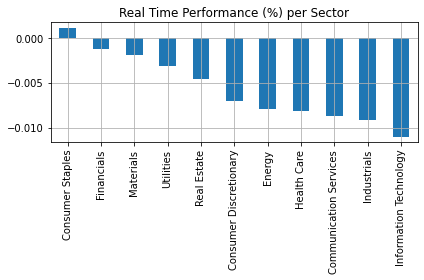

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

124.3500


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
135     DGRO
136     TD6C
137     TDG0
138    PTTRX
139      NaN
Name: Ticker, Length: 140, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
15-Feb - UP (43.6000)
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb
16-Mar
04-Feb - UP (64.9900)
17-Feb
27-Jan - UP (319.1700)
09-Feb - UP (8.8500)
14-Mar
09-Mar
17-Feb - UP (78.4600)
02-Mar
23-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
17-Feb
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb - UP (80.9100)
22-Feb
09-Feb - UP (205.9100)
09-Feb - UP (152.1600)
28-Feb
23-Feb
16-Feb - DN (9.7000)
16-Feb - DN (746.8500)
26-Jan - UP (228.2200)
15-Feb - DN (89.0600)
21-Feb
28-Feb
23-Feb
08-Feb - UP (8.5800)
22-Feb
15-Feb - UP (61.9700)
15-Feb - UP (11.8800)
28-Feb
08-Feb - UP (364.9400)
03-Feb - UP (138.1800)
08-Feb - UP (37.2700)
10-Feb - DN (51.3400)
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb - DN (12.7600)
21-Mar
08-Mar
02-Mar
22-Feb
10-Feb - UP (629.8000)
22-Feb
01-Feb - UP (118.0100)
02-Feb - DN (128.7200)
23-Feb
17-Feb - DN (11.7700)
16-Feb - DN (245.0700)
15-Feb - UP (148.0100)
23-Feb
17-Feb
01

In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [28]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter", "Profitability"]
    if any(word.upper() in title.upper() for word in words1) and any(word.upper() in title.upper() for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [33]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [34]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [35]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTALCURRENTASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [104]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FIRST QUARTER", "SECOND QUARTER", "THIRD QUARTER", "FOURTH QUARTER", "FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace("•", np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("•", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("HEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "%" else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [37]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [38]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [105]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1321655/000119312522044821/d317188dex991.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 41

FOR TABLE 0

TABLE DESCRIPTION:   
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  • NaN  Total revenue grew 34% year-over-year to $433 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                           3
0 NaN  • NaN  Commercial revenue grew 47% year-over-year
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
    0  1   2                                               3
0 NaN  • NaN  US commercial revenue grew 132% year-over-year
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:   
ORIGINAL TABLE  3
    0  1   2                                           3
0 NaN  • NaN  Government revenue grew 26% year-over-year
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 4

TABLE DESCRIPTION:   
ORIGINAL TABLE  4
    0  1   2                

{1: [2], 3: [4], 5: [5], 7: [8], 9: [10], 11: [11]}

FINAL REPORT
                                  METRIC AMOUNT FOURTH QUARTER  \
7                   LOSS FROM OPERATIONS               $(58943   
8        ADJUSTED INCOME FROM OPERATIONS               $124033   
9              CASH FLOW FROM OPERATIONS                $93427   
10               ADJUSTED FREE CASH FLOW               $104196   
11                              NET LOSS              $(156188   
12                   ADJUSTED NET INCOME                $45397   
13                       ADJUSTED EBITDA               $127873   
14      GAAP NET LOSS PER SHARE, DILUTED                $(0.08   
15  ADJUSTED EARNINGS PER SHARE, DILUTED                 $0.02   

   NAN FOURTH QUARTER MARGIN FOURTH QUARTER AMOUNT FULL YEAR 2021  \
7                   )                 (14)%              $(411046   
8                 nan                   29%               $473452   
9                 nan                   22%               $333851 

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                       METRIC  \
3                             COST OF REVENUE   
4                         SALES AND MARKETING   
5                    RESEARCH AND DEVELOPMENT   
6                  GENERAL AND ADMINISTRATIVE   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE (I)   

  THREE MONTHS ENDEDDECEMBER 31, 2021 THREE MONTHS ENDEDDECEMBER 31, 2020  \
3                              $13680                              $19342   
4                               56492                               75852   
5                               27322                               47365   
6                               69413                               99229   
8                             $166907                             $241788   

  YEARS ENDEDDECEMBER 31, 2021 YEARS ENDEDDECEMBER 31, 2020  
3                       $68546                      $139627  
4                       242910                      

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8                               DEFERRED INCOME TAXES   
9                  IMPAIRMENT OF ASSETS HELD FOR SALE   
10                   NON-CASH OPERATING LEASE EXPENSE   
11  UNREALIZED AND REALIZED LOSS (GAIN) FROM MARKE...   
12                         OTHER OPERATING ACTIVITIES   
13        CHANGES IN OPERATING ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
16                                       OTHER ASSETS   
17                                   ACCOUNTS PAYABLE   
18                                ACCRUED LIABILITI

FINAL REPORT
                                               METRIC  \
3                                LOSS FROM OPERATIONS   
4                        ADD STOCK-BASED COMPENSATION   
5   ADD EMPLOYER PAYROLL TAXES RELATED TO STOCK-BA...   
6            ADD NON-RECURRING DIRECT LISTING CHARGES   
8                     ADJUSTED INCOME FROM OPERATIONS   
10                          ADJUSTED OPERATING MARGIN   
12  ADJUSTED FREE CASH FLOW (IN THOUSANDS, EXCEPT ...   

   THREE MONTHS ENDEDDECEMBER 31, 2021 THREE MONTHS ENDEDDECEMBER 31, 2020  \
3                              $(58943                            $(156572   
4                               166907                              241788   
5                                16069                               18933   
6                                  nan                                 nan   
8                              $124033                             $104149   
10                                 29%                        


FINAL REPORT
                                               METRIC  \
3        NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
4   LESS CHANGE IN FAIR VALUE ATTRIBUTABLE TO PART...   
6   NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS, ...   
7                        ADD STOCK-BASED COMPENSATION   
8   ADD EMPLOYER PAYROLL TAXES RELATED TO STOCK-BA...   
9            ADD NON-RECURRING DIRECT LISTING CHARGES   
10     ADD (LESS) INCOME TAX EFFECTS AND ADJUSTMENTS    
12  ADJUSTED NET INCOME ATTRIBUTABLE TO COMMON STO...   
14  WEIGHTED-AVERAGE SHARES USED IN COMPUTING GAAP...   
16  ADJUSTED WEIGHTED-AVERAGE SHARES USED IN COMPU...   
18               ADJUSTED EARNINGS PER SHARE, DILUTED   

   THREE MONTHS ENDEDDECEMBER 31, 2021 THREE MONTHS ENDEDDECEMBER 31, 2020  \
3                             $(156188                            $(148343   
4                                  nan                                 nan   
6                              (156188                             

In [39]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [40]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [41]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [42]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

None


In [43]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [73]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Quote for stock ENB on earning date 15-Feb - UP (43.6000) already generated
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Earning report for stock KNSL on date 2022-02-17 exists
Earning released for stock KNSL AH
Get price diff for stock KNSL from date 2022-02-17 and date 2022-02-18
Update Stock KNSL with quote 17-Feb
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Earning report for stock APPN on date 2022-02-17 exists
Earning released for stock APPN AH
Get price diff

Update Stock DKNG with quote 18-Feb
Earning for stock DPZ will be released later on 2022-03-01
Quote for stock DPZ on earning date 01-Mar not generated yet
Quote for stock FB on earning date 02-Feb - DN (237.7600) already generated
Earning for stock PUBM will be released later on 2022-02-21
Quote for stock PUBM on earning date 21-Feb not generated yet
Earning for stock OKTA will be released later on 2022-03-01
Quote for stock OKTA on earning date 01-Mar not generated yet
Earning for stock RH will be released later on 2022-03-22
Quote for stock RH on earning date 22-Mar not generated yet
Quote for stock YNDX on earning date 15-Feb - UP (52.4000) already generated
Earning for stock RVLV will be released later on 2022-02-22
Quote for stock RVLV on earning date 22-Feb not generated yet
Earning for stock ETSY will be released later on 2022-02-23
Quote for stock ETSY on earning date 23-Feb not generated yet
Earning for stock VIR will be released later on 2022-02-23
Quote for stock VIR on ear

In [44]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [45]:
stocks = get_earningDates(d, "TD")
print(stocks, "\n", len(stocks))

[] 
 0


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [46]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [47]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [48]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [49]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [338]:
import json
org = "NET"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/NET/profile?p=NET
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-transactions?p=NET
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-roster?p=NET
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/holders?p=NET
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 6.50%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 87.32%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 93.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 839
https://finance.yahoo.com/quote/NET/analysis?p=NET
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 12/30/2020 1 1 -0.02
Table Number 2
FOUND
2 3/30/2021 1 2 -0.03
Table Number 2
FOUND
3 6/29/2021 1 3 -0.02
Table Number 2
FOUND
4 9/29/2021 1 4 0
Table Number 2
FOUND
1 12/30/2020 0 1 -0.03
Table Number 2
FOUND
2 3/30/2021 0 2 -0.03
Table Numb

In [42]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

6


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [50]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [51]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [52]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [53]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [54]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [55]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [56]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [57]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [58]:
def isBold(tag, ctext):
    listag = ["ul", "li"]
    if((tag.name == "b" and tag.parent.name not in listag) or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [59]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tags), ctag.name, ctag.text, tags)
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.name == "u"):
                continue
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [60]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [61]:
def isPadLeft(item):
    if(item.name == "ul" or item.name == "li"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
            if("text-indent" in style):
                val = style.split(":")[1]
                val = val.replace("%","")
                try:
                    val = float(val)
                    if(val > 0):
                        return True
                except ValueError:
                    return False
                return False
    return False

In [85]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [86]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    listag = ["ul", "li"]
    if not txt:
        if(item.name in listag):
            ctext = (" ".join(item.strings))
        else:
            ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace("\n","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.replace("       ", " ")
    ctext = ctext.replace("     ", " ")
    ctext = ctext.replace("    ", " ")
    ctext = ctext.replace("   ", " ")
    ctext = ctext.replace("  ", " ")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name not in listag and item.parent.name not in listag):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [87]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [88]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle+" .")
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk]+" .")
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            ndata = ndata.replace("$ ","$")
            ndata = ndata.replace(" %","%")
            ndata = ndata.replace(" to ","  ")
            ndata = ndata.replace("Non - GAAP", "Non-GAAP")
            ndata = ndata.replace("non - GAAP", "Non-GAAP")
            print(ndata)
            f.write("NOPAD*** "+ndata+" .")
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr+" .")
    f.write("\n")
    return possibleTblTitle

In [101]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            eyr = eyr + emonth
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    hc = False #Header continue to next row
    dollarCol = list()
    f.write("\n")
    f.write(tblStr+" .")
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            hc = False
            continue
        nanCnt = 0
        met = string.capwords(met.lower())
        if("Non-gaap" in met):
            met = met.replace("Non-gaap", "Non-GAAP")
        if("Gaap" in met):
            met = met.replace("Gaap", "GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                newcol = string.capwords(newcol.lower())
                if("Non-gaap" in newcol):
                    newcol = newcol.replace("Non-gaap", "Non-GAAP")
                if("Gaap" in newcol):
                    newcol = newcol.replace("Gaap", "GAAP")
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\)-\(', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met.upper() and "PER SHARE" not in met.upper() and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + " " + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + " " + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met.upper() or "EPS" in met.upper())):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
                hc = True
            else:
                if hc:
                    header = header + " " + met
                else:
                    header = met
        elif(met == "TOTAL"):
            header = None
        else:
            hc = False
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr+" .")
    f.write("\n")

In [90]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br", "li"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul" and len(tag.findChildren("li", recursive=True)) == 0):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "li" and len(tag.findChildren("li", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [91]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2021-08-12"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [106]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477333/000119312522034540/d243920dex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1321655/000119312522044821/d317188dex991.htm"
source = getPgSource(url)

In [107]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 41

FOR TABLE 0

TABLE DESCRIPTION:   
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  • NaN  Total revenue grew 34% year-over-year to $433 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                           3
0 NaN  • NaN  Commercial revenue grew 47% year-over-year
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
    0  1   2                                               3
0 NaN  • NaN  US commercial revenue grew 132% year-over-year
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:   
ORIGINAL TABLE  3
    0  1   2                                           3
0 NaN  • NaN  Government revenue grew 26% year-over-year
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 4

TABLE DESCRIPTION:   
ORIGINAL TABLE  4
    0  1   2                

FINAL REPORT
                  METRIC AMOUNT FOURTH QUARTER AMOUNT FULL YEAR 2021
3                REVENUE               $432867              $1541889
4  YEAR-OVER-YEAR GROWTH                   34%                   41%
{1: [2], 3: [4], 5: [5], 7: [8], 9: [10], 11: [11]}

FINAL REPORT
                                  METRIC AMOUNT FOURTH QUARTER  \
7                   LOSS FROM OPERATIONS               $(58943   
8        ADJUSTED INCOME FROM OPERATIONS               $124033   
9              CASH FLOW FROM OPERATIONS                $93427   
10               ADJUSTED FREE CASH FLOW               $104196   
11                              NET LOSS              $(156188   
12                   ADJUSTED NET INCOME                $45397   
13                       ADJUSTED EBITDA               $127873   
14      GAAP NET LOSS PER SHARE, DILUTED                $(0.08   
15  ADJUSTED EARNINGS PER SHARE, DILUTED                 $0.02   

   NAN FOURTH QUARTER MARGIN FOURTH QUARTER AMOUNT FU

FOR TABLE 32

TABLE DESCRIPTION:   
ORIGINAL TABLE  32
     0                                                  1
0  (1)  Includes stock-based compensation expense as f...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 33

TABLE DESCRIPTION:   
ORIGINAL TABLE  33
                                           0   1   \
0                                         NaN NaN   
1                                         NaN NaN   
2                                         NaN NaN   
3                             Cost of revenue NaN   
4                         Sales and marketing NaN   
5                    Research and development NaN   
6                  General and administrative NaN   
7                                         NaN NaN   
8  Total stock-based compensation expense (i) NaN   
9                                         NaN NaN   

                               2                               3   \
0                             NaN                             NaN   


{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
3                                OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8                               DEFERRED INCOME TAXES   
9                  IMPAIRMENT OF ASSETS HELD FOR SALE   
10                   NON-CASH OPERATING LEASE EXPENSE   
11  UNREALIZED AND REALIZED LOSS (GAIN) FROM MARKE...   
12                         OTHER OPERATING ACTIVITIES   
13        CHANGES IN OPERATING ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
16                                       OTHER ASSETS   
17                                   ACCOUNTS PAYABLE   
18                                ACCRUED LIABILITI


FINAL REPORT
                                               METRIC  \
3                                LOSS FROM OPERATIONS   
4                        ADD STOCK-BASED COMPENSATION   
5   ADD EMPLOYER PAYROLL TAXES RELATED TO STOCK-BA...   
6            ADD NON-RECURRING DIRECT LISTING CHARGES   
8                     ADJUSTED INCOME FROM OPERATIONS   
10                          ADJUSTED OPERATING MARGIN   
12  ADJUSTED FREE CASH FLOW (IN THOUSANDS, EXCEPT ...   

   THREE MONTHS ENDEDDECEMBER 31, 2021 THREE MONTHS ENDEDDECEMBER 31, 2020  \
3                              $(58943                            $(156572   
4                               166907                              241788   
5                                16069                               18933   
6                                  nan                                 nan   
8                              $124033                             $104149   
10                                 29%                       

In [108]:
allTables

{'TOTAL': 41,
 'PARSESUCCESS': [4, 26, 31, 33, 35, 36, 37, 38],
 'PARSEFAIL': [0,
  1,
  2,
  3,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  27,
  28,
  29,
  30,
  32,
  34,
  39,
  40],
 0: {'ORIGINAL': '[{"0":null,"1":"\\u2022","2":null,"3":"Total revenue grew 34% year-over-year to $433\\u00a0million"}]'},
 1: {'ORIGINAL': '[{"0":null,"1":"\\u2022","2":null,"3":"Commercial revenue grew 47% year-over-year"}]'},
 2: {'ORIGINAL': '[{"0":null,"1":"\\u2022","2":null,"3":"US commercial revenue grew 132% year-over-year"}]'},
 3: {'ORIGINAL': '[{"0":null,"1":"\\u2022","2":null,"3":"Government revenue grew 26% year-over-year"}]'},
 4: {'ORIGINAL': '[{"0":null,"1":"\\u2022","2":null,"3":"Added 34 net new customers in Q4 2021"}]',
  'PARSE': [{'FIRSTCOLUMN': None,
    'TABLEDESC': ' \xa0',
    'TABLENAME': None,
    'SUBTABLE': 1,
    'UNIT': 'T',
    'TABLENUM': 4,
    'COLUMNS': ['METRIC', 'ADDED 34 NET NEW CUSTOM

In [109]:
csym = "PLTR"
rptDest = "../../Summary/EDGAR/8-K/"+csym
textFilename = rptDest+"/PLTR_2022-02-17_EP.txt"
testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
#testOne8KEdgarRpt(url, csym, None, source, allTables)

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** Palantir Reports Revenue Growth of 41% for FY 2021, US Commercial Revenue up 102% Y/Y in FY 2021.

NOPAD*** 2/17/2022.

NOPAD*** DENVER — (BUSINESS WIRE) — PalantirTechnologies Inc. (NYSE:PLTR) today announced financial results for the fourth quarter and fiscal year ended December 31, 2021.


SC*** Q4 2021Highlights.

TABLEEEEEEEEEEE 0
• Total revenue grew 34% year - over - year  $433 million
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
• Commercial revenue grew 47% year - over - year
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
• US commercial revenue grew 132% year - over - year
TABLEEEE CNTTTTT 3
TABLEEEEEEEEEEE 3
• Government revenue grew 26% year - over - year
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
TABLE 4 PARSED SUCCESSFULLY
POSSIBLE EARNING MONTH STR ['FULL YEAR', 'FULL-YEAR', 'FULL FISCAL', 'FISCAL', 'Q1', 'Q4', 'DEC', 'DECEMBER', '12/', '/12', 'MAR', 'MARCH', '3/', '/3', 'GUIDANCE', 'FY', 'FOURTH', 'FIRST']
POSSIBLE EARNING YEAR STR ['2021', 'FY21

In [110]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [111]:
csym = "FIVN"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/FIVN'
1288847
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000011-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000011-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000014-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000128884719000014/a123118exhibit991earningsr.htm
NUMBER OF TABLES 34

FOR TABLE 0

TABLE DESCRIPTION:  FOURTH QUARTER 2018 FINANCIAL RESULTS
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue for the fourth quarter of 2018 increas...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE FOR THE FOURTH QUARTER OF 2018 INCREASED 31% TO A RECORD $72.3 MILLION, COMPARED TO $55.4 MILLION FOR THE FOURTH QUARTER

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                            RESEARCH AND DEVELOPMENT   
10                                SALES AND MARKETING   
11                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
13                      INCOME (LOSS) FROM OPERATIONS   
14                        OTHER INCOME (EXPENSE), NET   
15                                   INTEREST EXPENSE   
16                          INTEREST INCOME AND OTHER   
17                  TOTAL OTHER INCOME (EXPENSE), NET   
18                  INCOME (LOSS) BEFORE INCOME TAXES   
19                         PROVISION FOR INCOME TAXES   
2

{1: [2, 3], 5: [6, 7], 9: [10, 11], 12: [13, 14], 16: [17, 18], 20: [21, 22]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                   GAAP GROSS PROFIT   
8                                   GAAP GROSS MARGIN   
9                                  OPERATING EXPENSES   
10                           RESEARCH AND DEVELOPMENT   
11                                SALES AND MARKETING   
12                         GENERAL AND ADMINISTRATIVE   
13                           TOTAL OPERATING EXPENSES   
14                 GAAP INCOME (LOSS) FROM OPERATIONS   
15                              GAAP OPERATING MARGIN   
16                        OTHER INCOME (EXPENSE), NET   
17                  INCOME (LOSS) BEFORE INCOME TAXES   
18                         PROVISION FOR INCOME TAXES   
19                             GAAP NET INCOME (LOSS)

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                      METRIC THREE MONTHS ENDED DECEMBER 31, 2018  \
5          GAAP GROSS PROFIT                               $43996   
6          GAAP GROSS MARGIN                                60.8%   
7       NON-GAAP ADJUSTMENTS                                  nan   
8               DEPRECIATION                                 2041   
9   INTANGIBLES AMORTIZATION                                   88   
10  STOCK-BASED COMPENSATION                                  942   
11     ADJUSTED GROSS PROFIT                               $47067   
12     ADJUSTED GROSS MARGIN                                65.1%   

   THREE MONTHS ENDED DECEMBER 31, 2017 TWELVE MONTHS ENDED DECEMBER 31, 2018  \
5                                $33040                               $153630   
6                                 59.6%                                 59.6%   
7                                   nan                                 

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
5                              GAAP NET INCOME (LOSS)   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
11                                   LEGAL SETTLEMENT   
12  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
13  REVERSAL OF INTEREST AND PENALTIES ON ACCRUED ...   
14                  NON-CASH ADJUSTMENT ON INVESTMENT   
15                                NON-GAAP NET INCOME   
16                   GAAP NET INCOME (LOSS) PER SHARE   
17                                              BASIC   
18                                            DILUTED   
19                      NON-GAAP NET INCOME PER SHARE   
20                       

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
6                                       GAAP NET LOSS   
7                                NON-GAAP ADJUSTMENTS   
8                            STOCK-BASED COMPENSATION   
9                            INTANGIBLES AMORTIZATION   
10  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
11                        INCOME TAX EXPENSE EFFECTS    
12                                NON-GAAP NET INCOME   
13         GAAP NET LOSS PER SHARE, BASIC AND DILUTED   
14                      NON-GAAP NET INCOME PER SHARE   
15                                              BASIC   
16                                            DILUTED   
17  SHARES USED IN COMPUTING GAAP NET LOSS PER SHA...   
18                                              BASIC   
19                                            DILUTED   

   THREE MONTHS ENDING MARCH 31, 2019 LOW  \
6                                  $

8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000048-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000048-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000063-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000128884719000063/a033119ex991earningsrelease.htm
NUMBER OF TABLES 25

FOR TABLE 0

TABLE DESCRIPTION:  FIRST QUARTER 2019 FINANCIAL RESULTS
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue for the first quarter of 2019 increase...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE FOR THE FIRST QUARTER OF 2019 INCREASED 27% TO A RECORD $74.5 MILLION, COMPARED TO $58.9 MILLION FOR THE FIRST QUARTER OF 2018.
ORIGINAL TABLE  1
     0                                                  1
0  NaN                

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8   AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
9   AMORTIZATION OF PREMIUM ON MARKETABLE INVESTMENTS   
10                    PROVISION FOR DOUBTFUL ACCOUNTS   
11                           STOCK-BASED COMPENSATION   
12  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
13  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
14                                             OTHERS   
15        CHANGES IN OPERATING ASSETS AND LIABILITIES   
16                                ACCOUNTS RECEIVABLE   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18                DEFERRED CONTRACT ACQUISITION COSTS   
19                                       OTHER ASSE

FINAL REPORT
                                               METRIC  \
5                                       GAAP NET LOSS   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
11  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
12  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
13                                NON-GAAP NET INCOME   
14                            GAAP NET LOSS PER SHARE   
15                                  BASIC AND DILUTED   
16                      NON-GAAP NET INCOME PER SHARE   
17                                              BASIC   
18                                            DILUTED   
19   SHARES USED IN COMPUTING GAAP NET LOSS PER SHARE   
20                                  BASIC AND DILUTED   
21  SHARES USED IN

FINAL REPORT
                                               METRIC  \
6                                       GAAP NET LOSS   
7                                NON-GAAP ADJUSTMENTS   
8                            STOCK-BASED COMPENSATION   
9                            INTANGIBLES AMORTIZATION   
10  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
11  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
12  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
13                        INCOME TAX EXPENSE EFFECTS    
14                                NON-GAAP NET INCOME   
15         GAAP NET LOSS PER SHARE, BASIC AND DILUTED   
16                      NON-GAAP NET INCOME PER SHARE   
17                                              BASIC   
18                                            DILUTED   
19  SHARES USED IN COMPUTING GAAP NET LOSS PER SHA...   
20                                              BASIC   
21                                            DILUTED   

   THREE MONTHS E

8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000075-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000075-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-19-000105-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000128884719000105/a063019ex991earningsrelease.htm
NUMBER OF TABLES 26

FOR TABLE 0

TABLE DESCRIPTION:  SECOND QUARTER 2019 FINANCIAL RESULTS
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue for the second quarter of 2019 increas...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE FOR THE SECOND QUARTER OF 2019 INCREASED 27% TO A RECORD $77.4 MILLION, COMPARED TO $61.1 MILLION FOR THE SECOND QUARTER OF 2018.
ORIGINAL TABLE  1
     0                                                  1
0  NaN             

FINAL REPORT
                                         METRIC  \
5                                       REVENUE   
6                               COST OF REVENUE   
7                                  GROSS PROFIT   
8                            OPERATING EXPENSES   
9                      RESEARCH AND DEVELOPMENT   
10                          SALES AND MARKETING   
11                   GENERAL AND ADMINISTRATIVE   
12                     TOTAL OPERATING EXPENSES   
13                INCOME (LOSS) FROM OPERATIONS   
14                  OTHER INCOME (EXPENSE), NET   
15                             INTEREST EXPENSE   
16                    INTEREST INCOME AND OTHER   
17            TOTAL OTHER INCOME (EXPENSE), NET   
18                     LOSS BEFORE INCOME TAXES   
19    PROVISION FOR (BENEFIT FROM) INCOME TAXES   
20                                     NET LOSS   
21                           NET LOSS PER SHARE   
22                            BASIC AND DILUTED   
23  SHARES USED IN

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
5                                       GAAP NET LOSS   
6                                NON-GAAP ADJUSTMENTS   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9                                    INTEREST EXPENSE   
10                          INTEREST INCOME AND OTHER   
11                                   LEGAL SETTLEMENT   
12  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
13          PROVISION FOR (BENEFIT FROM) INCOME TAXES   
14                                    ADJUSTED EBITDA   
15                    ADJUSTED EBITDA AS % OF REVENUE   

   THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDED JUNE 30, 2018  \
5                            $(1860                           $(2042   
6                               nan                              nan   
7                              3361 

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23]}

FINAL REPORT
                        METRIC  \
6              COST OF REVENUE   
7     RESEARCH AND DEVELOPMENT   
8          SALES AND MARKETING   
9   GENERAL AND ADMINISTRATIVE   
10                       TOTAL   

   THREE MONTHS ENDED JUNE 30, 2019 STOCK-BASED COMPENSATION  \
6                                               $1658          
7                                                1907          
8                                                2749          
9                                                4122          
10                                             $10436          

   THREE MONTHS ENDED JUNE 30, 2019 DEPRECIATION  \
6                                          $2416   
7                                            450   
8                                              1   
9                                            406   
10                                         $3273   

   TH

NOPAD*** Exhibit.


SC*** Exhibit 99.1.


SC*** Five9 Reports Second Quarter Revenue Growth of 27% to a Record $77.4 Million.

NOPAD*** 36% Growth in LTM Enterprise Subscription Revenue.

NOPAD*** Fourteenth Consecutive Quarter of Positive Operating Cash Flow.

NOPAD*** Raises 2019 Guidance for Both Revenue and Bottom Line.

NOPAD*** SAN RAMON, Calif. - July 31, 2019 - Five9, Inc. (NASDAQ:FIVN), a leading provider of cloud contact center software, today reported results for the second quarter ended June 30, 2019.


SC*** Second Quarter 2019 Financial Results.

TABLEEEEEEEEEEE 0
• Revenue for the second quarter of 2019 increased 27%  a record $77.4 million, compared  $61.1 million for the second quarter of 2018.
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
• GAAP gross margin was 59.6% for the second quarter of 2019, compared  59.4% for the second quarter of 2018.
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
• Adjusted gross margin was 65.0% for the second quarter of 2019, compared  63.8% for the secon

FINAL REPORT
                                         METRIC  \
5                                       REVENUE   
6                               COST OF REVENUE   
7                                  GROSS PROFIT   
8                            OPERATING EXPENSES   
9                      RESEARCH AND DEVELOPMENT   
10                          SALES AND MARKETING   
11                   GENERAL AND ADMINISTRATIVE   
12                     TOTAL OPERATING EXPENSES   
13                       INCOME FROM OPERATIONS   
14                  OTHER INCOME (EXPENSE), NET   
15                             INTEREST EXPENSE   
16                    INTEREST INCOME AND OTHER   
17            TOTAL OTHER INCOME (EXPENSE), NET   
18                     LOSS BEFORE INCOME TAXES   
19                   PROVISION FOR INCOME TAXES   
20                                     NET LOSS   
21                           NET LOSS PER SHARE   
22                            BASIC AND DILUTED   
23  SHARES USED IN

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
5                                       GAAP NET LOSS   
6                                NON-GAAP ADJUSTMENTS   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9                                    INTEREST EXPENSE   
10                          INTEREST INCOME AND OTHER   
11                                   LEGAL SETTLEMENT   
12  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
13                         PROVISION FOR INCOME TAXES   
14                                    ADJUSTED EBITDA   
15                    ADJUSTED EBITDA AS % OF REVENUE   

   THREE MONTHS ENDED SEPTEMBER 30, 2019  \
5                                 $(1604   
6                                    nan   
7                                   3497   
8                                  11075   
9                               

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23]}

FINAL REPORT
                        METRIC  \
6              COST OF REVENUE   
7     RESEARCH AND DEVELOPMENT   
8          SALES AND MARKETING   
9   GENERAL AND ADMINISTRATIVE   
10                       TOTAL   

   THREE MONTHS ENDED SEPTEMBER 30, 2019 STOCK-BASED COMPENSATION  \
6                                               $1702               
7                                                2022               
8                                                3017               
9                                                4334               
10                                             $11075               

   THREE MONTHS ENDED SEPTEMBER 30, 2019 DEPRECIATION  \
6                                               $2514   
7                                                 450   
8                                                   2   
9                                                 443   
10 

NOPAD*** Exhibit.


SC*** Exhibit 99.1.


SC*** Five9 Reports Third Quarter Revenue Growth of 28% to a Record $83.8 Million.

NOPAD*** 36% Growth in LTM Enterprise Subscription Revenue.

NOPAD*** Fifteenth Consecutive Quarter of Positive Operating Cash Flow.

NOPAD*** Raised 2019 Guidance for Both Revenue and Bottom Line.

NOPAD*** SAN RAMON, Calif. - November 5, 2019 - Five9, Inc. (NASDAQ:FIVN), a leading provider of cloud contact center software, today reported results for the third quarter ended September 30, 2019.


SC*** Third Quarter 2019 Financial Results.

TABLEEEEEEEEEEE 0
• Revenue for the third quarter of 2019 increased 28%  a record $83.8 million, compared  $65.3 million for the third quarter of 2018.
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
• GAAP gross margin was 58.8% for the third quarter of 2019, compared  59.9% for the third quarter of 2018.
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
• Adjusted gross margin was 64.0% for the third quarter of 2019, compared  64.3% for the third 

8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001628280-19-014279-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1288847/0001628280-19-014279-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-20-000009-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-20-000009-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-20-000013-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000128884720000013/a123119exhibit991earni.htm
NUMBER OF TABLES 9

FOR TABLE 0

TABLE DESCRIPTION:   
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                              ASS


FINAL REPORT
                                               METRIC DECEMBER 31, 2019  \
4                                              ASSETS               nan   
5                                      CURRENT ASSETS               nan   
6                           CASH AND CASH EQUIVALENTS            $77976   
7                              MARKETABLE INVESTMENTS            241973   
8                            ACCOUNTS RECEIVABLE, NET             37655   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS             10656   
10                DEFERRED CONTRACT ACQUISITION COSTS             13014   
11                               TOTAL CURRENT ASSETS            381274   
12                        PROPERTY AND EQUIPMENT, NET             33190   
13                OPERATING LEASE RIGHT-OF-USE ASSETS              8746   
14                             INTANGIBLE ASSETS, NET             15533   
15                                           GOODWILL             11798   
16         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8   AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
9   AMORTIZATION OF PREMIUM ON MARKETABLE INVESTMENTS   
10                    PROVISION FOR DOUBTFUL ACCOUNTS   
11                           STOCK-BASED COMPENSATION   
12  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
13  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
14                                             OTHERS   
15        CHANGES IN OPERATING ASSETS AND LIABILITIES   
16                                ACCOUNTS RECEIVABLE   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18                DEFERRED CONTRACT ACQUISITION COSTS   
19                         


FINAL REPORT
                                               METRIC  \
5                              GAAP NET INCOME (LOSS)   
6                                NON-GAAP ADJUSTMENTS   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9                                    INTEREST EXPENSE   
10                        INTEREST (INCOME) AND OTHER   
11                                   LEGAL SETTLEMENT   
12  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
13              ACQUISITION RELATED TRANSACTION COSTS   
15                         PROVISION FOR INCOME TAXES   
16                                    ADJUSTED EBITDA   
17                    ADJUSTED EBITDA AS % OF REVENUE   

   THREE MONTHS ENDED DECEMBER 31, 2019 THREE MONTHS ENDED DECEMBER 31, 2018  \
5                                  $836                                $3733   
6                                   nan                                  nan   
7   


FINAL REPORT
                                               METRIC  \
4                              GAAP NET INCOME (LOSS)   
5                                NON-GAAP ADJUSTMENTS   
6                            STOCK-BASED COMPENSATION   
7                            INTANGIBLES AMORTIZATION   
8    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
9   AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
10                                   LEGAL SETTLEMENT   
11  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
12              ACQUISITION RELATED TRANSACTION COSTS   
13                  NON-CASH ADJUSTMENT ON INVESTMENT   
14                                NON-GAAP NET INCOME   
15                   GAAP NET INCOME (LOSS) PER SHARE   
16                                              BASIC   
17                                            DILUTED   
18                      NON-GAAP NET INCOME PER SHARE   
19                                              BASIC   
20               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                        METRIC  \
15             COST OF REVENUE   
16    RESEARCH AND DEVELOPMENT   
17         SALES AND MARKETING   
18  GENERAL AND ADMINISTRATIVE   
19                       TOTAL   

   TWELVE MONTHS ENDED DECEMBER 31, 2019 STOCK-BASED COMPENSATION  \
15                                              $6334               
16                                               7658               
17                                              11368               
18                                              16705               
19                                             $42065               

   TWELVE MONTHS ENDED DECEMBER 31, 2019 DEPRECIATION  \
15                                              $9974   
16                                               1801   
17                                  

NOPAD*** Document.


SC*** Exhibit 99.1.


SC*** Five9 Reports Fourth Quarter Revenue Growth of 28% to a Record $92.3 Million.

NOPAD*** 34% Growth in LTM Enterprise Subscription Revenue.

NOPAD*** Fourth Quarter GAAP Net Income of $0.8 Million.

NOPAD*** Fourth Quarter Adjusted EBITDA of $19.6 Million, or 21.2% of Revenue.

NOPAD*** SAN RAMON, Calif. - February 19, 2020 - Five9, Inc. (NASDAQ:FIVN), a leading provider of cloud contact center software for the digital enterprise, today reported results for the fourth quarter and full year ended December 31, 2019.


SC*** Fourth Quarter 2019 Financial Results.


SC*** 2019 Financial Results.

NOPAD*** “We delivered very strong fourth quarter results, leading to a great close of the year. Fourth quarter revenue was $92.3 million, up 28% year-over-year, and was driven by our success in our Enterprise business. In 2019, we believe we set the foundation for our next decade of growth. We significantly strengthened the leadership team and expan

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8   AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
9   AMORTIZATION OF PREMIUM ON MARKETABLE INVESTMENTS   
10                    PROVISION FOR DOUBTFUL ACCOUNTS   
11                           STOCK-BASED COMPENSATION   
14  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
17  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
19                                             OTHERS   
20        CHANGES IN OPERATING ASSETS AND LIABILITIES   
21                                ACCOUNTS RECEIVABLE   
22          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
23                DEFERRED CONTRACT ACQUISITION COSTS   
24                         


FINAL REPORT
                                               METRIC  \
5                                LOSS FROM OPERATIONS   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
9   LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
10              ACQUISITION-RELATED TRANSACTION COSTS   
11                          NON-GAAP OPERATING INCOME   

   THREE MONTHS ENDED MARCH 31, 2020 THREE MONTHS ENDED MARCH 31, 2019  
5                            $(4956)                            $(322)  
6                                nan                               nan  
7                              13794                              8686  
8                               1090                                88  
9                                nan                               292  
10                               329                               nan  
11                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                       METRIC  \
5             COST OF REVENUE   
6    RESEARCH AND DEVELOPMENT   
7         SALES AND MARKETING   
8  GENERAL AND ADMINISTRATIVE   
9                       TOTAL   

  THREE MONTHS ENDED MARCH 31, 2020 STOCK-BASED COMPENSATION  \
5                                              $1989           
6                                               2806           
7                                               4106           
8                                               4893           
9                                             $13794           

  THREE MONTHS ENDED MARCH 31, 2020 DEPRECIATION  \
5                                          $2850   
6                                            465   
7                                              2   
8                                  

NOPAD*** Document.


SC*** Exhibit 99.1.


SC*** Five9 Reports First Quarter Revenue Growth of 28% to a Record $95.1 Million.

NOPAD*** 33% Growth in LTM Enterprise Subscription Revenue.

NOPAD*** Seventeenth Consecutive Quarter of Positive Operating Cash Flow at $10.4 Million.

NOPAD*** SAN RAMON, Calif. - May 4, 2020 - Five9, Inc. (NASDAQ:FIVN), a leading provider of cloud contact center software, today reported results for the first quarter ended March 31, 2020.


SC*** First Quarter 2020 Financial Results.

NOPAD*** “We delivered strong first quarter results, with revenue of $95.1 million, up 28% year-over-year, driven by our continued success in our Enterprise business. I am extremely proud of the ways in which we’ve delivered exceptional service to our customers during the COVID-19 pandemic. In recent weeks we’ve helped our customers transition tens of thousands of agents to work from home, and mobilized a rapid response team and toolset to give customers flexibility to scale up 

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JUNE 30, 2020  \
4                                              ASSETS           nan   
5                                      CURRENT ASSETS           nan   
6                           CASH AND CASH EQUIVALENTS       $233235   
7                              MARKETABLE INVESTMENTS        452708   
8                            ACCOUNTS RECEIVABLE, NET         39607   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS         17529   
10                DEFERRED CONTRACT ACQUISITION COSTS         16151   
11                               TOTAL CURRENT ASSETS        759230   
12                        PROPERTY AND EQUIPMENT, NET         39799   
13                OPERATING LEASE RIGHT-OF-USE ASSETS         10006   
14                             INTANGIBLE ASSETS, NET         25605   
15                                           GOODWILL         34444   
16                           

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8   AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
9   AMORTIZATION OF PREMIUM ON MARKETABLE INVESTMENTS   
10                    PROVISION FOR DOUBTFUL ACCOUNTS   
11                           STOCK-BASED COMPENSATION   
12               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
15  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
18  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
20  TAX BENEFIT OF VALUATION ALLOWANCE ASSOCIATED ...   
21                                             OTHERS   
22        CHANGES IN OPERATING ASSETS AND LIABILITIES   
23                                ACCOUNTS RECEIVABLE   
24          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
25                

FINAL REPORT
                                               METRIC  \
5                                       GAAP NET LOSS   
6                                NON-GAAP ADJUSTMENTS   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9                                    INTEREST EXPENSE   
10                          INTEREST INCOME AND OTHER   
11                                   LEGAL SETTLEMENT   
12  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
13  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
14                  COVID- RELIEF BONUS FOR EMPLOYEES   
15          PROVISION FOR (BENEFIT FROM) INCOME TAXES   
16                                    ADJUSTED EBITDA   
17                    ADJUSTED EBITDA AS % OF REVENUE   

   THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, 2019  \
5                          $(16052)                          $(1860)   
6                               nan         


FINAL REPORT
                                               METRIC  \
5                                       GAAP NET LOSS   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
9   AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
10                                   LEGAL SETTLEMENT   
11  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
12  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
13                  COVID- RELIEF BONUS FOR EMPLOYEES   
14               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
15  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
16  TAX BENEFIT OF VALUATION ALLOWANCE ASSOCIATED ...   
17                                NON-GAAP NET INCOME   
18                            GAAP NET LOSS PER SHARE   
19                                  BASIC AND DILUTED   
22                      NON-GAAP NET INCOME PER SHARE   
23               


FINAL REPORT
                        METRIC  \
15             COST OF REVENUE   
16    RESEARCH AND DEVELOPMENT   
17         SALES AND MARKETING   
18  GENERAL AND ADMINISTRATIVE   
19                       TOTAL   

   SIX MONTHS ENDED JUNE 30, 2020 STOCK-BASED COMPENSATION  \
15                                              $4488        
16                                               6491        
17                                               9371        
18                                              10235        
19                                             $30585        

   SIX MONTHS ENDED JUNE 30, 2020 DEPRECIATION  \
15                                       $6232   
16                                         963   
17                                           3   
18                                        1187   
19                                       $8385   

   SIX MONTHS ENDED JUNE 30, 2020 INTANGIBLES AMORTIZATION  \
15                                           

NOPAD*** Document.


SC*** Exhibit 99.1.


SC*** Five9 Reports Second Quarter Revenue Growth of 29% to a Record $99.8 Million.

NOPAD*** 33% Growth in LTM Enterprise Subscription Revenue.

NOPAD*** Eighteenth Consecutive Quarter of Positive Operating Cash Flow at $14.8 Million.

NOPAD*** Raised 2020 Guidance for both Revenue and Bottom Line.

NOPAD*** SAN RAMON, Calif. - August 3, 2020 - Five9, Inc. (NASDAQ:FIVN), a leading provider of cloud contact center software, today reported results for the second quarter ended June 30, 2020.


SC*** Second Quarter 2020 Financial Results.

NOPAD*** "We delivered exceptionally strong second quarter results with revenue of $99.8 million. Revenue growth accelerated to 29% year-over-year and 5% sequentially, adjusted EBITDA margin was 18.3%, and we delivered our eighteenth consecutive quarter of positive operating cash flow. We believe the on-premises to cloud and digital transformation trends driving our massive market opportunity are likely to acce

FINAL REPORT
                                         METRIC  \
5                                       REVENUE   
6                               COST OF REVENUE   
7                                  GROSS PROFIT   
8                            OPERATING EXPENSES   
9                      RESEARCH AND DEVELOPMENT   
10                          SALES AND MARKETING   
11                   GENERAL AND ADMINISTRATIVE   
12                     TOTAL OPERATING EXPENSES   
13                INCOME (LOSS) FROM OPERATIONS   
14                  OTHER INCOME (EXPENSE), NET   
15                             INTEREST EXPENSE   
16                    INTEREST INCOME AND OTHER   
17            TOTAL OTHER INCOME (EXPENSE), NET   
18                     LOSS BEFORE INCOME TAXES   
19    PROVISION FOR (BENEFIT FROM) INCOME TAXES   
20                                     NET LOSS   
21                           NET LOSS PER SHARE   
22                            BASIC AND DILUTED   
25  SHARES USED IN

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                               METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
5                   GAAP GROSS PROFIT                                $65582   
6                   GAAP GROSS MARGIN                                 58.5%   
7                NON-GAAP ADJUSTMENTS                                   nan   
8                        DEPRECIATION                                  3433   
9            INTANGIBLES AMORTIZATION                                  1738   
10           STOCK-BASED COMPENSATION                                  2603   
11  COVID- RELIEF BONUS FOR EMPLOYEES                                   nan   
12              ADJUSTED GROSS PROFIT                                $73356   
13              ADJUSTED GROSS MARGIN                                 65.4%   

   THREE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
5                        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                       INCOME (LOSS) FROM OPERATIONS   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
9                                    LEGAL SETTLEMENT   
10  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
11  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
12                  COVID- RELIEF BONUS FOR EMPLOYEES   
13                          NON-GAAP OPERATING INCOME   

   THREE MONTHS ENDED SEPTEMBER 30, 2020  \
5                                $(1785)   
6                                    nan   
7                                  17286   
8                                   1738   
9                                    nan   
10                                   nan   
11                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                       METRIC  \
5             COST OF REVENUE   
6    RESEARCH AND DEVELOPMENT   
7         SALES AND MARKETING   
8  GENERAL AND ADMINISTRATIVE   
9                       TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 STOCK-BASED COMPENSATION  \
5                                              $2603               
6                                               3876               
7                                               5427               
8                                               5380               
9                                             $17286               

  THREE MONTHS ENDED SEPTEMBER 30, 2020 DEPRECIATION  \
5                                              $3433   
6                                                512   
7                                                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                       GAAP NET LOSS   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
9   AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
10               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
11  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
12                  COVID- RELIEF BONUS FOR EMPLOYEES   
13  TAX BENEFIT OF VALUATION ALLOWANCE ASSOCIATED ...   
14                        INCOME TAX EXPENSE EFFECTS    
15                                NON-GAAP NET INCOME   
16         GAAP NET LOSS PER SHARE, BASIC AND DILUTED   
17                      NON-GAAP NET INCOME PER SHARE   
18                                              BASIC   
19                                        

8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-21-000003-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000128884721000003/newboarddirectorjan2021bar.htm
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1288847/000128884721000003/newboarddirectorjan2021bar.htm
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-21-000012-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-21-000012-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-21-000019-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000128884721000019/a123120ex991earningsreleas.htm
NUMBER OF TABLES 9

FOR TABLE 0

TABLE DESCRIPTION:  (UNAUDITED)
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                        

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                            RESEARCH AND DEVELOPMENT   
10                                SALES AND MARKETING   
11                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
13                      INCOME (LOSS) FROM OPERATIONS   
14                        OTHER INCOME (EXPENSE), NET   
15                                   INTEREST EXPENSE   
16               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
17                          INTEREST INCOME AND OTHER   
18                  TOTAL OTHER INCOME (EXPENSE), NET   
19                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                               METRIC THREE MONTHS ENDED DECEMBER 31, 2020  \
4                   GAAP GROSS PROFIT                               $76652   
5                   GAAP GROSS MARGIN                                59.9%   
6                NON-GAAP ADJUSTMENTS                                  nan   
7                        DEPRECIATION                                 3665   
8            INTANGIBLES AMORTIZATION                                 2283   
9            STOCK-BASED COMPENSATION                                 2331   
10  COVID- RELIEF BONUS FOR EMPLOYEES                                  nan   
11              ADJUSTED GROSS PROFIT                               $84931   
12              ADJUSTED GROSS MARGIN                                66.4%   

   THREE MONTHS ENDED DECEMBER 31, 2019 TWELVE MONTHS ENDED DECEMBER 31, 2020  \
4                                $5

FINAL REPORT
                                               METRIC  \
4                       INCOME (LOSS) FROM OPERATIONS   
5                                NON-GAAP ADJUSTMENTS   
6                            STOCK-BASED COMPENSATION   
7                            INTANGIBLES AMORTIZATION   
8                                    LEGAL SETTLEMENT   
9   LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
10  ACQUISITION RELATED TRANSACTION COSTS AND ONE-...   
11                  COVID- RELIEF BONUS FOR EMPLOYEES   
12                          NON-GAAP OPERATING INCOME   

   THREE MONTHS ENDED DECEMBER 31, 2020 THREE MONTHS ENDED DECEMBER 31, 2019  \
4                                 $2665                                $3032   
5                                   nan                                  nan   
6                                 16876                                11868   
7                                  2283                                  618   
8               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                       METRIC  \
5             COST OF REVENUE   
6    RESEARCH AND DEVELOPMENT   
7         SALES AND MARKETING   
8  GENERAL AND ADMINISTRATIVE   
9                       TOTAL   

  THREE MONTHS ENDED DECEMBER 31, 2020 STOCK-BASED COMPENSATION  \
5                                              $2331              
6                                               3675              
7                                               5366              
8                                               5504              
9                                             $16876              

  THREE MONTHS ENDED DECEMBER 31, 2020 DEPRECIATION  \
5                                             $3665   
6                                               488   
7                                                 2   
8    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                       GAAP NET LOSS   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
9   AMORTIZATION OF ISSUANCE COSTS ON CONVERTIBLE ...   
10                         ONE-TIME INTEGRATION COSTS   
11                        INCOME TAX EXPENSE EFFECTS    
12                                NON-GAAP NET INCOME   
13         GAAP NET LOSS PER SHARE, BASIC AND DILUTED   
14                      NON-GAAP NET INCOME PER SHARE   
15                                              BASIC   
16                                            DILUTED   
17  SHARES USED IN COMPUTING GAAP NET LOSS PER SHA...   
18                                              BASIC   
19                                        

8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-21-000066-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000128884721000066/a033121ex991earningsrelease.htm
NUMBER OF TABLES 9

FOR TABLE 0

TABLE DESCRIPTION:  (UNAUDITED)  
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                              ASSETS   
5                                     Current assets:   
6                           Cash and cash equivalents   
7                              Marketable investments   
8                            Accounts receivable, net   
9           Prepaid expenses and other current assets   
10           Deferred contract acquisition costs, net   
11                               Tot

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8   AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
9                    AMORTIZATION OF COMMISSION COSTS   
10  AMORTIZATION OF PREMIUM ON MARKETABLE INVESTMENTS   
11                    PROVISION FOR DOUBTFUL ACCOUNTS   
12                           STOCK-BASED COMPENSATION   
19  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
21  CHANGE IN FAIR OF VALUE OF CONTINGENT CONSIDER...   
22                                              OTHER   
23        CHANGES IN OPERATING ASSETS AND LIABILITIES   
24                                ACCOUNTS RECEIVABLE   
25          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
26 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
5                                LOSS FROM OPERATIONS   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
11  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
12                   CONTINGENT CONSIDERATION EXPENSE   
14                          NON-GAAP OPERATING INCOME   

   THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
5                           $(11086)                           $(4956)  
6                                nan                               nan  
7                              20908                             13794  
8                               2947                              1090  
11                              1094                               329  
12                              2500        

FINAL REPORT
                       METRIC  \
5             COST OF REVENUE   
6    RESEARCH AND DEVELOPMENT   
7         SALES AND MARKETING   
8  GENERAL AND ADMINISTRATIVE   
9                       TOTAL   

  THREE MONTHS ENDED MARCH 31, 2021 STOCK-BASED COMPENSATION  \
5                                              $3105           
6                                               4763           
7                                               6771           
8                                               6269           
9                                             $20908           

  THREE MONTHS ENDED MARCH 31, 2021 DEPRECIATION  \
5                                          $4140   
6                                            596   
7                                              1   
8                                           1079   
9                                          $5816   

  THREE MONTHS ENDED MARCH 31, 2021 INTANGIBLES AMORTIZATION  \
5                         

NOPAD*** Document.


SC*** Exhibit 99.1.

NOPAD*** Five9 Reports First Quarter Record Revenue Growth of 45% to a Record $137.9 Million.

NOPAD*** 45% Growth in LTM Enterprise Subscription Revenue.

NOPAD*** Raised 2021 Guidance for both Revenue and Bottom Line.

NOPAD*** SAN RAMON, Calif. - April 29, 2021 - Five9, Inc. (NASDAQ:FIVN), a leading provider of cloud contact center software, today reported results for the first quarter ended March 31, 2021.


SC*** First Quarter 2021 Financial Results.

NOPAD*** “Our first quarter results exceeded expectations across the board. We delivered record first quarter revenue of $138 million, accelerating 45% year-over-year, an all-time high. Performance was driven by ongoing success with enterprises globally as we continue to close large deals, by our product innovation as a leader in AI-powered automation, and our go-to-market execution. We’ve started this year off with incredible traction and are well positioned to extend our leadership position

59               NaN  
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8   AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10  AMORTIZATION OF PREMIUM ON MARKETABLE INVESTMENTS   
11                    PROVISION FOR DOUBTFUL ACCOUNTS   
12                           STOCK-BASED COMPENSATION   
13               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
19  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
21  CHANGE IN FAIR OF VALUE OF CONTINGENT CONSIDER...   
22  TAX BENEFIT OF VALUATION ALLOWANCE ASSOCIATED ...   
23                                              OTHER   
24        CHANGES IN OPERATING ASSETS

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                       GAAP NET LOSS   
6                                NON-GAAP ADJUSTMENTS   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9                                    INTEREST EXPENSE   
10               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
11                OTHER EXPENSE AND INTEREST (INCOME)   
14  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
15                  COVID- RELIEF BONUS FOR EMPLOYEES   
16                   CONTINGENT CONSIDERATION EXPENSE   
18                          BENEFIT FROM INCOME TAXES   
19                                    ADJUSTED EBITDA   
20                    ADJUSTED EBITDA AS % OF REVENUE   

   THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
5                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                       METRIC  \
5             COST OF REVENUE   
6    RESEARCH AND DEVELOPMENT   
7         SALES AND MARKETING   
8  GENERAL AND ADMINISTRATIVE   
9                       TOTAL   

  THREE MONTHS ENDED JUNE 30, 2021 STOCK-BASED COMPENSATION  \
5                                              $3781          
6                                               6152          
7                                               8208          
8                                               6760          
9                                             $24901          

  THREE MONTHS ENDED JUNE 30, 2021 DEPRECIATION  \
5                                         $4878   
6                                           729   
7                                             1   
8                                          10

8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001193125-21-289272-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000119312521289272/d170961dex991.htm
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1288847/000119312521289272/d170961dex991.htm
8K URL https://www.sec.gov/Archives/edgar/data/1288847/0001288847-21-000137-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1288847/000128884721000137/a093021ex991earningsrelease.htm
NUMBER OF TABLES 8

FOR TABLE 0

TABLE DESCRIPTION:    (IN THOUSANDS)
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                              ASSETS   
5                                     Current assets:   
6                 

[31 rows x 27 columns]
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                         METRIC  \
5                                       REVENUE   
6                               COST OF REVENUE   
7                                  GROSS PROFIT   
8                            OPERATING EXPENSES   
9                      RESEARCH AND DEVELOPMENT   
10                          SALES AND MARKETING   
11                   GENERAL AND ADMINISTRATIVE   
12                     TOTAL OPERATING EXPENSES   
13                         LOSS FROM OPERATIONS   
14                  OTHER (EXPENSE) INCOME, NET   
15                             INTEREST EXPENSE   
16         LOSS ON EARLY EXTINGUISHMENT OF DEBT   
17          INTEREST INCOME AND OTHER (EXPENSE)   
18            TOTAL OTHER (EXPENSE) INCOME, NET   
19                     LOSS BEFORE INCOME TAXES   
20    (BENEFIT FROM) PROVISION FOR

[15 rows x 27 columns]
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                               METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
5                   GAAP GROSS PROFIT                                $87191   
6                   GAAP GROSS MARGIN                                 56.5%   
7                NON-GAAP ADJUSTMENTS                                   nan   
8                        DEPRECIATION                                  4711   
9            INTANGIBLES AMORTIZATION                                  2947   
10           STOCK-BASED COMPENSATION                                  3994   
11  COVID- RELIEF BONUS FOR EMPLOYEES                                   nan   
12         ONE-TIME INTEGRATION COSTS                                    37   
13              ADJUSTED GROSS PROFIT                                $98880   
14              ADJUSTED GROSS MARGIN                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
5                                LOSS FROM OPERATIONS   
6                                NON-GAAP ADJUSTMENTS   
7                            STOCK-BASED COMPENSATION   
8                            INTANGIBLES AMORTIZATION   
11  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
12                  COVID- RELIEF BONUS FOR EMPLOYEES   
13                   CONTINGENT CONSIDERATION EXPENSE   
15                          NON-GAAP OPERATING INCOME   

   THREE MONTHS ENDED SEPTEMBER 30, 2021  \
5                               $(18991)   
6                                    nan   
7                                  27395   
8                                   2947   
11                                  9158   
12                                   nan   
13                                    60   
15                             

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                       METRIC  \
5             COST OF REVENUE   
6    RESEARCH AND DEVELOPMENT   
7         SALES AND MARKETING   
8  GENERAL AND ADMINISTRATIVE   
9                       TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 STOCK-BASED COMPENSATION  \
5                                              $3994               
6                                               9101               
7                                               8304               
8                                               5996               
9                                             $27395               

  THREE MONTHS ENDED SEPTEMBER 30, 2021 DEPRECIATION  \
5                                              $4711   
6                                               1004   
7                                                  

['https://www.sec.gov/Archives/edgar/data/1288847/000128884719000014/a123118exhibit991earningsr.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884719000063/a033119ex991earningsrelease.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884719000105/a063019ex991earningsrelease.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884719000133/a093019ex991earningsre.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884720000013/a123119exhibit991earni.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884720000063/a033120ex991earningsre.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884720000121/a063020ex991earningsre.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884720000154/a093020ex991earningsre.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884721000019/a123120ex991earningsreleas.htm', 'https://www.sec.gov/Archives/edgar/data/1288847/000128884721000066/a033121ex991earningsrelease.htm', 'https

In [112]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [113]:
csym = "FIVN"
storeEdgarRpt(csym)

1288847
TRYING TO WRITE TEXT DATA FOR FIVN, report type 10-K, date filed 2019-02-25
TRYING TO WRITE RISKS DATA FOR FIVN, report type 10-K, date filed 2019-02-25
ITEM 1A. Risk Factors 
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISK HEADER RISKS RELATED TO REGULATORY MATTERS
RISK HEADER RISKS RELATED TO OWNERSHIP OF COMMON STOCK
RISK HEADER RISKS RELATED TO OWNERSHIP OF CONVERTIBLE SENIOR NOTES
RISKS COUNT 62
TRYING TO WRITE TABLES DATA FOR FIVN, report type 10-K, date filed 2019-02-25
NUMBER OF TABLES 289

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    x  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                             

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
     0                                                  1
0  NaN                                                NaN
1    •  Highly flexible platform. Our solution provide...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
     0                                                  1
0  NaN                                                NaN
1    •  Scalable, secure and reliable multi-tenant arc...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
     0                                                  1
0  NaN                                                NaN
1    •  Higher agent productivity. Our solution empowe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
     0                                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 92

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  92
     0                                                  1
0  NaN                                                NaN
1    •  seasonal factors that may cause our revenues i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 93

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  93
     0                                                  1
0  NaN                                                NaN
1    •  inaccessibility or failure of our cloud contac...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 94

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  94
     0                                                  1
0  NaN                                                NaN
1    •  our ability to expand, and effectively utilize...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 95

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  95
     0                                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 123

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  123
     0                                      1
0  NaN                                    NaN
1    •  fewer clients purchase usage from us;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 124

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  124
     0                                                  1
0  NaN                                                NaN
1    •  alternative technologies, products or features...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 125

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  125
     0                                                  1
0  NaN                                                NaN
1    •  our clients or potential clients experience fi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 126

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  126
     0                                     1
0  NaN                   

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 157

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  157
     0                                                  1
0  NaN                                                NaN
1    •  diversion of management’s attention from other...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 158

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  158
     0                                                  1
0  NaN                                                NaN
1    •  harm to our existing relationships with our pa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 159

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  159
     0                                                  1
0  NaN                                                NaN
1    •  the loss of our or the acquired business’s key...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 160

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  160
     0                            

1    •  provide that our board of directors is classif...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 188

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  188
     0                                                  1
0  NaN                                                NaN
1    •  provide that stockholders may remove directors...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 189

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  189
     0                                                  1
0  NaN                                                NaN
1    •  provide that the authorized number of director...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 190

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  190
     0                                                  1
0  NaN                                                NaN
1    •  provide that all vacancies, including newly cr...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 191

TABLE DESCRIPTION: N

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19]}

FINAL REPORT
                                               METRIC  \
6                                             REVENUE   
7                                     COST OF REVENUE   
8                                        GROSS PROFIT   
9                                  OPERATING EXPENSES   
10                          RESEARCH AND DEVELOPMENT    
11                               SALES AND MARKETING    
12                        GENERAL AND ADMINISTRATIVE    
13                           TOTAL OPERATING EXPENSES   
14                      INCOME (LOSS) FROM OPERATIONS   
15                        OTHER INCOME (EXPENSE), NET   
16                             EXTINGUISHMENT OF DEBT   
17                                 INTEREST AND OTHER   
18  CHANGE IN FAIR VALUE OF CONVERTIBLE PREFERRED ...   
19                  TOTAL OTHER INCOME (EXPENSE), NET   
20                  INCOME (LOSS) BEFORE INCOME TAXES   
21        

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19]}

FINAL REPORT
                           METRIC YEAR ENDED DECEMBER 31, 2018  \
4                 COST OF REVENUE                        $3333   
5        RESEARCH AND DEVELOPMENT                         5303   
6             SALES AND MARKETING                         6307   
7      GENERAL AND ADMINISTRATIVE                        13541   
8  TOTAL STOCK-BASED COMPENSATION                       $28484   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
4                        $2202                        $1375  
5                         3042                         2059  
6                         4364                         2363  
7                         5735                         3846  
8                       $15343                        $9643  

FOR TABLE 202

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  202
                                                   0   1               2   \
0               

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 206

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  206
     0                                                  1
0  NaN                                                NaN
1  (2)  See Note 7 to the consolidated financial state...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 207

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  207
     0                                                  1
0  NaN                                                NaN
1  (3)  See “Legal Matters” in Note 10 to the consolid...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 208

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  208
     0                                                  1
0  NaN                                                NaN
1  (4)  Included in general and administrative expense...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 209

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  209
     0                            

{}

FINAL REPORT
            METRIC  \
6  COST OF REVENUE   
7     % OF REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $104034                
7                                                40%                

  YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $83104                
7                                                42%                

  NAN $ CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                          $20930   
7                                             nan   

  NAN % CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                             25%  
7                                             nan  

FOR TABLE 213

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  213
              0   1                                   2  \
0           NaN NaN                                 NaN   
1     

FINAL REPORT
                METRIC  \
6  SALES AND MARKETING   
7         % OF REVENUE   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $72001                
7                                                28%                

  YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $66570                
7                                                32%                

  NAN $ CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                           $5431   
7                                             nan   

  NAN % CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                              8%  
7                                             nan  

FOR TABLE 216

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  216
                            0   1                                   2  \
0                         NaN NaN          

{}

FINAL REPORT
    METRIC YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6  REVENUE                                            $200225                

  YEAR ENDED DECEMBER 31, 2016 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $162090                

  NAN $ CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                          $38135   

  NAN % CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                             24%  

FOR TABLE 219

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  219
                 0   1                                   2  \
0              NaN NaN                                 NaN   
1              NaN NaN                                 NaN   
2              NaN NaN             Year Ended December 31,   
3              NaN NaN                                2017   
4              NaN NaN                                 NaN   
5              NaN NaN  (in thousands, excep

7                                             nan  

FOR TABLE 222

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  222
                     0   1                                   2  \
0                  NaN NaN                                 NaN   
1                  NaN NaN                                 NaN   
2                  NaN NaN             Year Ended December 31,   
3                  NaN NaN                                2017   
4                  NaN NaN                                 NaN   
5                  NaN NaN  (in thousands, except percentages)   
6  Sales and marketing NaN                             $66,570   
7         % of Revenue NaN                                 32%   

                                    3                                   4  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2             Year Ended December 31,             Year Ended D

{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
4          NET CASH PROVIDED BY OPERATING ACTIVITIES   
5            NET CASH (USED IN) INVESTING ACTIVITIES   
6  NET CASH PROVIDED BY (USED IN) FINANCING ACTIV...   
7  NET INCREASE (DECREASE) IN CASH AND CASH EQUIV...   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  \
4                       $38622                       $11106   
5                      (216749                        (2650   
6                       191092                         2369   
7                       $12965                       $10825   

  YEAR ENDED DECEMBER 31, 2016  
4                        $6838  
5                        (2397  
6                        (4803  
7                        $(362  

FOR TABLE 226

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  226
                                 0   1                      2   \
0                               NaN NaN                    NaN

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 231

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  231
     0                                                  1
0  NaN                                                NaN
1  (1)  Effective January 2017, the Company adopted Ac...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 232

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  232
     0                                                  1
0  NaN                                                NaN
1  (2)  Effective January 2018, the Company adopted AS...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 233

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  233
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                                                 NaN NaN   
4             

{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                               METRIC YEAR ENDED DECEMBER 31, 2018  \
4        BALANCE, BEGINNING OF PERIOD                          $33   
5                ADD BAD DEBT EXPENSE                           90   
6  LESS WRITE-OFFS, NET OF RECOVERIES                         (111   
7              BALANCE, END OF PERIOD                          $12   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
4                          $12                          $15  
5                           95                           75  
6                          (74                          (78  
7                          $33                          $12  

FOR TABLE 235

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  235
                                0   1                                     2
0                             NaN NaN                                   NaN
1                             NaN NaN                                   NaN
2

{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                                      METRIC  \
4                        ACCOUNTS RECEIVABLE   
5  PREPAID EXPENSES AND OTHER CURRENT ASSETS   
6        DEFERRED CONTRACT ACQUISITION COSTS   
7                           DEFERRED REVENUE   
8  NET CASH PROVIDED BY OPERATING ACTIVITIES   

  YEAR ENDED DECEMBER 31, 2018 AS REPORTED  \
4                                   $(5829   
5                                    (2806   
6                                    (7748   
7                                     3956   
8                                    38622   

  YEAR ENDED DECEMBER 31, 2018 BALANCES WITHOUT ADOPTION OF ASC 606  \
4                                             $(5726                  
5                                              (3020                  
6                                                nan                  
7                                               5681                  
8                            

FINAL REPORT
                                               METRIC DECEMBER 31, 2018 COST  \
4                             CERTIFICATES OF DEPOSIT                  $4259   
5                                       U.S. TREASURY                    637   
6   U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...                 154314   
7                                    COMMERCIAL PAPER                   3475   
8                                     MUNICIPAL BONDS                   6090   
9                                     CORPORATE BONDS                  41307   
10                                              TOTAL                $210082   

   DECEMBER 31, 2018 FAIR VALUE  
4                         $4259  
5                           637  
6                        154204  
7                          3475  
8                          6086  
9                         41246  
10                      $209907  

FOR TABLE 241

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  241
              


FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                    CASH EQUIVALENTS   
6                                  MONEY MARKET FUNDS   
7                                       U.S. TREASURY   
8                              U.S. AGENCY SECURITIES   
9                                    COMMERCIAL PAPER   
10                             TOTAL CASH EQUIVALENTS   
11                             MARKETABLE INVESTMENTS   
12                            CERTIFICATES OF DEPOSIT   
13                                      U.S. TREASURY   
14  U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...   
15                                   COMMERCIAL PAPER   
16                                    MUNICIPAL BONDS   
17                                    CORPORATE BONDS   
18                       TOTAL MARKETABLE INVESTMENTS   

   DECEMBER 31, 2018 LEVEL 1 DECEMBER 31, 2018 LEVEL 2  \
4              

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                  METRIC DECEMBER 31, 2018 DECEMBER 31, 2017
4                       ACCRUED EXPENSES             $3494             $3130
5      ACCRUED COMPENSATION AND BENEFITS             10277              8657
6  ACCRUED AND OTHER CURRENT LIABILITIES            $13771            $11787

FOR TABLE 249

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  249
                       0   1                      2                      3   \
0                     NaN NaN                    NaN                    NaN   
1                     NaN NaN                    NaN                    NaN   
2                     NaN NaN      December 31, 2018      December 31, 2018   
3                     NaN NaN  Gross Carrying Amount  Gross Carrying Amount   
4    Developed technology NaN                      $                   2460   
5  Customer relationships NaN                    520                    520   
6            Domain names NaN             

FINAL REPORT
                                               METRIC  \
4             NOTE PAYABLE - FCC CIVIL PENALTY, GROSS   
5                                       LESS DISCOUNT   
6                    NOTE PAYABLE, NET CARRYING VALUE   
7                            CONVERTIBLE SENIOR NOTES   
8                            REVOLVING LINE OF CREDIT   
9            INTEREST ACCRETION UNDER  LINE OF CREDIT   
10                     TOTAL DEBT, NET CARRYING VALUE   
11                      LESS CURRENT PORTION OF DEBT    
12                  TOTAL DEBT, LESS CURRENT PORTION    
15   INCLUDED IN NOTES PAYABLE IN THE CONSOLIDATED...   
16   INCLUDED IN CONVERTIBLE SENIOR NOTES AND REVO...   

                                    DECEMBER 31, 2018  \
4                                                 nan   
5                                                 nan   
6                                                 nan   
7                                              196763   
8                

{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                           METRIC YEAR ENDED DECEMBER 31, 2018  \
4                 COST OF REVENUE                        $3333   
5       RESEARCH AND DEVELOPMENT                          5303   
6             SALES AND MARKETING                         6307   
7     GENERAL AND ADMINISTRATIVE                         13541   
8  TOTAL STOCK-BASED COMPENSATION                       $28484   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
4                        $2202                        $1375  
5                         3042                         2059  
6                         4364                         2363  
7                         5735                         3846  
8                       $15343                        $9643  

FOR TABLE 263

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  263
     0                                                  1
0  NaN                                                NaN
1  (1

{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                              METRIC YEAR ENDED DECEMBER 31, 2018  \
4                      UNITED STATES                        $(638   
5                      INTERNATIONAL                          717   
6  INCOME (LOSS) BEFORE INCOME TAXES                          $79   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
4                       $(9434                      $(12222  
5                          733                          416  
6                       $(8701                      $(11806  

FOR TABLE 271

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  271
                                 0   1                        2   \
0                               NaN NaN                      NaN   
1                               NaN NaN                      NaN   
2                               NaN NaN  Year Ended December 31,   
3                               NaN NaN                     2018   
4                        

FINAL REPORT
                                METRIC YEAR ENDED DECEMBER 31, 2018  \
4   U.S. FEDERAL TAX AT STATUTORY RATE                          $17   
5              U.S. STATE INCOME TAXES                         2539   
6     NON-DEDUCTIBLE EXPENSE (BENEFIT)                        14485   
7      RESEARCH AND DEVELOPMENT CREDIT                         (339   
8             STOCK-BASED COMPENSATION                       (11360   
9                   IMPACT OF  TAX ACT                          nan   
10                               OTHER                          106   
11       CHANGE IN VALUATION ALLOWANCE                        (5148   
12    TOTAL PROVISION FOR INCOME TAXES                         $300   

   YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
4                        $(2958                       $(4014  
5                          (708                          490  
6                         (5673                          931  
7                       

              0   1                        2                        3   \
0            NaN NaN                      NaN                      NaN   
1            NaN NaN                      NaN                      NaN   
2            NaN NaN  Year Ended December 31,  Year Ended December 31,   
3            NaN NaN                     2018                     2018   
4  United States NaN                        $                   239378   
5  International NaN                    18286                    18286   
6  Total revenue NaN                        $                   257664   

                        4                        5                        6   \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   
2  Year Ended December 31,  Year Ended December 31,  Year Ended December 31,   
3                     2018                      NaN                     2017   
4      

HEADERSSSSSSSSS ['0:2']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31]}

FINAL REPORT
                                         METRIC  \
6                                       REVENUE   
7                              COST OF REVENUE    
8                                  GROSS PROFIT   
9                            OPERATING EXPENSES   
10                    RESEARCH AND DEVELOPMENT    
11                         SALES AND MARKETING    
12                  GENERAL AND ADMINISTRATIVE    
13                     TOTAL OPERATING EXPENSES   
14                INCOME (LOSS) FROM OPERATIONS   
15                  OTHER INCOME (EXPENSE), NET   
16                       EXTINGUISHMENT OF DEBT   
17                             INTEREST EXPENSE   
18                    INTEREST INCOME AND OTHER   
19            TOTAL OTHER INCOME (EXPENSE), NET   
20            INCOME (LOSS) BEFORE INCOME TAXES   
21                   PROVISION FOR INCOM

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31]}

FINAL REPORT
                            METRIC  \
6                  COST OF REVENUE   
7         RESEARCH AND DEVELOPMENT   
8              SALES AND MARKETING   
9       GENERAL AND ADMINISTRATIVE   
10  TOTAL STOCK-BASED COMPENSATION   

   QUARTER ENDED DEC. 31, 2018 (UNAUDITED, IN THOUSANDS)  \
6                                                $942      
7                                                1010      
8                                                1747      
9                                                3794      
10                                              $7493      

   QUARTER ENDED SEPT. 30, 2018 (UNAUDITED, IN THOUSANDS)  \
6                                                $860       
7                                                2352       
8                                                1613       
9                                             

FINAL REPORT
                                 METRIC  \
6                       COST OF REVENUE   
7              RESEARCH AND DEVELOPMENT   
8                   SALES AND MARKETING   
9            GENERAL AND ADMINISTRATIVE   
10  TOTAL DEPRECIATION AND AMORTIZATION   

   QUARTER ENDED DEC. 31, 2018 (UNAUDITED, IN THOUSANDS)  \
6                                               $2129      
7                                                 331      
8                                                   6      
9                                                 372      
10                                              $2838      

   QUARTER ENDED SEPT. 30, 2018 (UNAUDITED, IN THOUSANDS)  \
6                                               $2021       
7                                                 278       
8                                                  30       
9                                                 338       
10                                              $2667       



TRYING TO WRITE TEXT DATA FOR FIVN, report type 10-Q, date filed 2019-05-01
TRYING TO WRITE RISKS DATA FOR FIVN, report type 10-Q, date filed 2019-05-01
ITEM 1A. Risk Factors 
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR FIVN, report type 10-Q, date filed 2019-05-01
NUMBER OF TABLES 80

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    x  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1  NaN                                                NaN
2    o  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: N

27                   $                (602                   )  
HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                         METRIC  \
4                                       REVENUE   
5                               COST OF REVENUE   
6                                  GROSS PROFIT   
7                            OPERATING EXPENSES   
8                      RESEARCH AND DEVELOPMENT   
9                           SALES AND MARKETING   
10                   GENERAL AND ADMINISTRATIVE   
11                     TOTAL OPERATING EXPENSES   
12                         LOSS FROM OPERATIONS   
13                  OTHER INCOME (EXPENSE), NET   
14                             INTEREST EXPENSE   
15                    INTEREST INCOME AND OTHER   
16            TOTAL OTHER INCOME (EXPENSE), NET   
17                     LOSS BEFORE INCOME TAXES   
18    PROVISION FOR (BENEFIT FROM) INCOME TAXES   
19                                     NET LOSS   
20     

{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                                               METRIC MARCH 31, 2019  \
3                            ACCOUNTS RECEIVABLE, NET         $25840   
5                 DEFERRED CONTRACT ACQUISITION COSTS            nan   
6                                             CURRENT         $10095   
7                                         NON-CURRENT          23262   
8           TOTAL DEFERRED CONTRACT ACQUISITION COSTS         $33357   
10           CONTRACT ASSETS AND CONTRACT LIABILITIES            nan   
11  CONTRACT ASSETS (INCLUDED IN PREPAID EXPENSES ...           $427   
12            CONTRACT LIABILITIES (DEFERRED REVENUE)          17853   
13                  NET CONTRACT ASSETS (LIABILITIES)        $(17426   

   DECEMBER 31, 2018  
3             $24797  
5                nan  
6              $9372  
7              21514  
8             $30886  
10               nan  
11              $330  
12             17391  
13           $(17061  

FOR TABLE 2

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2018 COST  \
4                             CERTIFICATES OF DEPOSIT                  $4259   
5                                       U.S. TREASURY                    637   
6   U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...                 154314   
7                                    COMMERCIAL PAPER                   3475   
8                                     MUNICIPAL BONDS                   6090   
9                                     CORPORATE BONDS                  41307   
10                                              TOTAL                $210082   

   DECEMBER 31, 2018 FAIR VALUE  
4                         $4259  
5                           637  
6                        154204  
7                          3475  
8                          6086  
9                         41246  
10                      $209907  

FOR TABLE 30

TABLE DE

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC MARCH 31, 2019 LEVEL 1  \
4                                              ASSETS                    nan   
5                                    CASH EQUIVALENTS                    nan   
6                                  MONEY MARKET FUNDS                 $26140   
7                                       U.S. TREASURY                   8979   
8                                    COMMERCIAL PAPER                    nan   
9                              TOTAL CASH EQUIVALENTS                 $35119   
10                             MARKETABLE INVESTMENTS                    nan   
11                            CERTIFICATES OF DEPOSIT                    nan   
12                                      U.S. TREASURY                   7293   
13  U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...                    nan   
14                                   COMMERCIAL PAPER   

{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                                           METRIC MARCH 31, 2019  \
3                                           GROSS         $47114   
4  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION         (35002   
5                                           TOTAL         $12112   

  DECEMBER 31, 2018  
3            $47383  
4            (33547  
5            $13836  

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                                       0   1               2               3  \
0                                    NaN NaN             NaN             NaN   
1                                    NaN NaN             NaN             NaN   
2                                    NaN NaN  March 31, 2019  March 31, 2019   
3      Accrued compensation and benefits NaN               $           13901   
4                       Accrued expenses NaN            4064            4064   
5  Accrued and other current liabilities NaN               $    

FINAL REPORT
                           METRIC THREE MONTHS ENDED MARCH 31, 2019  \
4    CONTRACTUAL INTEREST EXPENSE                               $81   
5   AMORTIZATION OF DEBT DISCOUNT                              2810   
6  AMORTIZATION OF ISSUANCE COSTS                               269   
7          TOTAL INTEREST EXPENSE                             $3160   

  THREE MONTHS ENDED MARCH 31, 2018  
4                                 $  
5                                    
6                                    
7                                 $  

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
                                       0   1               2               3  \
0                                    NaN NaN             NaN             NaN   
1                                    NaN NaN             NaN             NaN   
2                                    NaN NaN  March 31, 2019  March 31, 2019   
3                      Conversion option NaN               $   

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED MARCH 31, 2019  \
4                 COST OF REVENUE                             $1229   
5        RESEARCH AND DEVELOPMENT                              1470   
6             SALES AND MARKETING                              2249   
7      GENERAL AND ADMINISTRATIVE                              3738   
8  TOTAL STOCK-BASED COMPENSATION                             $8686   

  THREE MONTHS ENDED MARCH 31, 2018  
4                              $678  
5                               877  
6                              1362  
7                              2408  
8                             $5325  

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                                              0   1             2   \
0                                            NaN NaN           NaN   
1                                            NaN NaN           NaN   
2                                       

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7]}

FINAL REPORT
          METRIC THREE MONTHS ENDED MARCH 31, 2019  \
4  UNITED STATES                            $68883   
5  INTERNATIONAL                              5655   
6  TOTAL REVENUE                            $74538   

  THREE MONTHS ENDED MARCH 31, 2018  
4                            $55171  
5                              3734  
6                            $58905  

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                             0   1               2               3  \
0                          NaN NaN             NaN             NaN   
1                          NaN NaN             NaN             NaN   
2                          NaN NaN  March 31, 2019  March 31, 2019   
3                United States NaN               $           25663   
4                International NaN            1833            1833   
5  Property and equipment, net NaN               $           27496   
6                     

{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
4                                             ASSETS   
5                OPERATING LEASE RIGHT-OF-USE-ASSETS   
6                                        LIABILITIES   
7                        OPERATING LEASE LIABILITIES   
8  OPERATING LEASE LIABILITIES  LESS CURRENT PORTION   

  MARCH 31, 2019 AS REPORTED  \
4                        nan   
5                      $6735   
6                        nan   
7                       4322   
8                       3012   

  MARCH 31, 2019 BALANCES WITHOUT ADOPTION OF ASC 842  
4                                                nan   
5                                                 $$   
6                                                nan   
7                                               4322   
8                                               3012   

FOR TABLE 63

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  63
                          

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 69

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  69
                                            0   1                   2  \
0                                         NaN NaN                 NaN   
1                                         NaN NaN                 NaN   
2                                         NaN NaN  Three Months Ended   
3                                         NaN NaN      March 31, 2019   
4                                     Revenue NaN                 100   
5                             Cost of revenue NaN                  41   
6                                Gross profit NaN                  59   
7                         Operating expenses: NaN                 NaN   
8                    Research and development NaN                  14   
9                         Sales and marketing NaN                  29   
10                 General and administrative NaN                  16   
11             

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14]}

FINAL REPORT
            METRIC  \
6  COST OF REVENUE   
7     % OF REVENUE   

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $30851                     
7                                                41%                     

  THREE MONTHS ENDED MARCH 31, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $24702                     
7                                                42%                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $6149              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                25%             
7                                                nan             

FOR TABLE 72

TABLE DESCRI

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14]}

FINAL REPORT
                     METRIC  \
6  RESEARCH AND DEVELOPMENT   
7              % OF REVENUE   

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $10546                     
7                                                14%                     

  THREE MONTHS ENDED MARCH 31, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $7772                     
7                                                13%                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $2774              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                36%             
7                                                nan             



FINAL REPORT
                       METRIC  \
6  GENERAL AND ADMINISTRATIVE   
7                % OF REVENUE   

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $11762                     
7                                                16%                     

  THREE MONTHS ENDED MARCH 31, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $9103                     
7                                                15%                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $2659              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                29%             
7                                                nan             

FOR TABLE 76

TABLE DESCRIPTION: NONE
O


FINAL REPORT
                                              METRIC  \
4          NET CASH PROVIDED BY OPERATING ACTIVITIES   
5          NET CASH PROVIDED BY INVESTING ACTIVITIES   
6  NET CASH (USED IN) PROVIDED BY FINANCING ACTIV...   
7          NET INCREASE IN CASH AND CASH EQUIVALENTS   

  THREE MONTHS ENDED MARCH 31, 2019 THREE MONTHS ENDED MARCH 31, 2018  \
4                            $11190                             $7997   
5                              1302                              1490   
6                              (912                              2242   
7                            $11580                            $11729   

  THREE MONTHS ENDED $ CHANGE THREE MONTHS ENDED % CHANGE  
4                       $3193                         40%  
5                        (188                         (13  
6                       (3154                        (141  
7                       $(149                          (1  

FOR TABLE 78

TABLE DESCRIPTION: NONE


{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                      CURRENT ASSETS   
6                           CASH AND CASH EQUIVALENTS   
7                              MARKETABLE INVESTMENTS   
8                            ACCOUNTS RECEIVABLE, NET   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10                DEFERRED CONTRACT ACQUISITION COSTS   
11                               TOTAL CURRENT ASSETS   
12                        PROPERTY AND EQUIPMENT, NET   
13                OPERATING LEASE RIGHT-OF-USE ASSETS   
14                             INTANGIBLE ASSETS, NET   
15                                           GOODWILL   
16                                       OTHER ASSETS   
17  DEFERRED CONTRACT ACQUISITION COSTS  LESS CURR...   
18                                       TOTAL ASSETS   
20                LIABILITIES AND STOCKHOLDERS EQUI

                                                   0   1             2   \
0                                                 NaN NaN           NaN   
1                                                 NaN NaN           NaN   
2                                                 NaN NaN  Common Stock   
3                                                 NaN NaN        Shares   
4                     Balance as of December 31, 2017 NaN         56632   
5   Net reduction to opening accumulated deficit d... NaN             —   
6   Equity component of issuance of convertible se... NaN             —   
7   Issuance of common stock upon exercise of stoc... NaN           974   
8   Issuance of common stock upon vesting of restr... NaN           534   
9                 Issuance of common stock under ESPP NaN           136   
10                           Stock-based compensation NaN             —   
11                         Other comprehensive income NaN             —   
12                       

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC JUNE 30, 2019 COST  \
4                             CERTIFICATES OF DEPOSIT              $1636   
5                                       U.S. TREASURY              10451   
6   U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...             128785   
7                                    COMMERCIAL PAPER              11985   
8                                     MUNICIPAL BONDS               5995   
9                                     CORPORATE BONDS              38068   
10                                              TOTAL            $196920   

   JUNE 30, 2019 FAIR VALUE  
4                     $1636  
5                     10463  
6                    128828  
7                     11985  
8                      5995  
9                     38100  
10                  $197007  

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
     

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                              METRIC JUNE 30, 2019 FAIR VALUE  \
4                                      U.S. TREASURY                    $1502   
5  U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...                     1111   
6                                    MUNICIPAL BONDS                      nan   
7                                    CORPORATE BONDS                      856   
8                                              TOTAL                    $3469   

  DECEMBER 31, 2018 FAIR VALUE  
4                         $637  
5                       153212  
6                         6086  
7                        41246  
8                      $201181  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                                   0              1   \
0                                                 NaN            NaN   
1                                                 

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                    CASH EQUIVALENTS   
6                                  MONEY MARKET FUNDS   
7                                       U.S. TREASURY   
8                              U.S. AGENCY SECURITIES   
9                                    COMMERCIAL PAPER   
10                             TOTAL CASH EQUIVALENTS   
11                             MARKETABLE INVESTMENTS   
12                            CERTIFICATES OF DEPOSIT   
13                                      U.S. TREASURY   
14  U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...   
15                                   COMMERCIAL PAPER   
16                                    MUNICIPAL BONDS   
17                                    CORPORATE BONDS   
18                       TOTAL MARKETABLE INVESTMENTS   

   DECEMBER 31, 2018 LE

FINAL REPORT
                                       METRIC JUNE 30, 2019 DECEMBER 31, 2018
3              COMPUTER AND NETWORK EQUIPMENT        $60313            $54452
4                           COMPUTER SOFTWARE         11569             10064
5     INTERNAL-USE SOFTWARE DEVELOPMENT COSTS           500               500
6                      FURNITURE AND FIXTURES          2208              1491
7                      LEASEHOLD IMPROVEMENTS          1025               855
8                      PROPERTY AND EQUIPMENT         75615             67362
9   ACCUMULATED DEPRECIATION AND AMORTIZATION        (47360            (41477
10                PROPERTY AND EQUIPMENT, NET        $28255            $25885

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
                                                 0   1              2  \
0                                              NaN NaN            NaN   
1                                              NaN NaN            NaN   
2       

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED JUNE 30, 2019  \
4    CONTRACTUAL INTEREST EXPENSE                              $81   
5   AMORTIZATION OF DEBT DISCOUNT                             2888   
6  AMORTIZATION OF ISSUANCE COSTS                              267   
7          TOTAL INTEREST EXPENSE                            $3236   

  THREE MONTHS ENDED JUNE 30, 2018 SIX MONTHS ENDED JUNE 30, 2019  \
4                              $48                           $162   
5                             1582                           5698   
6                              151                            536   
7                            $1781                          $6396   

  SIX MONTHS ENDED JUNE 30, 2018  
4                            $48  
5                           1582  
6                            151  
7                          $1781  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
       


FINAL REPORT
                           METRIC THREE MONTHS ENDED JUNE 30, 2019  \
4                 COST OF REVENUE                            $1658   
5        RESEARCH AND DEVELOPMENT                             1907   
6             SALES AND MARKETING                             2749   
7      GENERAL AND ADMINISTRATIVE                             4122   
8  TOTAL STOCK-BASED COMPENSATION                           $10436   

  THREE MONTHS ENDED JUNE 30, 2018 SIX MONTHS ENDED JUNE 30, 2019  \
4                             $853                          $2887   
5                             1064                           3377   
6                             1585                           4998   
7                             3295                           7860   
8                            $6797                         $19122   

  SIX MONTHS ENDED JUNE 30, 2018  
4                          $1531  
5                           1941  
6                           2947  
7         

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                         0   1                   2                   3   \
0                       NaN NaN                 NaN                 NaN   
1                       NaN NaN                 NaN                 NaN   
2                       NaN NaN  Three Months Ended  Three Months Ended   
3                       NaN NaN       June 30, 2019       June 30, 2019   
4             Stock options NaN                2693                 NaN   
5    Restricted stock units NaN                2598                 NaN   
6  Convertible senior notes NaN                1241                 NaN   
7     Common stock warrants NaN                   —                 NaN   
8                     Total NaN                6532                 NaN   

                   4                   5                   6   7   \
0                 NaN                 NaN                 NaN NaN   
1                 NaN                 NaN             

HEADERSSSSSSSSS ['0:0']
{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                        METRIC JUNE 30, 2019 DECEMBER 31, 2018
3                UNITED STATES        $26413            $23931
4                INTERNATIONAL          1842              1954
5  PROPERTY AND EQUIPMENT, NET        $28255            $25885

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                                    0   1                   2   \
0                                  NaN NaN                 NaN   
1                                  NaN NaN                 NaN   
2                                  NaN NaN  Three Months Ended   
3                                  NaN NaN       June 30, 2019   
4                 Operating lease cost NaN                   $   
5                  Finance lease cost: NaN                 NaN   
6  Amortization of right-of-use assets NaN                   $   
7        Interest on lease liabilities NaN                 187   
8             Total finance lease c

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                              METRIC  \
4  CASH PAID FOR AMOUNTS INCLUDED IN THE MEASUREM...   
5            OPERATING CASH USED IN OPERATING LEASES   
6              FINANCING CASH USED IN FINANCE LEASES   
7  RIGHT OF USE ASSETS OBTAINED IN EXCHANGE FOR L...   
8                                   OPERATING LEASES   
9                                     FINANCE LEASES   

  THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDED JUNE 30, 2018  \
4                              nan                              nan   
5                           $(1265                              nan   
6                            (1808                            (2051   
7                              nan                              nan   
8                             4619                              nan   
9                              nan                             2897   

  SIX MONTHS ENDED JUNE 30, 2019 SIX MONTHS EN

8                 $              4769               NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                METRIC THREE MONTHS ENDED JUNE 30, 2019  \
4                      COST OF REVENUE                            $2504   
5             RESEARCH AND DEVELOPMENT                              450   
6                  SALES AND MARKETING                                1   
7           GENERAL AND ADMINISTRATIVE                              406   
8  TOTAL DEPRECIATION AND AMORTIZATION                            $3361   

  THREE MONTHS ENDED JUNE 30, 2018 SIX MONTHS ENDED JUNE 30, 2019  \
4                            $1864                          $4870   
5                              233                            890   
6                               30                              2   
7                              322                            791   
8                            $2449                         

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14], 16: [17, 18], 20: [21, 22], 24: [25, 26], 28: [29]}

FINAL REPORT
    METRIC  \
6  REVENUE   

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $77436                    

  THREE MONTHS ENDED JUNE 30, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $61120                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $16316              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                27%              

  SIX MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $151974                  

  SIX MONTHS ENDED JUNE 30, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $120025                  

  SIX MON

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14]}

FINAL REPORT
                     METRIC  \
6  RESEARCH AND DEVELOPMENT   
7              % OF REVENUE   

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $10811                    
7                                                14%                    

  THREE MONTHS ENDED JUNE 30, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $8367                    
7                                                14%                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $2444              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                29%              
7                                                nan              

  

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14]}

FINAL REPORT
                       METRIC  \
6  GENERAL AND ADMINISTRATIVE   
7                % OF REVENUE   

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $12042                    
7                                                16%                    

  THREE MONTHS ENDED JUNE 30, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $9833                    
7                                                16%                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $2209              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                22%              
7                                                nan            

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  81
                                                  0   1                 2   \
0                                                NaN NaN               NaN   
1                                                NaN NaN               NaN   
2                                                NaN NaN  Six Months Ended   
3                                                NaN NaN     June 30, 2019   
4          Net cash provided by operating activities NaN                 $   
5  Net cash provided by (used in) investing activ... NaN              6037   
6          Net cash provided by financing activities NaN              4542   
7          Net increase in cash and cash equivalents NaN                 $   
8                                                NaN NaN               NaN   

                 3                 4                 5                 6   \
0               NaN               NaN               NaN               NaN   
1               NaN   

ORIGINAL TABLE  20
     0                                                  1
0  NaN                                                NaN
1    •  the contact center software solutions market i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
     0                                                  1
0  NaN                                                NaN
1    •  we may not be able to secure additional financ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
     0                                                  1
0  NaN                                                NaN
1    •  failure to comply with laws and regulations co...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
     0                                                  1
0  NaN                                                NaN
1    •  we may n

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                         METRIC  \
4                                       REVENUE   
5                               COST OF REVENUE   
6                                  GROSS PROFIT   
7                            OPERATING EXPENSES   
8                      RESEARCH AND DEVELOPMENT   
9                           SALES AND MARKETING   
10                   GENERAL AND ADMINISTRATIVE   
11                     TOTAL OPERATING EXPENSES   
12                       INCOME FROM OPERATIONS   
13                  OTHER INCOME (EXPENSE), NET   
14                             INTEREST EXPENSE   
15                    INTEREST INCOME AND OTHER   
16            TOTAL OTHER INCOME (EXPENSE), NET   
17                     LOSS BEFORE INCOME TAXES   
18                   PROVISION FOR INCOME TAXES   
19                                     NET LOSS   
20                           NET LOSS PER SHARE   
21                 

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8   AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
9   AMORTIZATION OF PREMIUM ON MARKETABLE INVESTMENTS   
10                    PROVISION FOR DOUBTFUL ACCOUNTS   
11                           STOCK-BASED COMPENSATION   
12  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
13  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
14                                             OTHERS   
15        CHANGES IN OPERATING ASSETS AND LIABILITIES   
16                                ACCOUNTS RECEIVABLE   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18                DEFERRED CONTRACT ACQUISITION COSTS   
19                                       OTHER ASSETS   
20                

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2018 COST  \
4                             CERTIFICATES OF DEPOSIT                  $4259   
5                                       U.S. TREASURY                    637   
6   U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...                 154314   
7                                    COMMERCIAL PAPER                   3475   
8                                     MUNICIPAL BONDS                   6090   
9                                     CORPORATE BONDS                  41307   
10                                              TOTAL                $210082   

   DECEMBER 31, 2018 FAIR VALUE  
4                         $4259  
5                           637  
6                        154204  
7                          3475  
8                          6086  
9                         41246  
10                      $209907  

FOR TABLE 32

TABLE DE

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                    CASH EQUIVALENTS   
6                                  MONEY MARKET FUNDS   
7                                       U.S. TREASURY   
8                              U.S. AGENCY SECURITIES   
9                                    COMMERCIAL PAPER   
10                             TOTAL CASH EQUIVALENTS   
11                             MARKETABLE INVESTMENTS   
12                            CERTIFICATES OF DEPOSIT   
13                                      U.S. TREASURY   
14  U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...   
15                                   COMMERCIAL PAPER   
16                                    MUNICIPAL BONDS   
17                                    CORPORATE BONDS   
18                       TOTAL MARKETABLE INVESTMENTS   

   DECEMBER 31, 2018 LE

{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                                      METRIC SEPTEMBER 30, 2019  \
3                           PREPAID EXPENSES              $6453   
4                       OTHER CURRENT ASSETS               3942   
5                            CONTRACT ASSETS                745   
6  PREPAID EXPENSES AND OTHER CURRENT ASSETS             $11140   

  DECEMBER 31, 2018  
3             $5005  
4              2679  
5               330  
6             $8014  

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                            0   1                   2  \
0                                         NaN NaN                 NaN   
1                                         NaN NaN                 NaN   
2                                         NaN NaN  September 30, 2019   
3              Computer and network equipment NaN                   $   
4                           Computer software NaN               12334   
5     Internal-use so


FINAL REPORT
                       METRIC SEPTEMBER 30, 2019 DECEMBER 31, 2018
3                   PRINCIPAL            $258750           $258750
4   UNAMORTIZED DEBT DISCOUNT             (47898            (56564
5  UNAMORTIZED ISSUANCE COSTS              (4551             (5423
6         NET CARRYING AMOUNT            $206301           $196763

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                                     0   1                   2  \
0                                  NaN NaN                 NaN   
1                                  NaN NaN                 NaN   
2                                  NaN NaN  September 30, 2019   
3  Debt discount for conversion option NaN                   $   
4                       Issuance costs NaN              (1,998   
5                  Net carrying amount NaN                   $   

                    3                   4   5                  6  \
0                 NaN                 NaN NaN                N

{1: [2], 4: [5]}

FINAL REPORT
                    METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
4    EXPECTED TERM (YEARS)                                   6.1   
5               VOLATILITY                                   46%   
6  RISK-FREE INTEREST RATE                                  1.8%   
7          DIVIDEND YIELD                                    nan   

  THREE MONTHS ENDED SEPTEMBER 30, 2018 NINE MONTHS ENDED SEPTEMBER 30, 2019  \
4                                   6.1                                  6.1   
5                                   44%                                  46%   
6                                  2.8%                                 2.3%   
7                                   nan                                  nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2018  
4                                  6.0  
5                                  45%  
6                                 2.7%  
7                                  nan  

FOR TABLE 54

TABLE D

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
          METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
4  UNITED STATES                                $77366   
5  INTERNATIONAL                                  6403   
6  TOTAL REVENUE                                $83769   

  THREE MONTHS ENDED SEPTEMBER 30, 2018 NINE MONTHS ENDED SEPTEMBER 30, 2019  \
4                                $60315                              $217598   
5                                  4989                                18145   
6                                $65304                              $235743   

  NINE MONTHS ENDED SEPTEMBER 30, 2018  
4                              $172376  
5                                12953  
6                              $185329  

FOR TABLE 58

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  58
                             0   1                   2                   3  \
0                          NaN NaN                 NaN                 NaN   
1    

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                              METRIC  \
4  CASH PAID FOR AMOUNTS INCLUDED IN THE MEASUREM...   
5            OPERATING CASH USED IN OPERATING LEASES   
6              FINANCING CASH USED IN FINANCE LEASES   
7  RIGHT OF USE ASSETS OBTAINED IN EXCHANGE FOR L...   
8                                   OPERATING LEASES   
9                                     FINANCE LEASES   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 THREE MONTHS ENDED SEPTEMBER 30, 2018  \
4                                   nan                                   nan   
5                                $(1399                                   nan   
6                                 (1706                                 (1976   
7                                   nan                                   nan   
8                                   nan                                   nan   
9                                 

FINAL REPORT
                           METRIC SEPTEMBER 30, 2019
3  WEIGHTED AVERAGE DISCOUNT RATE                nan
4                OPERATING LEASES              4.7%%
5                  FINANCE LEASES              8.8%%

FOR TABLE 64

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  64
                           0   1                 2                 3  \
0                        NaN NaN               NaN               NaN   
1                        NaN NaN               NaN               NaN   
2   Year Ending December 31, NaN  Operating Leases  Operating Leases   
3                       2019 NaN                 $              1469   
4                       2020 NaN              5103              5103   
5                       2021 NaN              1799              1799   
6                       2022 NaN               650               650   
7                       2023 NaN               582               582   
8                 Thereafter NaN               498               498 

FINAL REPORT
                                               METRIC  \
4                                            NET LOSS   
5                                NON-GAAP ADJUSTMENTS   
6                      DEPRECIATION AND AMORTIZATION    
7                           STOCK-BASED COMPENSATION    
8                                    INTEREST EXPENSE   
9                           INTEREST INCOME AND OTHER   
10                                  LEGAL SETTLEMENT    
11  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
12                         PROVISION FOR INCOME TAXES   
13                                    ADJUSTED EBITDA   

   THREE MONTHS ENDED SEPTEMBER 30, 2019  \
4                                 $(1604   
5                                    nan   
6                                   3497   
7                                  11075   
8                                   3486   
9                                  (1460   
10                                   nan   
11     


FINAL REPORT
                               METRIC
4                            REVENUE%
5                    COST OF REVENUE%
6                       GROSS PROFIT%
7                  OPERATING EXPENSES
8           RESEARCH AND DEVELOPMENT%
9                SALES AND MARKETING%
10        GENERAL AND ADMINISTRATIVE%
11          TOTAL OPERATING EXPENSES%
12            INCOME FROM OPERATIONS%
13        OTHER INCOME (EXPENSE), NET
14                   INTEREST EXPENSE
15         INTEREST INCOME AND OTHER%
16  TOTAL OTHER INCOME (EXPENSE), NET
17           LOSS BEFORE INCOME TAXES
18        PROVISION FOR INCOME TAXES%
19                           NET LOSS

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
        0   1                                   2   \
0      NaN NaN                                 NaN   
1      NaN NaN                                 NaN   
2      NaN NaN                  Three Months Ended   
3      NaN NaN                  September 30, 2019   
4      NaN N


FINAL REPORT
            METRIC  \
6  COST OF REVENUE   
7     % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $34472                         
7                                                41%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $26179                         
7                                                40%                         

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $8293              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                32%              
7                                                nan              

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (IN TH

HEADERSSSSSSSSS ['0:2']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14]}

FINAL REPORT
                METRIC  \
6  SALES AND MARKETING   
7         % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $25014                         
7                                                30%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $17818                         
7                                                27%                         

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $7196              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                40%              
7                              

FINAL REPORT
                       METRIC  \
6  GENERAL AND ADMINISTRATIVE   
7                % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $12146                         
7                                                14%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $10746                         
7                                                17%                         

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $1400              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                13%              
7                                                nan              

  NINE MONTHS

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14]}

FINAL REPORT
                                      METRIC  \
4  NET CASH PROVIDED BY OPERATING ACTIVITIES   
5      NET CASH USED IN INVESTING ACTIVITIES   
6  NET CASH PROVIDED BY FINANCING ACTIVITIES   
7  NET INCREASE IN CASH AND CASH EQUIVALENTS   

  NINE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2018  \
4                               $35655                               $23152   
5                                (1679                              (202486   
6                                 4685                               190006   
7                               $38661                               $10672   

  NINE MONTHS ENDED $ CHANGE NINE MONTHS ENDED % CHANGE  
4                     $12503                        54%  
5                     200807                        (99  
6                    (185321                        (98  
7                     $27989                       262%  

FOR TABLE 82

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28]}

FINAL REPORT
                                         METRIC  \
5                                       REVENUE   
6                               COST OF REVENUE   
7                                  GROSS PROFIT   
8                            OPERATING EXPENSES   
9                     RESEARCH AND DEVELOPMENT    
10                         SALES AND MARKETING    
11                  GENERAL AND ADMINISTRATIVE    
12                     TOTAL OPERATING EXPENSES   
13                INCOME (LOSS) FROM OPERATIONS   
14                  OTHER INCOME (EXPENSE), NET   
15                       EXTINGUISHMENT OF DEBT   
18                           INTEREST AND OTHER   
20            TOTAL OTHER INCOME (EXPENSE), NET   
21            INCOME (LOSS) BEFORE INCOME TAXES   
22                   PROVISION FOR INCOME TAXES   
23                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                METRIC YEAR ENDED DECEMBER 31, 2019  \
3                      COST OF REVENUE                       $10856   
4             RESEARCH AND DEVELOPMENT                         1801   
5                  SALES AND MARKETING                            6   
6           GENERAL AND ADMINISTRATIVE                         1711   
7  TOTAL DEPRECIATION AND AMORTIZATION                       $14374   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  \
3                        $7808                        $6300   
4                         1036                          795   
5                           95                          120   
6                         1335                         1099   
7                       $10274                        $8314   

  YEAR ENDED DECEMBER 31, 2016  
3               


FINAL REPORT
                                               METRIC  \
5                     CONSOLIDATED BALANCE SHEET DATA   
6   CASH, CASH EQUIVALENTS AND MARKETABLE INVESTMENTS   
7                                     WORKING CAPITAL   
8                                        TOTAL ASSETS   
9                       TOTAL DEBT AND FINANCE LEASES   
10                         ADDITIONAL PAID-IN CAPITAL   
11                          TOTAL STOCKHOLDERS EQUITY   

   DECEMBER 31, 2019 (IN THOUSANDS) DECEMBER 31, 2018 (IN THOUSANDS)  \
5                               nan                              nan   
6                           $319949                          $291819   
7                            315282                           286008   
8                            482380                           394666   
9                            213931                           207919   
10                           351870                           294279   
11                       


FINAL REPORT
                               METRIC YEAR ENDED DECEMBER 31, 2019  \
3                             REVENUE                         100%   
4                     COST OF REVENUE                          41%   
5                        GROSS PROFIT                          59%   
6                  OPERATING EXPENSES                          nan   
7            RESEARCH AND DEVELOPMENT                          14%   
8                 SALES AND MARKETING                          29%   
9          GENERAL AND ADMINISTRATIVE                          15%   
10           TOTAL OPERATING EXPENSES                          58%   
11      INCOME (LOSS) FROM OPERATIONS                           1%   
12        OTHER INCOME (EXPENSE), NET                          nan   
14                   INTEREST EXPENSE                         (4)%   
15          INTEREST INCOME AND OTHER                           2%   
16  TOTAL OTHER INCOME (EXPENSE), NET                         (2)%   
17  IN

6                                             nan  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
             0             1             2   3   4   5   \
0           NaN           NaN           NaN NaN NaN NaN   
1           NaN           NaN           NaN NaN NaN NaN   
2           NaN           NaN           NaN NaN NaN NaN   
3           NaN           NaN           NaN NaN NaN NaN   
4           NaN           NaN           NaN NaN NaN NaN   
5  Gross profit  Gross profit  Gross profit NaN NaN NaN   
6  % of Revenue  % of Revenue  % of Revenue NaN NaN NaN   
7           NaN           NaN           NaN NaN NaN NaN   

                                   6                                   7   \
0                                 NaN                                 NaN   
1             Year Ended December 31,             Year Ended December 31,   
2                                2019                                2019   
3                                 NaN             

                    0                    1                    2   3   4   5   \
0                  NaN                  NaN                  NaN NaN NaN NaN   
1                  NaN                  NaN                  NaN NaN NaN NaN   
2                  NaN                  NaN                  NaN NaN NaN NaN   
3                  NaN                  NaN                  NaN NaN NaN NaN   
4                  NaN                  NaN                  NaN NaN NaN NaN   
5  Sales and marketing  Sales and marketing  Sales and marketing NaN NaN NaN   
6         % of Revenue         % of Revenue         % of Revenue NaN NaN NaN   

                                   6                                   7   \
0                                 NaN                                 NaN   
1             Year Ended December 31,             Year Ended December 31,   
2                                2019                                2019   
3                                 NaN              

[10 rows x 27 columns]
HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                              METRIC  \
6                   INTEREST EXPENSE   
7          INTEREST INCOME AND OTHER   
8  TOTAL OTHER INCOME (EXPENSE), NET   
9                       % OF REVENUE   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                           $(13794)                
7                                               6079                
8                                            $(7715)                
9                                               (2)%                

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                           $(10245)                
7                                               3315                
8                                            $(6930)                
9            

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                                   0  \
0                                                NaN   
1  Report of Independent Registered Public Accoun...   
2                        Consolidated Balance Sheets   
3  Consolidated Statements of Operations and Comp...   
4    Consolidated Statements of Stockholders' Equity   
5              Consolidated Statements of Cash Flows   
6         Notes to Consolidated Financial Statements   

                                                   1  \
0                                                NaN   
1  Report of Independent Registered Public Accoun...   
2                        Consolidated Balance Sheets   
3  Consolidated Statements of Operations and Comp...   
4    Consolidated Statements of Stockholders' Equity   
5              Consolidated Statements of Cash Flows   
6         Notes to Consolidated Financial Statemen


FINAL REPORT
                                         METRIC YEAR ENDED DECEMBER 31, 2019  \
3                                       REVENUE                      $328006   
4                               COST OF REVENUE                       134511   
5                                  GROSS PROFIT                       193495   
6                            OPERATING EXPENSES                          nan   
7                      RESEARCH AND DEVELOPMENT                        45190   
8                           SALES AND MARKETING                        95592   
9                    GENERAL AND ADMINISTRATIVE                        49446   
10                     TOTAL OPERATING EXPENSES                       190228   
11                INCOME (LOSS) FROM OPERATIONS                         3267   
12                  OTHER INCOME (EXPENSE), NET                          nan   
14                             INTEREST EXPENSE                      (13794)   
15                    INTE

{1: [2], 3: [4], 5: [6, 7, 8], 9: [10], 12: [13], 15: [16], 18: [19], 21: [22]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3               Cash flows from operating activities:   
4                                            Net loss   
..                                                ...   
62       Non-cash investing and financing activities:   
63             Equipment obtained under finance lease   
64       Equipment purchased and unpaid at period-end   
65  Capitalization of leasehold improvement throug...   
66  Acquisition and related transaction costs accr...   

                                                   1   \
0                                                 NaN   
1                       

                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3         Balance, beginning of period         Balance, beginning of period   
4                Add: bad debt expense                Add: bad debt expense   
5  Less: write-offs, net of recoveries  Less: write-offs, net of recoveries   
6               Balance, end of period               Balance, end of period   

                                    2   3   4   5                        6   \
0                                  NaN NaN NaN NaN                      NaN   
1                                  NaN NaN NaN NaN  Year Ended December 31,   
2                                  NaN NaN NaN NaN                     2019   
3         Balance, beginning of period NaN NaN NaN 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                     METRIC DECEMBER 31, 2019 COST  \
4   CERTIFICATES OF DEPOSIT                   $161   
5             U.S. TREASURY                  31933   
6    U.S. AGENCY SECURITIES                 177629   
7          COMMERCIAL PAPER                  15240   
8           MUNICIPAL BONDS                   3014   
9           CORPORATE BONDS                  13876   
10                    TOTAL                $241853   

   DECEMBER 31, 2019 FAIR VALUE  
4                          $162  
5                         31940  
6                        177730  
7                         15240  
8                          3015  
9                         13886  
10                      $241973  

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
                                                 0   \
0                                               NaN   
1         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                            METRIC  \
4                                    U.S. TREASURY   
5  U.S. AGENCY AND GOVERNMENT SPONSORED SECURITIES   
6                                  MUNICIPAL BONDS   
7                                  CORPORATE BONDS   
8                                            TOTAL   

  DECEMBER 31, 2019 FAIR VALUE DECEMBER 31, 2018 FAIR VALUE  
4                       $12926                         $637  
5                        36322                       153212  
6                          nan                         6086  
7                          251                        41246  
8                       $49499                      $201181  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                                   0   \
0                                                 NaN   
1                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
19                                             ASSETS   
20                                   CASH EQUIVALENTS   
21                                 MONEY MARKET FUNDS   
22                                      U.S. TREASURY   
23                             U.S. AGENCY SECURITIES   
24                                   COMMERCIAL PAPER   
25                             TOTAL CASH EQUIVALENTS   
26                             MARKETABLE INVESTMENTS   
27                            CERTIFICATES OF DEPOSIT   
28                                      U.S. TREASURY   
29  U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...   
30                                   COMMERCIAL PAPER   
31                                    MUNICIPAL BONDS   
32                                    CORPORATE BONDS   
33                       TOT

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                      METRIC DECEMBER 31, 2019  \
3                           PREPAID EXPENSES             $4901   
4                       OTHER CURRENT ASSETS              4930   
5                            CONTRACT ASSETS               825   
6  PREPAID EXPENSES AND OTHER CURRENT ASSETS            $10656   

  DECEMBER 31, 2018  
3             $5005  
4              2679  
5               330  
6             $8014  

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                           0   \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3              Computer and network equipment   
4                           Computer software   
5     Internal-use software development costs   
6                      Furniture and fixtures   
7                      Leasehold improvements   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38]}

FINAL REPORT
                 METRIC DECEMBER 31, 2019 ACCUMULATED AMORTIZATION  \
3  DEVELOPED TECHNOLOGY                                    $(2690)   
7    ACQUIRED WORKFORCE                                       (21)   
8                 TOTAL                                    $(2711)   

  DECEMBER 31, 2019 NETCARRYING AMOUNT  \
3                               $15087   
7                                  446   
8                               $15533   

  DECEMBER 31, 2019 WEIGHTED AVERAGE REMAINING AMORTIZATION PERIOD (YEARS)  \
3                                                3.9                         
7                                                2.9                         
8                                                3.8                         

  DECEMBER 31, 2018 ACCUMULATED AMORTIZATION  \
3 

{1: [2], 3: [4], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                         METRIC
3               OPTIONS GRANTED
4             OPTIONS EXERCISED
5  OPTIONS FORFEITED OR EXPIRED
{1: [2], 3: [4], 6: [7], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Weighted average grant date fair value per sha...   
4           Intrinsic value of options exercised (1)   
5  Total fair value of options vested during the ...   
6               Cash received from options exercised   
7                                                NaN   
8                                                NaN   
9  (1) Intrinsic value of options exercised is th...   

                                                  1   \
0     

FINAL REPORT
                                              METRIC  \
3  WEIGHTED AVERAGE GRANT DATE FAIR VALUE PER SHA...   
4  TOTAL FAIR VALUE OF RSUS VESTED DURING THE PERIOD   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  \
3                       $53.33                       $32.30   
4                        68072                        41245   

  YEAR ENDED DECEMBER 31, 2017  
3                       $18.29  
4                        21161  

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                               0                               1   \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                 Cost of revenue                 Cost of revenue   
4    Research and development (1)    Research and development (1)   
5             Sales and marketing             Sales and m

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                    METRIC GRANTED IN NOVEMBER 2019 GRANTED IN MAY 2019  \
3    EXPECTED TERM (YEARS)                      0.5                 0.5   
4               VOLATILITY                      46%                 51%   
5  RISK-FREE INTEREST RATE                     2.4%                2.5%   
6           DIVIDEND YIELD                      nan                 nan   

  GRANTED IN NOVEMBER 2018 GRANTED IN MAY 2018 GRANTED IN NOVEMBER 2017  \
3                      0.5                 0.5                      0.5   
4                      37%                 36%                      36%   
5                     2.1%                1.4%                     1.4%   
6                      nan                 nan                      nan   

  GRANTED IN MAY 2017  
3                 0.5  
4                 43%  
5     


FINAL REPORT
                   METRIC DECEMBER 31, 2019 DECEMBER 31, 2018  \
3           STOCK OPTIONS              2530              3122   
4  RESTRICTED STOCK UNITS              2372              2325   
5   COMMON STOCK WARRANTS               nan               nan   
6                   TOTAL              4902              5447   

  DECEMBER 31, 2017  
3              4047  
4              2033  
5                13  
6              6093  

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                                  0                                  1   \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                      United States                      United States   
4                      International                      International   
5  Income (loss) before income taxes  Inco

{0: [1, 2], 3: [4], 5: [6, 7, 8], 9: [10], 11: [12, 13, 14], 15: [16]}

FINAL REPORT
                               METRIC YEAR ENDED DECEMBER 31, 2019  \
3  U.S. FEDERAL TAX AT STATUTORY RATE                       $(934)   
4             U.S. STATE INCOME TAXES                         (65)   
5    NON-DEDUCTIBLE EXPENSE (BENEFIT)                         5899   
6     RESEARCH AND DEVELOPMENT CREDIT                        (860)   
7            STOCK-BASED COMPENSATION                      (16619)   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  
3                          $17                      $(2958)  
4                         2539                        (708)  
5                        14485                       (5673)  
6                        (339)                        (402)  
7                      (11360)                      (14622)  
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10], 11: [12, 13, 14], 15: [16]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 62



HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4], 5: [6, 7, 8], 9: [10], 11: [12, 13, 14], 15: [16]}

FINAL REPORT
                                        METRIC YEAR ENDED DECEMBER 31, 2019  \
3    UNRECOGNIZED BENEFIT  BEGINNING OF PERIOD                       $10723   
4  GROSS INCREASES  CURRENT YEAR TAX POSITIONS                          963   
5    GROSS DECREASES  PRIOR YEAR TAX POSITIONS                       (7215)   
6          UNRECOGNIZED BENEFIT  END OF PERIOD                        $4471   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017  
3                        $3115                        $2805  
4                         7608                          310  
5                          nan                          nan  
6                       $10723                        $3115  

FOR TABLE 64

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  64
                             0                             1   \
0                           NaN                           NaN 

7                        $8472                       $10207  

FOR TABLE 68

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  68
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Cash paid for amounts included in the measurem...   
4            Operating cash used in operating leases   
5              Financing cash used in finance leases   
6  Right of use assets obtained in exchange for l...   
7                                   Operating leases   
8                                     Finance leases   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Cash paid for amounts included in the measurem...   
4            Operating cash used in ope

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                  METRIC DECEMBER 31, 2019 DECEMBER 31, 2018
3  WEIGHTED AVERAGE REMAINING LEASE TERM               nan               nan
4                       OPERATING LEASES         2.7 years         2.0 years
5                         FINANCE LEASES         1.1 years         1.8 years

FOR TABLE 71

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  71
                               0                               1   \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3  Weighted average discount rate  Weighted average discount rate   
4                Operating leases                Operating leases   
5                  Finance leases                  Finance leases   

                               2   3   4   5             6             7   \
0           

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
3                                             ASSETS   
4                OPERATING LEASE RIGHT-OF-USE-ASSETS   
5                                        LIABILITIES   
6                        OPERATING LEASE LIABILITIES   
7  OPERATING LEASE LIABILITIES  LESS CURRENT PORTION   

  DECEMBER 31, 2019 AS REPORTED  \
3                           nan   
4                         $8746   
5                           nan   
6                          5064   
7                          4329   

  DECEMBER 31, 2019 BALANCES WITHOUT ADOPTION OF ASC 842  
3                                                nan      
4                                                 $$      
5                                                nan      
6                                               5064      
7                                               4329      

FOR TABLE 7

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                    COST OF REVENUE    
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                           RESEARCH AND DEVELOPMENT    
10                               SALES AND MARKETING    
11                        GENERAL AND ADMINISTRATIVE    
12                           TOTAL OPERATING EXPENSES   
13                      INCOME (LOSS) FROM OPERATIONS   
14                        OTHER INCOME (EXPENSE), NET   
16                                   INTEREST EXPENSE   
17                          INTEREST INCOME AND OTHER   
18                  TOTAL OTHER IN

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46]}

FINAL REPORT
                           METRIC  \
5                 COST OF REVENUE   
6        RESEARCH AND DEVELOPMENT   
7             SALES AND MARKETING   
8      GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION   

  QUARTER ENDED DEC. 31, 2019 (UNAUDITED, IN THOUSANDS)  \
5                                              $1745      
6                                               2259      
7                                               3353      
8                                               4511      
9                                             $11868      

  QUARTER ENDED SEPT. 30, 2019 (UNAUDITED, IN THOUSANDS)  \
5                                              $1702       
6                                               2022       
7                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46]}

FINAL REPORT
                                METRIC  \
5                      COST OF REVENUE   
6             RESEARCH AND DEVELOPMENT   
7                  SALES AND MARKETING   
8           GENERAL AND ADMINISTRATIVE   
9  TOTAL DEPRECIATION AND AMORTIZATION   

  QUARTER ENDED DEC. 31, 2019 (UNAUDITED, IN THOUSANDS)  \
5                                              $3384      
6                                                461      
7                                                  2      
8                                                477      
9                                              $4324      

  QUARTER ENDED SEPT. 30, 2019 (UNAUDITED, IN THOUSANDS)  \
5                                              $2602       
6                                              

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}
HEADER FOR EMPTY ROW
        0                  3
1    nan                NAN
3  Date:  FEBRUARY 27, 2020
4    nan                NAN
5    nan                NAN

FINAL REPORT
  METRIC                NAN
1    nan                NAN
3  Date:  FEBRUARY 27, 2020
4    nan                NAN
5    nan                NAN

FOR TABLE 82

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  82
                       0                      1                      2   3   \
0                     NaN                    NaN                    NaN NaN   
1               Signature              Signature              Signature NaN   
2                     NaN                    NaN                    NaN NaN   
3      /s/ Rowan Trollope     /s/ Rowan Trollope     /s/ Rowan Trollope NaN   
4          Rowan Trollope         Rowan Trollope         Rowan Trollope NaN   
5                     NaN                    NaN                    NaN NaN   
6   /s/ Barry Zwarenstein  /s

TRYING TO WRITE TEXT DATA FOR FIVN, report type 10-Q, date filed 2020-05-04
TRYING TO WRITE RISKS DATA FOR FIVN, report type 10-Q, date filed 2020-05-04
ITEM 1A. Risk Factors 
RISKS COUNT 2
TRYING TO WRITE TABLES DATA FOR FIVN, report type 10-Q, date filed 2020-05-04
NUMBER OF TABLES 59

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
 

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                      CURRENT ASSETS   
6                           CASH AND CASH EQUIVALENTS   
7                              MARKETABLE INVESTMENTS   
8                            ACCOUNTS RECEIVABLE, NET   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10                DEFERRED CONTRACT ACQUISITION COSTS   
11                               TOTAL CURRENT ASSETS   
12                        PROPERTY AND EQUIPMENT, NET   
13                OPERATING LEASE RIGHT-OF-USE ASSETS   
14                             INTANGIBLE ASSETS, NET   
15                                           GOODWILL   
16                                       OTHER ASSETS   
17  DEFERRED CONTRACT ACQUISITION COSTS  LESS CURR...   
18                                       TOTAL ASSETS   
20                LIABILITIES AND STOCKHOLDERS EQUITY   
21                

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                              0   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3          Cash flows from operating activities:   
4                                       Net loss   
..                                           ...   
56                        Cash paid for interest   
57                    Cash paid for income taxes   
58  Non-cash investing and financing activities:   
59                                           NaN   
60  Equipment purchased and unpaid at period-end   

                                              1   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3          Cash flows from operating activit

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC MARCH 31, 2020  \
2                            ACCOUNTS RECEIVABLE, NET         $39972   
4                 DEFERRED CONTRACT ACQUISITION COSTS            nan   
5                                             CURRENT         $14317   
6                                         NON-CURRENT          34047   
7           TOTAL DEFERRED CONTRACT ACQUISITION COSTS         $48364   
9            CONTRACT ASSETS AND CONTRACT LIABILITIES            nan   
10  CONTRACT ASSETS (INCLUDED IN PREPAID EXPENSES ...           $623   
11            CONTRACT LIABILITIES (DEFERRED REVENUE)          25632   
12  CONTRACT LIABILITIES (DEFERRED REVENUE) (INCLU...           3978   
13                  NET CONTRACT ASSETS (LIABILITIES)       $(28987)   

   DECEMBER 31, 2019  
2             $37655  
4                nan  
5             $13014  
6              30655  
7             $43669  
9                nan 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                     METRIC DECEMBER 31, 2019 COST  \
4   CERTIFICATES OF DEPOSIT                   $161   
5             U.S. TREASURY                  31933   
6    U.S. AGENCY SECURITIES                 177629   
7          COMMERCIAL PAPER                  15240   
8           MUNICIPAL BONDS                   3014   
9           CORPORATE BONDS                  13876   
10                    TOTAL                $241853   

   DECEMBER 31, 2019 FAIR VALUE  
4                          $162  
5                         31940  
6                        177730  
7                         15240  
8                          3015  
9                         13886  
10                      $241973  

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                       0                       1                       2   3   \
0                     NaN              


FINAL REPORT
                          METRIC MARCH 31, 2020 LEVEL 1  \
4                         ASSETS                    nan   
5               CASH EQUIVALENTS                    nan   
6             MONEY MARKET FUNDS                 $41038   
7                  U.S. TREASURY                  21499   
9                MUNICIPAL BONDS                    nan   
10               CORPORATE BONDS                    nan   
11        TOTAL CASH EQUIVALENTS                 $62537   
12        MARKETABLE INVESTMENTS                    nan   
13       CERTIFICATES OF DEPOSIT                    nan   
14                 U.S. TREASURY                  48895   
15        U.S. AGENCY SECURITIES                    nan   
16              COMMERCIAL PAPER                    nan   
17               MUNICIPAL BONDS                    nan   
18               CORPORATE BONDS                    nan   
19  TOTAL MARKETABLE INVESTMENTS                 $48895   

   MARCH 31, 2020 LEVEL 2 MARCH 31, 2020 

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                            METRIC MARCH 31, 2020 DECEMBER 31, 2019
2                             CASH         $77209            $73100
3               MONEY MARKET FUNDS          41038              2179
4                    U.S. TREASURY          21499               nan
6                 COMMERCIAL PAPER            nan              2697
7                  MUNICIPAL BONDS          15867               nan
8                  CORPORATE BONDS            250               nan
9  TOTAL CASH AND CASH EQUIVALENTS        $155863            $77976

FOR TABLE 17

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  17
                                                  0   \
0                                                NaN   
1                                                NaN   
2                          Trade accounts receivable   
3  Unbilled trade accounts receivable, net of adv...   
4                    Allowance for doubtful accounts   
5             

FINAL REPORT
                                      METRIC MARCH 31, 2020 DECEMBER 31, 2019
2                           PREPAID EXPENSES          $8464             $4901
3                       OTHER CURRENT ASSETS           4309              4930
4                            CONTRACT ASSETS            623               825
5  PREPAID EXPENSES AND OTHER CURRENT ASSETS         $13396            $10656

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                          0   \
0                                        NaN   
1                                        NaN   
2             Computer and network equipment   
3                          Computer software   
4    Internal-use software development costs   
5                     Furniture and fixtures   
6                     Leasehold improvements   
7                     Property and equipment   
8  Accumulated depreciation and amortization   
9                Property and equipment, net   

          

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                 METRIC MARCH 31, 2020 ACCUMULATED AMORTIZATION  \
4  DEVELOPED TECHNOLOGY                                 $(3741)   
5    ACQUIRED WORKFORCE                                    (60)   
8                 TOTAL                                 $(3801)   

  MARCH 31, 2020 NET CARRYING AMOUNT  \
4                             $14133   
5                                410   
8                             $14543   

  MARCH 31, 2020 WEIGHTED AVERAGE REMAINING AMORTIZATION PERIOD (YEARS)  \
4                                                3.6                      
5                                                2.7                      
8                                                3.6                      

  DECEMBER 31, 2019 ACCUMULATE

ORIGINAL TABLE  30
                                                  0   \
0                                                NaN   
1                                                NaN   
2                Outstanding as of December 31, 2019   
3  Options granted (weighted average grant date f...   
4                                  Options exercised   
5                       Options forfeited or expired   
6                   Outstanding as of March 31, 2020   
7                                                NaN   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                Outstanding as of December 31, 2019   
3  Options granted (weighted average grant date f...   
4                                  Options exercised   
5                       Options forfeited or expired   
6                   Outstanding as of March 31, 2020   
7                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED MARCH 31, 2020  \
4                 COST OF REVENUE                             $1989   
5        RESEARCH AND DEVELOPMENT                              2806   
6             SALES AND MARKETING                              4106   
7      GENERAL AND ADMINISTRATIVE                              4893   
8  TOTAL STOCK-BASED COMPENSATION                            $13794   

  THREE MONTHS ENDED MARCH 31, 2019  
4                             $1229  
5                              1470  
6                              2249  
7                              3738  
8                             $8686  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                              0   \
0                                            NaN   
1                                            NaN   
2  Unrecognized stock-based compensation expense   
3           Weight

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED MARCH 31, 2020  \
4             STOCK OPTIONS                              2557   
5    RESTRICTED STOCK UNITS                              2962   
6  CONVERTIBLE SENIOR NOTES                              2709   
8                     TOTAL                              8228   

  THREE MONTHS ENDED MARCH 31, 2019  
4                              3123  
5                              2969  
6                              1249  
8                              7341  

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
              0              1              2   3   4   5   \
0            NaN            NaN            NaN NaN NaN NaN   
1            NaN            NaN            NaN NaN NaN NaN   
2            NaN            NaN            NaN NaN NaN NaN   
3            NaN            NaN            NaN NaN NaN NaN   
4  United States  United States  United States NaN NaN 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3  CASH PAID FOR AMOUNTS INCLUDED IN THE MEASUREM...   
4            OPERATING CASH USED IN OPERATING LEASES   
5              FINANCING CASH USED IN FINANCE LEASES   
6  RIGHT OF USE ASSETS OBTAINED IN EXCHANGE FOR L...   
7                                   OPERATING LEASES   
8                                     FINANCE LEASES   

  THREE MONTHS ENDED MARCH 31, 2020 THREE MONTHS ENDED MARCH 31, 2019  
3                               nan                               nan  
4                           $(1584)                           $(1144)  
5                            (1229)                            (1894)  
6                               nan                               nan  
7                              3892                               nan  
8                               nan                               nan  

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORI

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                           METRIC MARCH 31, 2020 DECEMBER 31, 2019
2  WEIGHTED AVERAGE DISCOUNT RATE            nan               nan
3                OPERATING LEASES           4.6%              4.7%
4                  FINANCE LEASES           7.5%              7.5%

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                                    0                                    1   \
0                                  NaN                                  NaN   
1             Year Ending December 31,             Year Ending December 31,   
2                                 2020                                 2020   
3                                 2021                                 2021   
4                                 2022                                 2022   
5                                 2023                                 2023   
6                                 2024                                 20

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                                            NET LOSS   
5                                NON-GAAP ADJUSTMENTS   
6                      DEPRECIATION AND AMORTIZATION    
7                           STOCK-BASED COMPENSATION    
8                                    INTEREST EXPENSE   
9                           INTEREST INCOME AND OTHER   
10  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
11              ACQUISITION-RELATED TRANSACTION COSTS   
12          PROVISION FOR (BENEFIT FROM) INCOME TAXES   
13                                    ADJUSTED EBITDA   

   THREE MONTHS ENDED MARCH 31, 2020 THREE MONTHS ENDED MARCH 31, 2019  
4                            $(7437)                           $(1924)  
5                                nan                               nan  
6                               4970                              3192  
7                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
    METRIC  \
6  REVENUE   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $95088                     

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $74538                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $20550              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                28%             

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                0                1                2   3   4   5   \
0              NaN              NaN              NaN NaN NaN NaN   
1              NaN              NaN              NaN NaN NaN NaN   
2              NaN         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
         METRIC  \
6  GROSS PROFIT   
7  % OF REVENUE   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $55051                     
7                                                58%                     

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $43687                     
7                                                59%                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $11364              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                26%             
7                                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                METRIC  \
6  SALES AND MARKETING   
7         % OF REVENUE   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $30160                     
7                                                32%                     

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $21701                     
7                                                29%                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $8459              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                39%             
7                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                              METRIC  \
5                   INTEREST EXPENSE   
6          INTEREST INCOME AND OTHER   
7  TOTAL OTHER INCOME (EXPENSE), NET   
8                       % OF REVENUE   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $(3484)                     
6                                               1072                     
7                                            $(2412)                     
8                                               (3)%                     

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $(3396)                     
6                                               1745                     
7                                            $(1651)                     
8              

TRYING TO WRITE TEXT DATA FOR FIVN, report type 10-Q, date filed 2020-08-03
TRYING TO WRITE RISKS DATA FOR FIVN, report type 10-Q, date filed 2020-08-03
ITEM 1A. Risk Factors 
RISK HEADER RISKS RELATED TO OWNERSHIP OF CONVERTIBLE SENIOR NOTES
RISKS COUNT 5
TRYING TO WRITE TABLES DATA FOR FIVN, report type 10-Q, date filed 2020-08-03
NUMBER OF TABLES 68

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER 

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                      CURRENT ASSETS   
6                           CASH AND CASH EQUIVALENTS   
7                              MARKETABLE INVESTMENTS   
8                            ACCOUNTS RECEIVABLE, NET   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10                DEFERRED CONTRACT ACQUISITION COSTS   
11                               TOTAL CURRENT ASSETS   
12                        PROPERTY AND EQUIPMENT, NET   
13                OPERATING LEASE RIGHT-OF-USE ASSETS   
14                             INTANGIBLE ASSETS, NET   
15                                           GOODWILL   
16                             MARKETABLE INVESTMENTS   
17                                       OTHER ASSETS   
18  DEFERRED CONTRACT ACQUISITION COSTS  LESS CURR...   
19                                       TOTAL ASSETS   
21                

NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                     Balance as of December 31, 2018   
4                                                 NaN   
5                                                 NaN   
6   Issuance of common stock upon exercise of stoc...   
7   Issuance of common stock upon vesting of restr...   
8                 Issuance of common stock under ESPP   
9                            Stock-based compensation   
10                                                NaN   
11                         Other comprehensive income   
12                                           Net loss   
13                        Balance as of June 30, 2019   
14                                                

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JUNE 30, 2020  \
2                            ACCOUNTS RECEIVABLE, NET        $39607   
4                 DEFERRED CONTRACT ACQUISITION COSTS           nan   
5                                             CURRENT        $16151   
6                                         NON-CURRENT         39366   
7           TOTAL DEFERRED CONTRACT ACQUISITION COSTS        $55517   
9            CONTRACT ASSETS AND CONTRACT LIABILITIES           nan   
10  CONTRACT ASSETS (INCLUDED IN PREPAID EXPENSES ...          $771   
11            CONTRACT LIABILITIES (DEFERRED REVENUE)         26306   
12  CONTRACT LIABILITIES (DEFERRED REVENUE) (INCLU...          3701   
13                           NET CONTRACT LIABILITIES      $(29236)   

   DECEMBER 31, 2019  
2             $37655  
4                nan  
5             $13014  
6              30655  
7             $43669  
9                nan  
10       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                               METRIC DECEMBER 31, 2019 COST  \
4   SHORT-TERM MARKETABLE INVESTMENTS                    nan   
5             CERTIFICATES OF DEPOSIT                   $161   
6                       U.S. TREASURY                  31933   
7              U.S. AGENCY SECURITIES                 177629   
8                    COMMERCIAL PAPER                  15240   
9                     MUNICIPAL BONDS                   3014   
10                    CORPORATE BONDS                  13876   
11                              TOTAL                $241853   

   DECEMBER 31, 2019 FAIR VALUE  
4                           nan  
5                          $162  
6                         31940  
7                        177730  
8                         15240  
9                          3015  
10                        13886  
11                      $241973  


{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                          METRIC JUNE 30, 2020 LEVEL 1  \
3                                         ASSETS                   nan   
4                               CASH EQUIVALENTS                   nan   
5                             MONEY MARKET FUNDS                $54325   
6                                  U.S. TREASURY                110979   
8                                MUNICIPAL BONDS                   nan   
10                        TOTAL CASH EQUIVALENTS               $165304   
11  MARKETABLE INVESTMENTS (SHORT AND LONG-TERM)                   nan   
12                       CERTIFICATES OF DEPOSIT                   nan   
13                                 U.S. TREASURY                324036   
14                        U.S. AGENCY SECURITIES                   nan   
15                              COMMERCIAL PAPER                   na

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                0                                1   \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                             Cash                             Cash   
3               Money market funds               Money market funds   
4                    U.S. treasury                    U.S. treasury   
5                              NaN                              NaN   
6                 Commercial paper                 Commercial paper   
7                  Municipal bonds                  Municipal bonds   
8                              NaN                              NaN   
9  Total cash and cash equivalents  Total cash and cash equivalents   

                                2   3   4   5              6              7   \
0                              NaN NaN NaN NaN            NaN            NaN   
1


FINAL REPORT
                                              METRIC  \
3                       BALANCE, BEGINNING OF PERIOD   
4  ADD BAD DEBT EXPENSE (EXCLUDING EXPECTED CREDI...   
5  ADD BAD DEBT EXPENSE (EXPECTED CREDIT LOSS POR...   
6  LESS WRITE-OFFS, NET OF RECOVERIES (EXCLUDING ...   
7  LESS WRITE-OFFS, NET OF RECOVERIES (EXPECTED C...   
8                             BALANCE, END OF PERIOD   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2020  
3                           $(168)                          $(11)  
4                             (23)                           (45)  
5                             (74)                          (307)  
6                               18                             29  
7                             $132                           $219  
8                           $(115)                         $(115)  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                          0   \
0          


FINAL REPORT
                                  METRIC JUNE 30, 2020 DECEMBER 31, 2019
2      ACCRUED COMPENSATION AND BENEFITS        $24974            $14233
4                       ACCRUED EXPENSES          9843              4152
5  ACCRUED AND OTHER CURRENT LIABILITIES        $34817            $18385

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                           0   \
0                                         NaN   
1                                         NaN   
2  Beginning of the period, December 31, 2019   
3                 Addition (Virtual Observer)   
4                           Addition (Whendu)   
5                                Amortization   
6            End of the period, June 30, 2020   

                                           1   \
0                                         NaN   
1                                         NaN   
2  Beginning of the period, December 31, 2019   
3                 Addition (Virtual Observer)  


FINAL REPORT
                   METRIC JUNE 30, 2020 ACCUMULATED AMORTIZATION  \
4    DEVELOPED TECHNOLOGY                                $(5404)   
5      ACQUIRED WORKFORCE                                   (99)   
6  CUSTOMER RELATIONSHIPS                                   (25)   
7              TRADEMARKS                                   (12)   
8                   TOTAL                                $(5540)   

  JUNE 30, 2020 NET CARRYING AMOUNT  \
4                            $24671   
5                               371   
6                               475   
7                                88   
8                            $25605   

  JUNE 30, 2020 WEIGHTED AVERAGE REMAINING AMORTIZATION PERIOD (YEARS)  \
4                                                4.0                     
5                                                2.4                     
6                                                4.8                     
7                                             

FINAL REPORT
                           METRIC THREE MONTHS ENDED JUNE 30, 2020
3    CONTRACTUAL INTEREST EXPENSE                             $362
4   AMORTIZATION OF DEBT DISCOUNT                             2528
5  AMORTIZATION OF ISSUANCE COSTS                              235
6          TOTAL INTEREST EXPENSE                            $3125

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                       0  \
0                                    NaN   
1                                    NaN   
2                      Conversion option   
3  Payments for capped call transactions   
4                         Issuance costs   
5                                  Total   

                                       1  \
0                                    NaN   
1                                    NaN   
2                      Conversion option   
3  Payments for capped call transactions   
4                         Issuance costs   
5                    

{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                                            METRIC JUNE 30, 2020
2                        STOCK OPTIONS OUTSTANDING          2431
3               RESTRICTED STOCK UNITS OUTSTANDING          2753
4    SHARES AVAILABLE FOR FUTURE GRANT UNDER  PLAN         11684
5  SHARES AVAILABLE FOR FUTURE ISSUANCE UNDER ESPP          2598
7            TOTAL SHARES OF COMMON STOCK RESERVED         19466

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                                  0   \
0                                                NaN   
1                                                NaN   
2                Outstanding as of December 31, 2019   
3  Options granted (weighted average grant date f...   
4                                  Options exercised   
5                       Options forfeited or expired   
6                    Outstanding as of June 30, 2020   
7                                                NaN   

          

FINAL REPORT
                     METRIC
3              RSUS GRANTED
4  RSUS VESTED AND RELEASED
5            RSUS FORFEITED
{1: [2], 3: [4]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
                               0                               1   \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                 Cost of revenue                 Cost of revenue   
5        Research and development        Research and development   
6             Sales and marketing             Sales and marketing   
7      General and administrative      General and administrative   
8  Total stock-based compensation  Total stock-based compensation   
9                             NaN                             NaN   

 

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                    METRIC THREE MONTHS ENDED JUNE 30, 2020  \
4    EXPECTED TERM (YEARS)                              6.0   
5               VOLATILITY                              48%   
6  RISK-FREE INTEREST RATE                             0.4%   
7          DIVIDEND YIELD                               nan   

  THREE MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, 2020  \
4                              6.1                            6.0   
5                              46%                            47%   
6                             2.4%                           1.1%   
7                              nan                            nan   

  SIX MONTHS ENDED JUNE 30, 2019  
4                            6.1  
5                            46%  
6                           2.5%  
7                            nan  

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED JUNE 30, 2020  \
4             STOCK OPTIONS                             2431   
5    RESTRICTED STOCK UNITS                             2753   
6  CONVERTIBLE SENIOR NOTES                             1106   
8                     TOTAL                             6290   

  THREE MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, 2020  \
4                             2693                           2431   
5                             2598                           2753   
6                             1241                            984   
8                             6532                           6168   

  SIX MONTHS ENDED JUNE 30, 2019  
4                           2693  
5                           2598  
6                           1245  
8                           6536  

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JUNE 30, 2020  \
2                                    OPERATING LEASES           nan   
3                 OPERATING LEASE RIGHT-OF-USE ASSETS        $10006   
5                         OPERATING LEASE LIABILITIES         $5247   
6   OPERATING LEASE LIABILITIES  LESS CURRENT PORTION          5249   
7                   TOTAL OPERATING LEASE LIABILITIES        $10496   
8                                      FINANCE LEASES           nan   
9                       PROPERTY AND EQUIPMENT, GROSS        $46520   
10     LESS ACCUMULATED DEPRECIATION AND AMORTIZATION       (41539)   
11                        PROPERTY AND EQUIPMENT, NET         $4981   
12                          FINANCE LEASE LIABILITIES           nan   
13                                     FINANCE LEASES         $2032   
14    FINANCE LEASE LIABILITIES  LESS CURRENT PORTION           100   
15                    TOTAL F

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                METRIC THREE MONTHS ENDED JUNE 30, 2020  \
4                      COST OF REVENUE                            $5120   
5             RESEARCH AND DEVELOPMENT                              497   
6                  SALES AND MARKETING                                2   
7           GENERAL AND ADMINISTRATIVE                              624   
8  TOTAL DEPRECIATION AND AMORTIZATION                            $6243   

  THREE MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, 2020  \
4                            $2504                          $9060   
5                              450                            963   
6                                1                              3   
7                              406                           1187   
8                            $3361                         $11213   

  SIX MONTHS ENDED JUNE 30, 201

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
    METRIC  \
6  REVENUE   

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $99792                    

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $77436                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $22356              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                29%              

  SIX MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $194880                  

  SIX MONTHS ENDED JUNE 30, 2019 (I

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
         METRIC  \
6  GROSS PROFIT   
7  % OF REVENUE   

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $57339                    
7                                                57%                    

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $46188                    
7                                                60%                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $11151              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6   


FINAL REPORT
                METRIC  \
6  SALES AND MARKETING   
7         % OF REVENUE   

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $32231                    
7                                                32%                    

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $23250                    
7                                                30%                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $8981              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                39%              
7                                                nan              

  SIX MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTA

FINAL REPORT
                              METRIC  \
5                   INTEREST EXPENSE   
6          INTEREST INCOME AND OTHER   
7  TOTAL OTHER INCOME (EXPENSE), NET   
8                       % OF REVENUE   

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $(5734)                    
6                                             (4965)                    
7                                           $(10699)                    
8                                              (11)%                    

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $(3406)                    
6                                               1490                    
7                                            $(1916)                    
8                                               (2)%                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PER

         0               3
1     nan             NAN
8   Date:  AUGUST 3, 2020
9     nan             NAN
10    nan             NAN
11    nan             NAN
13    nan             NAN
14    nan             NAN
15    nan             NAN
16    nan             NAN

FINAL REPORT
   METRIC             NAN
1     nan             NAN
8   Date:  AUGUST 3, 2020
9     nan             NAN
10    nan             NAN
11    nan             NAN
13    nan             NAN
14    nan             NAN
15    nan             NAN
16    nan             NAN
TRYING TO WRITE XBRL JSON DATA FOR FIVN, report type 10-Q, date filed 2020-08-03
TRYING TO WRITE TEXT DATA FOR FIVN, report type 10-Q, date filed 2020-10-29
TRYING TO WRITE RISKS DATA FOR FIVN, report type 10-Q, date filed 2020-10-29
ITEM 1A. Risk Factors 
RISK HEADER RISKS RELATED TO OWNERSHIP OF COMMON STOCK
RISK HEADER RISKS RELATED TO OWNERSHIP OF CONVERTIBLE SENIOR NOTES
RISKS COUNT 6
TRYING TO WRITE TABLES DATA FOR FIVN, report type 10-Q, date filed 2020-

                                              0   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                        Revenue   
5                                Cost of revenue   
6                                   Gross profit   
7                            Operating expenses:   
8                       Research and development   
9                            Sales and marketing   
10                    General and administrative   
11                      Total operating expenses   
12                 Income (loss) from operations   
13                  Other income (expense), net:   
14                              Interest expense   
15                     Interest income and other   
16             Total other income (expense), net   
17                      Loss before income taxes   
18     Provi

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                     Balance as of December 31, 2018   
4                                                 NaN   
5                                                 NaN   
6   Issuance of common stock upon exercise of stoc...   
7   Issuance of common stock upon vesting of restr...   
8                 Issuance of common stock under ESPP   
9                            Stock-based compensation   
10                                                NaN   
11                         Other comprehensive income   
12                                           Net loss   
13                   Balance as of September 30, 2019   
14                    

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
8   AMORTIZATION OF PREMIUM ON MARKETABLE INVESTMENTS   
9                     PROVISION FOR DOUBTFUL ACCOUNTS   
10                           STOCK-BASED COMPENSATION   
14  GAIN ON SALE OF CONVERTIBLE NOTE HELD FOR INVE...   
17  AMORTIZATION OF DISCOUNT AND ISSUANCE COSTS ON...   
19               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
20  TAX BENEFIT OF VALUATION ALLOWANCE ASSOCIATED ...   
21                                             OTHERS   
22        CHANGES IN OPERATING ASSETS AND LIABILITIES   
23                                ACCOUNTS RECEIVABLE   
24 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                     METRIC SEPTEMBER 30, 2020 COST
4   CERTIFICATES OF DEPOSIT                   $3729
5             U.S. TREASURY                  302412
6    U.S. AGENCY SECURITIES                  148836
7          COMMERCIAL PAPER                    5991
8           MUNICIPAL BONDS                    1661
9           CORPORATE BONDS                   16251
10                    TOTAL                 $478880

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                         0                        1                        2   \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       NaN                      NaN                      NaN   
4   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                   METRIC DECEMBER 31, 2019 FAIR VALUE
4           U.S. TREASURY                       $12926
5  U.S. AGENCY SECURITIES                        36322
6         CORPORATE BONDS                          251
7                   TOTAL                       $49499

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                              0                             1   \
0                            NaN                           NaN   
1                            NaN                           NaN   
2                            NaN                           NaN   
3                         Assets                        Assets   
4               Cash equivalents              Cash equivalents   
5             Money market funds            Money market funds   
6                  U.S. treasury                 U.S. treasury   
7                            NaN    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                          METRIC DECEMBER 31, 2019 LEVEL 1  \
4                         ASSETS                       nan   
5               CASH EQUIVALENTS                       nan   
6             MONEY MARKET FUNDS                     $2179   
9               COMMERCIAL PAPER                       nan   
10        TOTAL CASH EQUIVALENTS                     $2179   
11        MARKETABLE INVESTMENTS                       nan   
12       CERTIFICATES OF DEPOSIT                       nan   
13                 U.S. TREASURY                     31940   
14        U.S. AGENCY SECURITIES                       nan   
15              COMMERCIAL PAPER                       nan   
16               MUNICIPAL BONDS                       nan   
17               CORPORATE BONDS                       nan   
18  TOTAL MARKETABLE INVESTMENTS                    $31940   

   DECEMBER 31

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                               METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3        BALANCE, BEGINNING OF PERIOD                                $(115)   
4                ADD BAD DEBT EXPENSE                                 (225)   
5  LESS WRITE-OFFS, NET OF RECOVERIES                                   221   
6              BALANCE, END OF PERIOD                                $(119)   

  NINE MONTHS ENDED SEPTEMBER 30, 2020  
3                                $(11)  
4                                (578)  
5                                  470  
6                               $(119)  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                          0   \
0                                        NaN   
1                                        NaN   
2                           Prepaid expenses   
3                       Other current assets   
4                            Contract assets   
5  Pr

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                  METRIC SEPTEMBER 30, 2020 DECEMBER 31, 2019
2      ACCRUED COMPENSATION AND BENEFITS             $28620            $14233
4                       ACCRUED EXPENSES              12194              4152
5  ACCRUED AND OTHER CURRENT LIABILITIES             $40814            $18385

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                           0   \
0                                         NaN   
1                                         NaN   
2  Beginning of the period, December 31, 2019   
3                 Addition (Virtual Observer)   
4                           Addition (Whendu)   
5                                Amortization   
6       End of the period, September 30, 2020   

                                           1   \
0                                         NaN   
1                                         NaN   
2  Beginning of the period, December 31, 2


FINAL REPORT
                   METRIC SEPTEMBER 30, 2020 ACCUMULATED AMORTIZATION  \
4    DEVELOPED TECHNOLOGY                                     $(7065)   
5      ACQUIRED WORKFORCE                                       (138)   
6  CUSTOMER RELATIONSHIPS                                        (50)   
7              TRADEMARKS                                        (25)   
8                   TOTAL                                     $(7278)   

  SEPTEMBER 30, 2020 NET CARRYING AMOUNT  \
4                                 $23010   
5                                    332   
6                                    450   
7                                     75   
8                                 $23867   

  SEPTEMBER 30, 2020 WEIGHTED AVERAGE REMAINING AMORTIZATION PERIOD (YEARS)  \
4                                                3.8                          
5                                                2.2                          
6                                            

{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                                  METRIC SEPTEMBER 30, 2020
2                      CONVERSION OPTION            $158321
3  PAYMENTS FOR CAPPED CALL TRANSACTIONS            (90448)
4                         ISSUANCE COSTS             (3958)
5                                  TOTAL             $63915

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                      0                                     1  \
0                                   NaN                                   NaN   
1                                Period                                Period   
2  2025 (Maturity date of June 1, 2025)  2025 (Maturity date of June 1, 2025)   
3                                 Total                                 Total   

                                      2                                     3  \
0                                   NaN                                   NaN   
1                                Peri

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3    CONTRACTUAL INTEREST EXPENSE                                   $24   
4   AMORTIZATION OF DEBT DISCOUNT                                   948   
5  AMORTIZATION OF ISSUANCE COSTS                                    90   
6          TOTAL INTEREST EXPENSE                                 $1062   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
3                                   $81                                 $165   
4                                  2968                                 6252   
5                                   282                                  594   
6                                 $3331                                $7011   

  NINE MONTHS ENDED SEPTEMBER 30, 2019  
3                                 $243  
4                                 8666

{1: [2], 3: [4], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                              METRIC
3  OPTIONS GRANTED (WEIGHTED AVERAGE GRANT DATE F...
4                                  OPTIONS EXERCISED
5                       OPTIONS FORFEITED OR EXPIRED
{1: [2], 3: [4], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                     0                                     1   \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2   Outstanding as of December 31, 2019   Outstanding as of December 31, 2019   
3                          RSUs granted                          RSUs granted   
4              RSUs vested and released              RSUs vested and released   
5                        RSUs forfeited                        RSUs forfeited   
6  Outstanding as of September 30, 2

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
4                 COST OF REVENUE                                 $2603   
5        RESEARCH AND DEVELOPMENT                                  3876   
6             SALES AND MARKETING                                  5427   
7      GENERAL AND ADMINISTRATIVE                                  5380   
8  TOTAL STOCK-BASED COMPENSATION                                $17286   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
4                                 $1702                                $7091   
5                                  2022                                10368   
6                                  3017                                14798   
7                                  4334                                15614   
8                                $11075       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
4             STOCK OPTIONS                                  2298   
5    RESTRICTED STOCK UNITS                                  2513   
6  CONVERTIBLE SENIOR NOTES                                  1177   
8                     TOTAL                                  5988   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
4                                  2621                                 2298   
5                                  2508                                 2513   
6                                  1739                                 1029   
8                                  6868                                 5840   

  NINE MONTHS ENDED SEPTEMBER 30, 2019  
4                                 2621  
5                                 2508  
6                          

FINAL REPORT
                                              METRIC  \
3  CASH PAID FOR AMOUNTS INCLUDED IN THE MEASUREM...   
4            OPERATING CASH USED IN OPERATING LEASES   
5              FINANCING CASH USED IN FINANCE LEASES   
6  RIGHT OF USE ASSETS OBTAINED IN EXCHANGE FOR L...   
7                                   OPERATING LEASES   
8                                     FINANCE LEASES   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 THREE MONTHS ENDED SEPTEMBER 30, 2019  \
3                                   nan                                   nan   
4                               $(1672)                               $(1355)   
5                                 (833)                                (1706)   
6                                   nan                                   nan   
7                                   104                                   nan   
8                                   nan                                   nan   

  NINE MONTHS ENDED SEPTEM


FINAL REPORT
                           METRIC SEPTEMBER 30, 2020 DECEMBER 31, 2019
2  WEIGHTED AVERAGE DISCOUNT RATE                nan               nan
3                OPERATING LEASES               4.5%              4.7%
4                  FINANCE LEASES               7.5%              7.5%

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                    0                                    1   \
0                                  NaN                                  NaN   
1             Year Ending December 31,             Year Ending December 31,   
2                       Remaining 2020                       Remaining 2020   
3                                 2021                                 2021   
4                                 2022                                 2022   
5                                 2023                                 2023   
6                                 2024                                 2024   
7  Total fut

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
4                      COST OF REVENUE                                 $5171   
5             RESEARCH AND DEVELOPMENT                                   512   
6                  SALES AND MARKETING                                     1   
7           GENERAL AND ADMINISTRATIVE                                   853   
8  TOTAL DEPRECIATION AND AMORTIZATION                                 $6537   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
4                                 $2602                               $14231   
5                                   450                                 1476   
6                                     2                                    3   
7                                   443                                 2040   
8               

19                                 (2)%  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
        0        1        2   3   4   5                                   6   \
0      NaN      NaN      NaN NaN NaN NaN                                 NaN   
1      NaN      NaN      NaN NaN NaN NaN                                 NaN   
2      NaN      NaN      NaN NaN NaN NaN                  Three Months Ended   
3      NaN      NaN      NaN NaN NaN NaN                  September 30, 2020   
4      NaN      NaN      NaN NaN NaN NaN                                 NaN   
5      NaN      NaN      NaN NaN NaN NaN  (in thousands, except percentages)   
6  Revenue  Revenue  Revenue NaN NaN NaN                                   $   

                                   7                                   8   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                  Three Mon

             0             1             2   3   4   5   \
0           NaN           NaN           NaN NaN NaN NaN   
1           NaN           NaN           NaN NaN NaN NaN   
2           NaN           NaN           NaN NaN NaN NaN   
3           NaN           NaN           NaN NaN NaN NaN   
4           NaN           NaN           NaN NaN NaN NaN   
5           NaN           NaN           NaN NaN NaN NaN   
6  Gross profit  Gross profit  Gross profit NaN NaN NaN   
7  % of Revenue  % of Revenue  % of Revenue NaN NaN NaN   
8           NaN           NaN           NaN NaN NaN NaN   

                                   6                                   7   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                  Three Months Ended                  Three Months Ended   
3                  September 30, 2020                  September 30, 2020   
4                       

                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   
5                       NaN                       NaN   
6  Research and development  Research and development   
7              % of Revenue              % of Revenue   

                         2   3   4   5                                   6   \
0                       NaN NaN NaN NaN                                 NaN   
1                       NaN NaN NaN NaN                                 NaN   
2                       NaN NaN NaN NaN                  Three Months Ended   
3                       NaN NaN NaN NaN                  September 30, 2020   
4                       NaN NaN NaN NaN                                 NaN   
5           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                METRIC  \
6  SALES AND MARKETING   
7         % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $32969                         
7                                                29%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $25014                         
7                                                30%                         

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $7955              
7                                                nan              

  THREE MONTHS ENDED


FINAL REPORT
                       METRIC  \
6  GENERAL AND ADMINISTRATIVE   
7                % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $16724                         
7                                                15%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $12146                         
7                                                14%                         

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $4578              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                38%              
7                                                nan              

  NINE MONTH


FINAL REPORT
                              METRIC  \
5                   INTEREST EXPENSE   
6          INTEREST INCOME AND OTHER   
7  TOTAL OTHER INCOME (EXPENSE), NET   
8                       % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $(9649)                         
6                                                349                         
7                                            $(9300)                         
8                                               (8)%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $(3486)                         
6                                               1460                         
7                                            $(2026)                         
8                                               (3)%                         

  T

16    nan               NAN
TRYING TO WRITE XBRL JSON DATA FOR FIVN, report type 10-Q, date filed 2020-10-29
TRYING TO WRITE TEXT DATA FOR FIVN, report type 10-K, date filed 2021-03-01
TRYING TO WRITE RISKS DATA FOR FIVN, report type 10-K, date filed 2021-03-01
ITEM 1A. Risk Factors 
RISK HEADER RISKS RELATED TO COVID-19
RISK HEADER RISKS RELATED TO FINANCIAL RESULTS
RISK HEADER RISKS RELATED TO GROWTH
RISK HEADER RISKS RELATED TO CLIENTS
RISK HEADER RISKS RELATED TO THE SALE OF SOLUTION
RISK HEADER RISKS RELATED TO SOLUTION
RISK HEADER RISKS RELATED TO THIRD-PARTY TECHNOLOGY PROVIDERS
RISK HEADER RISKS RELATED TO INTERNATIONAL OPERATIONS
RISK HEADER OTHER OPERATIONAL RISKS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISK HEADER RISKS RELATED TO REGULATORY AND TAX MATTERS
RISK HEADER RISKS RELATED TO OWNERSHIP OF CONVERTIBLE SENIOR NOTES
RISKS COUNT 66
TRYING TO WRITE TABLES DATA FOR FIVN, report type 10-K, date filed 2021-03-01
NUMBER OF TABLES 94

FOR TABLE 0

TABLE DESCRIPTIO

FINAL REPORT
            METRIC LEASE EXPIRATION DATE JANUARY 2031 MARCH 2021
5  THE PHILIPPINES                                     July 2023
6           RUSSIA                                September 2024

FOR TABLE 7

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  7
                                              0   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
5                                        Revenue   
6                          Cost of revenue(1)(2)   
7                                   Gross profit   
8                            Operating expenses:   
9                Research and development (1)(2)   
10                    Sales and marketing (1)(2)   
11             General and administrative (1)(2)   
12                      Total operating expenses   
13      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                                         METRIC  \
5                                       REVENUE   
6                               COST OF REVENUE   
7                                  GROSS PROFIT   
8                            OPERATING EXPENSES   
9                     RESEARCH AND DEVELOPMENT    
10                         SALES AND MARKETING    
11                  GENERAL AND ADMINISTRATIVE    
12                     TOTAL OPERATING EXPENSES   
13                INCOME (LOSS) FROM OPERATIONS   
14                  OTHER INCOME (EXPENSE), NET   
15         LOSS ON EARLY EXTINGUISHMENT OF DEBT   
18                           INTEREST AND OTHER   
20            TOTAL OTHER INCOME (EXPENSE), NET   
21            INCOME (LOSS) BEFORE INCOME TAXES   
22    PROVISION FOR (BENEFIT FROM) INCOME TAXES   
23                                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                           METRIC YEAR ENDED DECEMBER 31, 2020  \
3                 COST OF REVENUE                        $9422   
4        RESEARCH AND DEVELOPMENT                        14043   
5             SALES AND MARKETING                        20164   
6      GENERAL AND ADMINISTRATIVE                        21118   
7  TOTAL STOCK-BASED COMPENSATION                       $64747   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  \
3                        $6334                        $3333   
4                         7658                         5303   
5                        11368                         6307   
6                        16705                        13541   
7                       $42065                       $28484   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
3                

                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3  Annual Dollar-Based Retention Rate  Annual Dollar-Based Retention Rate   

                                   2   3   4   5   \
0                                 NaN NaN NaN NaN   
1                                 NaN NaN NaN NaN   
2                                 NaN NaN NaN NaN   
3  Annual Dollar-Based Retention Rate NaN NaN NaN   

                                 6                                 7   \
0                               NaN                               NaN   
1  Twelve Months Ended December 31,  Twelve Months Ended December 31,   
2                              2020                              2020   
3                              110%                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                            NET LOSS   
4                                NON-GAAP ADJUSTMENTS   
5                      DEPRECIATION AND AMORTIZATION    
6                           STOCK-BASED COMPENSATION    
7                                    INTEREST EXPENSE   
8                         INTEREST (INCOME) AND OTHER   
9                                   LEGAL SETTLEMENT    
10  LEGAL AND INDEMNIFICATION FEES RELATED TO SETT...   
11  ACQUISITION RELATED TRANSACTION COSTS AND ONE-...   
13                COVID- RELIEF BONUSES FOR EMPLOYEES   
14               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
15          PROVISION FOR (BENEFIT FROM) INCOME TAXES   
16                                    ADJUSTED EBITDA   

   YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  
3                      $(42130)                      $(4552)  
4             

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
    METRIC YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5  REVENUE                                            $434908                

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $328006                

  NAN $ CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                         $106902   

  NAN % CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
5                                             33%  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                0                1                2   3   4   5   \
0              NaN              NaN              NaN NaN NaN NaN   
1              NaN              NaN              NaN NaN NaN NaN   
2              NaN              NaN              NaN NaN NaN NaN   
3              NaN              NaN           

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                METRIC  \
5  SALES AND MARKETING   
6         % OF REVENUE   

  YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $132413                
6                                                30%                

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                             $95592                
6                                                29%                

  NAN $ CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                          $36821   
6                                             nan   

  NAN % CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
5                                             39%  
6                                             nan  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                 METRIC  \
5                      INTEREST EXPENSE   
6  LOSS ON EARLY EXTINGUISHMENT OF DEBT   
7             INTEREST INCOME AND OTHER   
8     TOTAL OTHER INCOME (EXPENSE), NET   
9                          % OF REVENUE   

  YEAR ENDED DECEMBER 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                           $(28348)                
6                                             (6964)                
7                                               3034                
8                                           $(32278)                
9                                               (7)%                

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                           $(13794)                
6                                                nan                
7 

{1: [2], 6: [7, 8], 12: [13, 14], 18: [19, 20], 24: [25, 26]}

FINAL REPORT
                    METRIC  \
11  EQUIPMENT MAINTENANCE    
12                   TOTAL   

   PAYMENT DUE BY PERIOD NAN 1-3 YEARS $ — 4986 8955 4400 1183 2017  
11                                                nan                
12                                             $80408                

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                                   0  \
0                                                NaN   
1  Report of Independent Registered Public Accoun...   
2                        Consolidated Balance Sheets   
3  Consolidated Statements of Operations and Comp...   
4    Consolidated Statements of Stockholders' Equity   
5              Consolidated Statements of Cash Flows   
6         Notes to Consolidated Financial Statements   

                                                   1  \
0                                                NaN   
1  R

49           $482380  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                                              0   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                        Revenue   
4                                Cost of revenue   
5                                   Gross profit   
6                            Operating expenses:   
7                       Research and development   
8                            Sales and marketing   
9                     General and administrative   
10                      Total operating expenses   
11                 Income (loss) from operations   
12                  Other income (expense), net:   
13                                           NaN   
14                              Interest expense   
15          Loss on early extinguishment of debt   
16                     Interest inc

HEADERSSSSSSSSS ['0:2', '12:12', '19:19', '32:32']
{1: [2], 3: [4], 6: [7, 8], 15: [16], 18: [19, 20]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3               Cash flows from operating activities:   
4                                            Net loss   
..                                                ...   
68       Non-cash investing and financing activities:   
69             Equipment obtained under finance lease   
70       Equipment purchased and unpaid at period-end   
71  Capitalization of leasehold improvement throug...   
72  Acquisition and related transaction costs accr...   

                                                   1   \
0                                                 NaN   
1

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2020  \
2                            ACCOUNTS RECEIVABLE, NET            $48731   
4                 DEFERRED CONTRACT ACQUISITION COSTS               nan   
5                                             CURRENT            $20695   
6                                         NON-CURRENT             51934   
7           TOTAL DEFERRED CONTRACT ACQUISITION COSTS            $72629   
9            CONTRACT ASSETS AND CONTRACT LIABILITIES               nan   
10  CONTRACT ASSETS (INCLUDED IN PREPAID EXPENSES ...             $1297   
11            CONTRACT LIABILITIES (DEFERRED REVENUE)             31983   
12  CONTRACT LIABILITIES (DEFERRED REVENUE) (INCLU...              3373   
13                  NET CONTRACT ASSETS (LIABILITIES)          $(34059)   

   DECEMBER 31, 2019  
2             $37655  
4                nan  
5             $13014  
6              30655  
7          


FINAL REPORT
                              METRIC DECEMBER 31, 2020
13  LONG-TERM MARKETABLE INVESTMENTS              Cost
14                     U.S. TREASURY            $10189
15            U.S. AGENCY SECURITIES             31469
16                   MUNICIPAL BONDS               461
17                             TOTAL            $42119

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                   0                                  1   \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3   Short-Term Marketable Investments  Short-Term Marketable Investments   
4             Certificates of deposit            Certificates of deposit   
5                       U.S. treasury                      U.S. treasury   
6              U.S. agency securities             U.S. agency secu

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                   METRIC DECEMBER 31, 2020 FAIR VALUE  \
4           U.S. TREASURY                       $78549   
5  U.S. AGENCY SECURITIES                        39443   
6         MUNICIPAL BONDS                         1201   
7         CORPORATE BONDS                         1347   
8                   TOTAL                      $120540   

  DECEMBER 31, 2019 FAIR VALUE  
4                       $12926  
5                        36322  
6                          nan  
7                          251  
8                       $49499  

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
                                     0                                     1   \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                          METRIC DECEMBER 31, 2020 LEVEL 1  \
3                                         ASSETS                       nan   
4                               CASH EQUIVALENTS                       nan   
5                             MONEY MARKET FUNDS                    $89888   
6                                  U.S. TREASURY                     39997   
7                         TOTAL CASH EQUIVALENTS                   $129885   
8   MARKETABLE INVESTMENTS (SHORT AND LONG-TERM)                       nan   
9                        CERTIFICATES OF DEPOSIT                       nan   
10                                 U.S. TREASURY                    297540   
11                        U.S. AGENCY SECURITIES                       nan   
12                              COMMERCIAL PAPER                       nan   
13                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC DECEMBER 31, 2020  \
3                          TRADE ACCOUNTS RECEIVABLE            $42366   
4  UNBILLED TRADE ACCOUNTS RECEIVABLE, NET OF ADV...              6492   
5                    ALLOWANCE FOR DOUBTFUL ACCOUNTS             (127)   
6                           ACCOUNTS RECEIVABLE, NET            $48731   

  DECEMBER 31, 2019  
3            $34591  
4              3075  
5              (11)  
6            $37655  

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
                                          0   \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                           Prepaid expenses   
4                       Other current assets   
5                            Contract assets   
6  Prepaid expenses and other current assets   

               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                           METRIC DECEMBER 31, 2020  \
3                                           GROSS            $45021   
4  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION           (41908)   
5                                           TOTAL             $3113   

  DECEMBER 31, 2019  
3            $46671  
4           (39190)  
5             $7481  

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                       Accrued expenses   
4      Accrued compensation and benefits   
5  Accrued and other current liabilities   

                                      1   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                   METRIC DECEMBER 31, 2020 ACCUMULATED AMORTIZATION  \
3    DEVELOPED TECHNOLOGY                                    $(6761)   
4      ACQUIRED WORKFORCE                                      (177)   
5  CUSTOMER RELATIONSHIPS                                      (101)   
6              TRADEMARKS                                       (61)   
7                   TOTAL                                    $(7100)   

  DECEMBER 31, 2020 NETCARRYING AMOUNT  \
3                               $49453   
4                                  293   
5                                 1499   
6                                  439   
7                               $51684   

  DECEMBER 31, 2020 WEIGHTED AVERAGE REMAINING AMORTIZATION PERIOD (YEARS)  \
3                                  

{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                           METRIC YEAR ENDED DECEMBER 31, 2020
3    CONTRACTUAL INTEREST EXPENSE                        $2230
4   AMORTIZATION OF DEBT DISCOUNT                        16528
5  AMORTIZATION OF ISSUANCE COSTS                         1538
6          TOTAL INTEREST EXPENSE                       $20296

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                       0  \
0                                    NaN   
1                                    NaN   
2                      Conversion option   
3  Payments for capped call transactions   
4                         Issuance costs   
5                                  Total   

                                       1  \
0                                    NaN   
1                                    NaN   
2                      Conversion option   
3  Payments for capped call transactions   
4                         Issuance costs   
5                

{1: [2], 3: [4], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                         METRIC
3               OPTIONS GRANTED
4              OPTIONS ASSUMED 
5             OPTIONS EXERCISED
6  OPTIONS FORFEITED OR EXPIRED
{1: [2], 3: [4], 6: [7], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3   Weighted average grant date fair value per sha...   
4   Weighted average grant date fair value per sha...   
5            Intrinsic value of options exercised (1)   
6   Total fair value of options vested during the ...   
7                Cash received from options exercised   
8                                                 NaN   
9                                                 NaN   
10  (1) Intrinsic va

FINAL REPORT
                                               METRIC  \
3   WEIGHTED AVERAGE GRANT DATE FAIR VALUE PER SHA...   
4   WEIGHTED AVERAGE GRANT DATE FAIR VALUE PER SHA...   
5               INTRINSIC VALUE OF OPTIONS EXERCISED    
6   TOTAL FAIR VALUE OF OPTIONS VESTED DURING THE ...   
7                CASH RECEIVED FROM OPTIONS EXERCISED   
10   INTRINSIC VALUE OF OPTIONS EXERCISED IS THE D...   

                         YEAR ENDED DECEMBER 31, 2020  \
3                                              $38.80   
4                                              125.96   
5                                               47529   
6                                                7846   
7                                               11656   
10  (1) Intrinsic value of options exercised is th...   

                         YEAR ENDED DECEMBER 31, 2019  \
3                                              $24.06   
4                                                 nan   
5               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                           METRIC YEAR ENDED DECEMBER 31, 2020  \
3                 COST OF REVENUE                        $9422   
4       RESEARCH AND DEVELOPMENT                         14043   
5             SALES AND MARKETING                        20164   
6      GENERAL AND ADMINISTRATIVE                        21118   
7  TOTAL STOCK-BASED COMPENSATION                       $64747   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  
3                        $6334                        $3333  
4                         7658                         5303  
5                        11368                         6307  
6                        16705                        13541  
7                       $42065                       $28484  

FOR TABLE 64

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  64
                                              0   \
0                               

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35]}

FINAL REPORT
                    METRIC GRANTED IN NOVEMBER 2020 GRANTED IN MAY 2020  \
3    EXPECTED TERM (YEARS)                      0.5                 0.5   
4               VOLATILITY                      50%                 50%   
5  RISK-FREE INTEREST RATE                     0.1%                0.2%   
6           DIVIDEND YIELD                      nan                 nan   

  GRANTED IN NOVEMBER 2019 GRANTED IN MAY 2019 GRANTED IN NOVEMBER 2018  \
3                      0.5                 0.5                      0.5   
4                      46%                 51%                      37%   
5                     2.4%                2.5%                     2.1%   
6                      nan                 nan                      nan   

  GRANTED IN MAY 2018  
3                 0.5  
4                 36%  
5     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                              METRIC YEAR ENDED DECEMBER 31, 2020  \
3                      UNITED STATES                     $(44303)   
4                      INTERNATIONAL                        (280)   
5  INCOME (LOSS) BEFORE INCOME TAXES                     $(44583)   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  
3                      $(5340)                       $(638)  
4                          892                          717  
5                      $(4448)                          $79  

FOR TABLE 70

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  70
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                            Current:   
4                                        U.

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                             METRIC  \
3                U.S. FEDERAL TAX AT STATUTORY RATE   
4                           U.S. STATE INCOME TAXES   
5                                       SECTION (M)   
6                            NON-DEDUCTIBLE EXPENSE   
7                   RESEARCH AND DEVELOPMENT CREDIT   
8                          STOCK-BASED COMPENSATION   
9                      TAX BENEFIT FROM ACQUISITION   
10                                            OTHER   
11                    CHANGE IN VALUATION ALLOWANCE   
12  TOTAL PROVISION FOR (BENEFIT FROM) INCOME TAXES   

   YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
3                       $(9362)                       $(934)   
4                         (345)                         (65)   
5                          6472                         5623   
6                        

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                        METRIC YEAR ENDED DECEMBER 31, 2020  \
3    UNRECOGNIZED BENEFIT  BEGINNING OF PERIOD                        $4471   
4  GROSS INCREASES  CURRENT YEAR TAX POSITIONS                         1605   
5    GROSS DECREASES  PRIOR YEAR TAX POSITIONS                          nan   
6          UNRECOGNIZED BENEFIT  END OF PERIOD                        $6076   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  
3                       $10723                        $3115  
4                          963                         7608  
5                       (7215)                          nan  
6                        $4471                       $10723  

FOR TABLE 74

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  74
                             0                             1   \
0                           NaN                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
          METRIC YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
3  UNITED STATES                      $400509                      $301536   
4  INTERNATIONAL                        34399                        26470   
5  TOTAL REVENUE                      $434908                      $328006   

  YEAR ENDED DECEMBER 31, 2018  
3                      $239378  
4                        18286  
5                      $257664  

FOR TABLE 76

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  76
                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                United States                United States   
4                International                International   
5  Property and equipment, net

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2020  \
3                                    OPERATING LEASES               nan   
4                 OPERATING LEASE RIGHT-OF-USE ASSETS             $9010   
6                         OPERATING LEASE LIABILITIES             $3912   
7   OPERATING LEASE LIABILITIES  LESS CURRENT PORTION              5379   
8                   TOTAL OPERATING LEASE LIABILITIES             $9291   
9                                      FINANCE LEASES               nan   
10                      PROPERTY AND EQUIPMENT, GROSS            $45021   
11     LESS ACCUMULATED DEPRECIATION AND AMORTIZATION           (41908)   
12                        PROPERTY AND EQUIPMENT, NET             $3113   
13                          FINANCE LEASE LIABILITIES               nan   
14                                     FINANCE LEASES              $612   
15    FINANCE LEASE LIABILITIES  LESS C

{1: [2]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 83

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  83
                                             0  \
0                                          NaN   
1                                         Cash   
2              Property and equipment acquired   
3                        Other assets acquired   
4                          Acquired technology   
5                       Customer relationships   
6                    Trade name and trademarks   
7                                     Goodwill   
8                        Total assets acquired   
9                          Liabilities assumed   
10                      Deferred tax liability   
11                         Total consideration   
12  Total consideration (net of cash acquired)   
13                                         NaN   

                                             1  \
0                                          NaN   
1                                         C

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                    COST OF REVENUE    
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                           RESEARCH AND DEVELOPMENT    
10                               SALES AND MARKETING    
11                        GENERAL AND ADMINISTRATIVE    
12                           TOTAL OPERATING EXPENSES   
13                      INCOME (LOSS) FROM OPERATIONS   
14                        OTHER INCOME (EXPENSE), NET   
16                                   INTEREST EXPENSE   
17               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
18                          IN

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                           METRIC  \
5                 COST OF REVENUE   
6        RESEARCH AND DEVELOPMENT   
7             SALES AND MARKETING   
8      GENERAL AND ADMINISTRATIVE   
9  TOTAL STOCK-BASED COMPENSATION   

  QUARTER ENDED DEC. 31, 2020 (UNAUDITED, IN THOUSANDS)  \
5                                              $2331      
6                                               3674      
7                                               5366      
8                                               5505      
9                                             $16876      

  QUARTER ENDED SEPT. 30, 2020 (UNAUDITED, IN THOUSANDS)  \
5                                              $2603       
6                                               3876       
7            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                METRIC  \
5                      COST OF REVENUE   
6             RESEARCH AND DEVELOPMENT   
7                  SALES AND MARKETING   
8           GENERAL AND ADMINISTRATIVE   
9  TOTAL DEPRECIATION AND AMORTIZATION   

  QUARTER ENDED DEC. 31, 2020 (UNAUDITED, IN THOUSANDS)  \
5                                              $5948      
6                                                488      
7                                                  2      
8                                                899      
9                                              $7337      

  QUARTER ENDED SEPT. 30, 2020 (UNAUDITED, IN THOUSANDS)  \
5                                              $5171       
6                                          

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                    METRIC DATE FEBRUARY 26, 2021
4           ROWAN TROLLOPE                    nan
6    /S/ BARRY ZWARENSTEIN       February 26 2021
7        BARRY ZWARENSTEIN                    nan
9   /S/ LEENA MANSHARAMANI       February 26 2021
10      LEENA MANSHARAMANI                    nan
12    /S/ MICHAEL BURKLAND       February 26 2021
13        MICHAEL BURKLAND                    nan
15         /S/ JACK ACOSTA       February 26 2021
16             JACK ACOSTA                    nan
18      /S/ KIMBERLY ALEXY       February 26 2021
19          KIMBERLY ALEXY                    nan
21     /S/ SUSAN BARSAMIAN       February 26 2021
22         SUSAN BARSAMIAN                    nan
24     /S/ MICHAEL BURDIEK       February 26 2021
25         MICHAEL BURDIEK                    nan
27        /S/ DAVID DEWALT       February 26 2021
28            DAVID DEWALT                    nan
30         /S/ DAVID WELSH     


FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                      CURRENT ASSETS   
6                           CASH AND CASH EQUIVALENTS   
7                              MARKETABLE INVESTMENTS   
8                            ACCOUNTS RECEIVABLE, NET   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10           DEFERRED CONTRACT ACQUISITION COSTS, NET   
11                               TOTAL CURRENT ASSETS   
12                        PROPERTY AND EQUIPMENT, NET   
13                OPERATING LEASE RIGHT-OF-USE ASSETS   
14                             INTANGIBLE ASSETS, NET   
15                                           GOODWILL   
16                             MARKETABLE INVESTMENTS   
17                                       OTHER ASSETS   
18  DEFERRED CONTRACT ACQUISITION COSTS, NET  LESS...   
19                                       TOTAL ASSETS   
21               

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3               Cash flows from operating activities:   
4                                            Net loss   
..                                                ...   
63                         Cash paid for income taxes   
64       Non-cash investing and financing activities:   
65                                                NaN   
66       Equipment purchased and unpaid at period-end   
67  Capitalization of leasehold improvements and f...   

                                                   1   \
0                                                 NaN   
1                                                 NaN   
2                    

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC MARCH 31, 2021  \
2                            ACCOUNTS RECEIVABLE, NET         $51987   
4            DEFERRED CONTRACT ACQUISITION COSTS, NET            nan   
5                                             CURRENT         $23249   
6                                         NON-CURRENT          59823   
7      TOTAL DEFERRED CONTRACT ACQUISITION COSTS, NET         $83072   
9            CONTRACT ASSETS AND CONTRACT LIABILITIES            nan   
10  CONTRACT ASSETS (INCLUDED IN PREPAID EXPENSES ...          $1463   
11            CONTRACT LIABILITIES (DEFERRED REVENUE)          32835   
12  CONTRACT LIABILITIES (DEFERRED REVENUE) (INCLU...           2842   
13                           NET CONTRACT LIABILITIES       $(34214)   

   DECEMBER 31, 2020  
2             $48731  
4                nan  
5             $20695  
6              51934  
7             $72629  
9                nan 

{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}

FINAL REPORT
                               METRIC DECEMBER 31, 2020
3   SHORT-TERM MARKETABLE INVESTMENTS              Cost
4             CERTIFICATES OF DEPOSIT             $3479
5                       U.S. TREASURY            287315
6              U.S. AGENCY SECURITIES             67227
7                    COMMERCIAL PAPER              5093
8                     MUNICIPAL BONDS              2684
9                     CORPORATE BONDS             17323
10                              TOTAL           $383121
{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}

FINAL REPORT
                              METRIC DECEMBER 31, 2020
13  LONG-TERM MARKETABLE INVESTMENTS              Cost
14                     U.S. TREASURY            $10189
15            U.S. AGENCY SECURITIES             31469
16                   MUNICIPAL BONDS               461
17         

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC MARCH 31, 2021 LEVEL 1  \
3                                              ASSETS                    nan   
4                                    CASH EQUIVALENTS                    nan   
5                                  MONEY MARKET FUNDS                 $58228   
6                                     MUNICIPAL BONDS                    nan   
9                              TOTAL CASH EQUIVALENTS                 $58228   
11                MARKETABLE INVESTMENTS (SHORT TERM)                    nan   
12                            CERTIFICATES OF DEPOSIT                    nan   
13                                      U.S. TREASURY                 359530   
14  U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...                    nan   
15                                   COMMERCIAL PAPER      


FINAL REPORT
                                          METRIC DECEMBER 31, 2020 LEVEL 1  \
4                                         ASSETS                       nan   
5                               CASH EQUIVALENTS                       nan   
6                             MONEY MARKET FUNDS                    $89888   
9                                  U.S. TREASURY                     39997   
10                        TOTAL CASH EQUIVALENTS                   $129885   
12  MARKETABLE INVESTMENTS (SHORT AND LONG-TERM)                       nan   
13                       CERTIFICATES OF DEPOSIT                       nan   
14                                 U.S. TREASURY                    297540   
15                        U.S. AGENCY SECURITIES                       nan   
16                              COMMERCIAL PAPER                       nan   
17                               MUNICIPAL BONDS                       nan   
18                               CORPORATE BONDS  

FINAL REPORT
                                              METRIC MARCH 31, 2021  \
2                          TRADE ACCOUNTS RECEIVABLE         $47268   
3  UNBILLED TRADE ACCOUNTS RECEIVABLE, NET OF ADV...           4859   
4                    ALLOWANCE FOR DOUBTFUL ACCOUNTS          (140)   
5                           ACCOUNTS RECEIVABLE, NET         $51987   

  DECEMBER 31, 2020  
2            $42366  
3              6492  
4             (127)  
5            $48731  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                          0   \
0                                        NaN   
1                                        NaN   
2                           Prepaid expenses   
3                       Other current assets   
4                            Contract assets   
5  Prepaid expenses and other current assets   

                                          1   \
0                                        NaN   
1                             

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                  METRIC MARCH 31, 2021 DECEMBER 31, 2020
2                       ACCRUED EXPENSES          18724            $15217
3      ACCRUED COMPENSATION AND BENEFITS          34236             29233
5  ACCRUED AND OTHER CURRENT LIABILITIES         $52960            $44450

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2             Deferred revenue             Deferred revenue   
3     Deferred tax liabilities     Deferred tax liabilities   
4  Other long-term liabilities  Other long-term liabilities   
5     Contingent consideration     Contingent consideration   
6  Other long-term liabilities  Other long-term liabilities   

                            2               3               4   \
0                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                   METRIC MARCH 31, 2021 ACCUMULATED AMORTIZATION  \
4    DEVELOPED TECHNOLOGY                                 $(9526)   
5      ACQUIRED WORKFORCE                                   (216)   
6  CUSTOMER RELATIONSHIPS                                   (181)   
7              TRADEMARKS                                   (124)   
8                   TOTAL                                $(10047)   

  MARCH 31, 2021 NET CARRYING AMOUNT  \
4                             $46688   
5                                254   
6                               1419   
7                                376   
8                             $48737   

  MARCH 31, 2021 WEIGHTED AVERAGE REMAINING AMORTIZATION PERIOD (YEARS)  \
4                                                4.7  

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                METRIC MARCH 31, 2021
2     EQUITY COMPONENT             $$
3       ISSUANCE COSTS         (3958)
4  NET CARRYING AMOUNT             $$

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
                                0                               1  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3    Contractual interest expense    Contractual interest expense   
4   Amortization of debt discount   Amortization of debt discount   
5  Amortization of issuance costs  Amortization of issuance costs   
6          Total interest expense          Total interest expense   

                                2   3   4   5                   6  \
0                             NaN NaN NaN NaN                 NaN   
1                             NaN NaN NaN NaN  Thre

FINAL REPORT
                                              METRIC
3  OPTIONS GRANTED (WEIGHTED AVERAGE GRANT DATE F...
4                                  OPTIONS EXERCISED
5                       OPTIONS FORFEITED OR EXPIRED
{1: [2], 3: [4], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                    0                                    1   \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2  Outstanding as of December 31, 2020  Outstanding as of December 31, 2020   
3                         RSUs granted                         RSUs granted   
4             RSUs vested and released             RSUs vested and released   
5                       RSUs forfeited                       RSUs forfeited   
6     Outstanding as of March 31, 2021     Outstanding as of March 31, 2021   
7               

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
          METRIC THREE MONTHS ENDED MARCH 31, 2021  \
4  UNITED STATES                           $125886   
5  INTERNATIONAL                             11996   
6  TOTAL REVENUE                           $137882   

  THREE MONTHS ENDED MARCH 31, 2020  
4                            $87431  
5                              7657  
6                            $95088  

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  45
                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                United States                United States   
4                International                International   
5  Property and equipment, net  Property and equipment, net   
6                          NaN                 

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                           METRIC MARCH 31, 2021 DECEMBER 31, 2020
2  WEIGHTED AVERAGE DISCOUNT RATE            nan               nan
3                OPERATING LEASES           3.2%              4.5%
4                  FINANCE LEASES           8.6%              7.9%

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                     0                                    1   \
0                                   NaN                                  NaN   
1              Year Ending December 31,             Year Ending December 31,   
2                        Remaining 2021                       Remaining 2021   
3                                  2022                                 2022   
4                                  2023                                 2023   
5                                  2024                                 2024   
6                                  2025                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                                            NET LOSS   
5                                NON-GAAP ADJUSTMENTS   
6                      DEPRECIATION AND AMORTIZATION    
7                           STOCK-BASED COMPENSATION    
8                                    INTEREST EXPENSE   
9                           INTEREST INCOME AND OTHER   
12  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
14                   CONTINGENT CONSIDERATION EXPENSE   
15          (BENEFIT FROM) PROVISION FOR INCOME TAXES   
16                                    ADJUSTED EBITDA   

   THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
4                           $(12332)                           $(7437)  
5                                nan                               nan  
6                               8763                              4970  
7                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
    METRIC  \
6  REVENUE   

  THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $137882                     

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $95088                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $42794              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                45%             

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                0                1                2   3   4   5   \
0              NaN              NaN              NaN NaN NaN NaN   
1              NaN              NaN              NaN NaN NaN NaN   
2              NaN         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
         METRIC  \
6  GROSS PROFIT   
7  % OF REVENUE   

  THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $78079                     
7                                                57%                     

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $55051                     
7                                                58%                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $23028              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                42%             
7                                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                       METRIC  \
6  GENERAL AND ADMINISTRATIVE   
7                % OF REVENUE   

  THREE MONTHS ENDED MARCH 31, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $22245                     
7                                                17%                     

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $14658                     
7                                                15%                     

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                              $7587              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  
6                                                52%             
7  

TRYING TO WRITE TEXT DATA FOR FIVN, report type 10-Q, date filed 2021-07-27
TRYING TO WRITE RISKS DATA FOR FIVN, report type 10-Q, date filed 2021-07-27
ITEM 1A. Risk Factors 
RISK HEADER RISKS RELATED TO PROPOSED MERGER WITH ZOOM
RISK HEADER RISKS RELATED TO COVID-19
RISK HEADER OTHER OPERATIONAL RISKS
RISKS COUNT 11
TRYING TO WRITE TABLES DATA FOR FIVN, report type 10-Q, date filed 2021-07-27
NUMBER OF TABLES 69

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUARTERLY REPORT PURSUANT TO S

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                      CURRENT ASSETS   
6                           CASH AND CASH EQUIVALENTS   
7                              MARKETABLE INVESTMENTS   
8                            ACCOUNTS RECEIVABLE, NET   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10           DEFERRED CONTRACT ACQUISITION COSTS, NET   
11                               TOTAL CURRENT ASSETS   
12                        PROPERTY AND EQUIPMENT, NET   
13                OPERATING LEASE RIGHT-OF-USE ASSETS   
14                             INTANGIBLE ASSETS, NET   
15                                           GOODWILL   
16                             MARKETABLE INVESTMENTS   
17                                       OTHER ASSETS   
18  DEFERRED CONTRACT ACQUISITION COSTS, NET  LESS...   
19                                      


FINAL REPORT
                                         METRIC  \
4                                       REVENUE   
5                               COST OF REVENUE   
6                                  GROSS PROFIT   
7                            OPERATING EXPENSES   
8                      RESEARCH AND DEVELOPMENT   
9                           SALES AND MARKETING   
10                   GENERAL AND ADMINISTRATIVE   
11                     TOTAL OPERATING EXPENSES   
12                         LOSS FROM OPERATIONS   
13                  OTHER (EXPENSE) INCOME, NET   
14                             INTEREST EXPENSE   
15         LOSS ON EARLY EXTINGUISHMENT OF DEBT   
16          OTHER (EXPENSE) AND INTEREST INCOME   
17            TOTAL OTHER (EXPENSE) INCOME, NET   
18                     LOSS BEFORE INCOME TAXES   
19                    BENEFIT FROM INCOME TAXES   
20                                     NET LOSS   
21                           NET LOSS PER SHARE   
22               

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3               Cash flows from operating activities:   
4                                            Net loss   
..                                                ...   
65       Non-cash investing and financing activities:   
66                                                NaN   
67       Equipment purchased and unpaid at period-end   
68  Capitalization of leasehold improvements and f...   
69  Acquisition and related transaction costs accr...   

                                                   1   \
0                                                 NaN   
1                                                 NaN   
2                  

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JUNE 30, 2021  \
2                            ACCOUNTS RECEIVABLE, NET        $53811   
4            DEFERRED CONTRACT ACQUISITION COSTS, NET           nan   
5                                             CURRENT        $26791   
6                                         NON-CURRENT         69689   
7      TOTAL DEFERRED CONTRACT ACQUISITION COSTS, NET        $96480   
9            CONTRACT ASSETS AND CONTRACT LIABILITIES           nan   
10  CONTRACT ASSETS (INCLUDED IN PREPAID EXPENSES ...         $1654   
11            CONTRACT LIABILITIES (DEFERRED REVENUE)         33237   
12  CONTRACT LIABILITIES (DEFERRED REVENUE) (INCLU...          2592   
13                           NET CONTRACT LIABILITIES      $(34175)   

   DECEMBER 31, 2020  
2             $48731  
4                nan  
5             $20695  
6              51934  
7             $72629  
9                nan  
10       

{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}

FINAL REPORT
                              METRIC JUNE 30, 2021
13  LONG-TERM MARKETABLE INVESTMENTS          Cost
14           CERTIFICATES OF DEPOSIT          $509
15                     U.S. TREASURY          2994
16            U.S. AGENCY SECURITIES         53252
17                   MUNICIPAL BONDS         14858
18                   CORPORATE BONDS          1174
19                             TOTAL        $72787

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                   0                                  1   \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3   Short-Term Marketable Investments  Short-Term Marketable Investments   
4             Certificates of deposit            


FINAL REPORT
                               METRIC DECEMBER 31, 2020
3   SHORT-TERM MARKETABLE INVESTMENTS              Cost
4             CERTIFICATES OF DEPOSIT             $3479
5                       U.S. TREASURY            287315
6              U.S. AGENCY SECURITIES             67227
7                    COMMERCIAL PAPER              5093
8                     MUNICIPAL BONDS              2684
9                     CORPORATE BONDS             17323
10                              TOTAL           $383121
{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}

FINAL REPORT
                              METRIC DECEMBER 31, 2020
13  LONG-TERM MARKETABLE INVESTMENTS              Cost
14                     U.S. TREASURY            $10189
15            U.S. AGENCY SECURITIES             31469
16                   MUNICIPAL BONDS               461
17                             TOTAL            $42119

FOR TABLE 14

TABLE DESCRIPTION: NONE
ORIGINAL

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                METRIC JUNE 30, 2021 COST JUNE 30, 2021 FAIR VALUE  \
3  DUE WITHIN ONE YEAR            $390960                  $390986   
4   DUE AFTER ONE YEAR              72787                    72758   
5                TOTAL            $463747                  $463744   

  DECEMBER 31, 2020 COST DECEMBER 31, 2020 FAIR VALUE  
3                $383121                      $383171  
4                  42119                        42127  
5                $425240                      $425298  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                              Assets   
4                                    Cash equival

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                          METRIC DECEMBER 31, 2020 LEVEL 1  \
4                                         ASSETS                       nan   
5                               CASH EQUIVALENTS                       nan   
6                             MONEY MARKET FUNDS                    $89888   
9                                  U.S. TREASURY                     39997   
10                        TOTAL CASH EQUIVALENTS                   $129885   
12  MARKETABLE INVESTMENTS (SHORT AND LONG-TERM)                       nan   
13                       CERTIFICATES OF DEPOSIT                       nan   
14                                 U.S. TREASURY                    297540   
15                        U.S. AGENCY SECURITIES                       nan   
16                              COMMERCIAL PAPER                       nan   
1

FINAL REPORT
                            METRIC JUNE 30, 2021 DECEMBER 31, 2020
2                             CASH       $106756            $90487
3               MONEY MARKET FUNDS         53799             89888
4                    U.S. TREASURY           nan             39997
6                  MUNICIPAL BONDS         14644               nan
8  TOTAL CASH AND CASH EQUIVALENTS       $175199           $220372

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                                  0   \
0                                                NaN   
1                                                NaN   
2                          Trade accounts receivable   
3  Unbilled trade accounts receivable, net of adv...   
4                    Allowance for doubtful accounts   
5                           Accounts receivable, net   

                                                  1   \
0                                                NaN   
1                     

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                      METRIC JUNE 30, 2021 DECEMBER 31, 2020
2             COMPUTER AND NETWORK EQUIPMENT       $101047            $89763
3                          COMPUTER SOFTWARE         32694             25888
4    INTERNAL-USE SOFTWARE DEVELOPMENT COSTS           500               500
5                     FURNITURE AND FIXTURES          3964              3372
6                     LEASEHOLD IMPROVEMENTS          5531              2335
7                     PROPERTY AND EQUIPMENT        143736            121858
8  ACCUMULATED DEPRECIATION AND AMORTIZATION       (80629)           (70645)
9                PROPERTY AND EQUIPMENT, NET        $63107            $51213

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                                0   \
0                                              NaN   
1                                              NaN   
2                                      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                   METRIC JUNE 30, 2021 ACCUMULATED AMORTIZATION  \
4    DEVELOPED TECHNOLOGY                               $(12291)   
5      ACQUIRED WORKFORCE                                  (256)   
6  CUSTOMER RELATIONSHIPS                                  (261)   
7              TRADEMARKS                                  (186)   
8                   TOTAL                               $(12994)   

  JUNE 30, 2021 NET CARRYING AMOUNT  \
4                            $43923   
5                               214   
6                              1339   
7                               314   
8                            $45790   

  JUNE 30, 2021 WEIGHTED AVERAGE REMAINING AMORTIZATION PERIOD (YEARS)  \
4                                                4.5               

FINAL REPORT
                METRIC JUNE 30, 2021
2     EQUITY COMPONENT            $$
3       ISSUANCE COSTS         (455)
4  NET CARRYING AMOUNT            $$

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
                               0                               1   \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3    Contractual interest expense    Contractual interest expense   
4   Amortization of debt discount   Amortization of debt discount   
5  Amortization of issuance costs  Amortization of issuance costs   
6          Total interest expense          Total interest expense   

                               2   3   4   5                   6   \
0                             NaN NaN NaN NaN                 NaN   
1                             NaN NaN NaN NaN  Three Months Ended   
2                    

{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                                            METRIC JUNE 30, 2021
2                        STOCK OPTIONS OUTSTANDING          2129
3               RESTRICTED STOCK UNITS OUTSTANDING          2273
4    SHARES AVAILABLE FOR FUTURE GRANT UNDER  PLAN         14165
5  SHARES AVAILABLE FOR FUTURE ISSUANCE UNDER ESPP          3129
7            TOTAL SHARES OF COMMON STOCK RESERVED         21696

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                                  0   \
0                                                NaN   
1                                                NaN   
2                Outstanding as of December 31, 2020   
3  Options granted (weighted average grant date f...   
4                                  Options exercised   
5                       Options forfeited or expired   
6                    Outstanding as of June 30, 2021   
7                                                NaN   

          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED JUNE 30, 2021  \
4                 COST OF REVENUE                            $3781   
5        RESEARCH AND DEVELOPMENT                             6152   
6             SALES AND MARKETING                             8208   
7      GENERAL AND ADMINISTRATIVE                             6760   
8  TOTAL STOCK-BASED COMPENSATION                           $24901   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2021  \
4                            $2499                          $6886   
5                             3684                          10915   
6                             5265                          14979   
7                             5343                          13029   
8                           $16791                         $45809   

  SIX MONTHS ENDED JUNE 30, 2020  
4                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5  WEIGHTED-AVERAGE SHARES USED IN COMPUTING BASI...   
6               BASIC AND DILUTED NET LOSS PER SHARE   

  THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
4                         $(16530)                         $(16052)   
5                            67292                            63282   
6                          $(0.25)                          $(0.25)   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020  
4                       $(28862)                       $(23489)  
5                          67008                          62494  
6                        $(0.43)                        $(0.38)  

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                             0                             1   \


{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
          METRIC THREE MONTHS ENDED JUNE 30, 2021  \
4  UNITED STATES                          $131257   
5  INTERNATIONAL                            12525   
6  TOTAL REVENUE                          $143782   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2021  \
4                           $91784                        $257143   
5                             8008                          24521   
6                           $99792                        $281664   

  SIX MONTHS ENDED JUNE 30, 2020  
4                        $179215  
5                          15665  
6                        $194880  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                            0                            1   \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                   

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                                      0   \
0                                    NaN   
1                                    NaN   
2  Weighted average remaining lease term   
3                       Operating leases   
4                         Finance leases   

                                      1   \
0                                    NaN   
1                                    NaN   
2  Weighted average remaining lease term   
3                       Operating leases   
4                         Finance leases   

                                      2   3   4   5              6   \
0                                    NaN NaN NaN NaN            NaN   
1                                    NaN NaN NaN NaN  June 30, 2021   
2  Weighted average remaining lease term NaN NaN NaN            NaN   
3                       Operating leases NaN NaN NaN            7.9   
4                         Finance leases NaN NaN NaN            0.2   



HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                                   0                                   1   \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4  Annual Dollar-Based Retention Rate  Annual Dollar-Based Retention Rate   

                                   2   3   4   5                    6   \
0                                 NaN NaN NaN NaN                  NaN   
1                                 NaN NaN NaN NaN                  NaN   
2                                 NaN NaN NaN NaN  Twelve Months Ended   
3                                 NaN NaN NaN NaN        June 30, 2021   
4  Annual Dollar-Based Retention Rate NaN NaN NaN         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                METRIC THREE MONTHS ENDED JUNE 30, 2021  \
4                      COST OF REVENUE                            $7825   
5             RESEARCH AND DEVELOPMENT                              729   
6                  SALES AND MARKETING                                1   
7           GENERAL AND ADMINISTRATIVE                             1096   
8  TOTAL DEPRECIATION AND AMORTIZATION                            $9651   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2021  \
4                            $5120                         $14912   
5                              497                           1325   
6                                2                              2   
7                              624                           2175   
8                            $6243                         $18414   

  SIX MONTHS ENDED JUNE 30, 202

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
    METRIC  \
6  REVENUE   

  THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $143782                    

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $99792                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $43990              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                44%              

  SIX MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $281664                  

  SIX MONTHS ENDED JUNE 30, 2020 (I

         METRIC  \
6  GROSS PROFIT   
7  % OF REVENUE   

  THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $79387                    
7                                                55%                    

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $57339                    
7                                                57%                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $22048              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                38%              
7                                                nan              

  SIX MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                          


FINAL REPORT
                METRIC  \
6  SALES AND MARKETING   
7         % OF REVENUE   

  THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $46024                    
7                                                32%                    

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $32231                    
7                                                32%                    

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $13793              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                43%              
7                                                nan              

  SIX MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS, EXCEPT PERCENTA

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                 METRIC  \
5                      INTEREST EXPENSE   
6  LOSS ON EARLY EXTINGUISHMENT OF DEBT   
7   OTHER (EXPENSE) AND INTEREST INCOME   
8     TOTAL OTHER (EXPENSE) INCOME, NET   
9                          % OF REVENUE   

  THREE MONTHS ENDED JUNE 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $(2118)                    
6                                                nan                    
7                                              (353)                    
8                                            $(2471)                    
9                                               (2)%                    

  THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \


TRYING TO WRITE XBRL JSON DATA FOR FIVN, report type 10-Q, date filed 2021-07-27
TRYING TO WRITE TEXT DATA FOR FIVN, report type 10-Q, date filed 2021-11-08
TRYING TO WRITE RISKS DATA FOR FIVN, report type 10-Q, date filed 2021-11-08
ITEM 1A. Risk Factors 
RISK HEADER RISKS RELATED TO COVID-19
RISK HEADER OTHER OPERATIONAL RISKS
RISKS COUNT 6
TRYING TO WRITE TABLES DATA FOR FIVN, report type 10-Q, date filed 2021-11-08
NUMBER OF TABLES 69

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   5  
0                                                NaN  
1  QUART

FINAL REPORT
                                               METRIC  \
4                                              ASSETS   
5                                      CURRENT ASSETS   
6                           CASH AND CASH EQUIVALENTS   
7                              MARKETABLE INVESTMENTS   
8                            ACCOUNTS RECEIVABLE, NET   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10           DEFERRED CONTRACT ACQUISITION COSTS, NET   
11                               TOTAL CURRENT ASSETS   
12                        PROPERTY AND EQUIPMENT, NET   
13                OPERATING LEASE RIGHT-OF-USE ASSETS   
14                             INTANGIBLE ASSETS, NET   
15                                           GOODWILL   
16                             MARKETABLE INVESTMENTS   
17                                       OTHER ASSETS   
18  DEFERRED CONTRACT ACQUISITION COSTS, NET  LESS...   
19                                       TOTAL ASSETS   
21                

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  8
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                         Balance as of June 30, 2020   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7   Equity component from conversion of the 2023 c...   
8   Issuance of common stock upon partial conversi...   
9   Issuance of common stock upon exercise of stoc...   
10  Issuance of common stock upon vesting of restr...   
11                                                NaN   
12                           Stock-based compensation   
13                                                NaN   
14                           Other comprehensive loss   
15                                           N

{1: [2], 3: [4], 6: [7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3               Cash flows from operating activities:   
4                                            Net loss   
..                                                ...   
65       Non-cash investing and financing activities:   
66                                                NaN   
67       Equipment purchased and unpaid at period-end   
68  Capitalization of leasehold improvements and f...   
69                                                NaN   

                                                   1   \
0                                                 NaN   
1                                                 NaN   
2                  

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC SEPTEMBER 30, 2021  \
2                            ACCOUNTS RECEIVABLE, NET             $60383   
4            DEFERRED CONTRACT ACQUISITION COSTS, NET                nan   
5                                             CURRENT             $29649   
6                                         NON-CURRENT              76386   
7      TOTAL DEFERRED CONTRACT ACQUISITION COSTS, NET            $106035   
9            CONTRACT ASSETS AND CONTRACT LIABILITIES                nan   
10  CONTRACT ASSETS (INCLUDED IN PREPAID EXPENSES ...              $2073   
11            CONTRACT LIABILITIES (DEFERRED REVENUE)              36887   
12  NONCURRENT CONTRACT LIABILITIES (DEFERRED REVE...               2475   
13                           NET CONTRACT LIABILITIES           $(37289)   

   DECEMBER 31, 2020  
2             $48731  
4                nan  
5             $20695  
6              51934  


10                              TOTAL            $332813
{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}

FINAL REPORT
                              METRIC SEPTEMBER 30, 2021
13  LONG-TERM MARKETABLE INVESTMENTS               Cost
14           CERTIFICATES OF DEPOSIT               $746
15                     U.S. TREASURY              27903
16            U.S. AGENCY SECURITIES             108885
17                   MUNICIPAL BONDS              67962
18                   CORPORATE BONDS               3073
19                             TOTAL            $208569

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                   0                                  1   \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3   Short-Term Marketable In

{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}

FINAL REPORT
                               METRIC DECEMBER 31, 2020
3   SHORT-TERM MARKETABLE INVESTMENTS              Cost
4             CERTIFICATES OF DEPOSIT             $3479
5                       U.S. TREASURY            287315
6              U.S. AGENCY SECURITIES             67227
7                    COMMERCIAL PAPER              5093
8                     MUNICIPAL BONDS              2684
9                     CORPORATE BONDS             17323
10                              TOTAL           $383121
{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}

FINAL REPORT
                              METRIC DECEMBER 31, 2020
13  LONG-TERM MARKETABLE INVESTMENTS              Cost
14                     U.S. TREASURY            $10189
15            U.S. AGENCY SECURITIES             31469
16                   MUNICIPAL BONDS               461
17         

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
3                                              ASSETS   
4                                    CASH EQUIVALENTS   
5                                  MONEY MARKET FUNDS   
6                             CERTIFICATES OF DEPOSIT   
7                                       U.S. TREASURY   
9                                     MUNICIPAL BONDS   
12                             TOTAL CASH EQUIVALENTS   
14       MARKETABLE INVESTMENTS (SHORT AND LONG TERM)   
15                            CERTIFICATES OF DEPOSIT   
16                                      U.S. TREASURY   
17  U.S. AGENCY SECURITIES AND GOVERNMENT SPONSORE...   
18                                   COMMERCIAL PAPER   
19                                    MUNICIPAL BONDS   
20                                    CORPORATE BONDS   
21  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                          METRIC DECEMBER 31, 2020 LEVEL 1  \
4                                         ASSETS                       nan   
5                               CASH EQUIVALENTS                       nan   
6                             MONEY MARKET FUNDS                    $89888   
9                                  U.S. TREASURY                     39997   
10                        TOTAL CASH EQUIVALENTS                   $129885   
12  MARKETABLE INVESTMENTS (SHORT AND LONG-TERM)                       nan   
13                       CERTIFICATES OF DEPOSIT                       nan   
14                                 U.S. TREASURY                    297540   
15                        U.S. AGENCY SECURITIES                       nan   
16                              COMMERCIAL PAPER                       nan   
17                       

FINAL REPORT
                            METRIC SEPTEMBER 30, 2021 DECEMBER 31, 2020
2                             CASH             $49128            $90487
3          CERTIFICATES OF DEPOSIT                249               nan
4               MONEY MARKET FUNDS              17914             89888
5                    U.S. TREASURY              14999             39997
7                  MUNICIPAL BONDS                175               nan
9  TOTAL CASH AND CASH EQUIVALENTS             $82465           $220372

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                                  0   \
0                                                NaN   
1                                                NaN   
2                          Trade accounts receivable   
3  Unbilled trade accounts receivable, net of adv...   
4                    Allowance for doubtful accounts   
5                           Accounts receivable, net   

                                

FINAL REPORT
                                      METRIC SEPTEMBER 30, 2021  \
2             COMPUTER AND NETWORK EQUIPMENT            $110040   
3                          COMPUTER SOFTWARE              38134   
4    INTERNAL-USE SOFTWARE DEVELOPMENT COSTS                500   
5                     FURNITURE AND FIXTURES               4015   
6                     LEASEHOLD IMPROVEMENTS               5782   
7                     PROPERTY AND EQUIPMENT             158471   
8  ACCUMULATED DEPRECIATION AND AMORTIZATION            (87027)   
9                PROPERTY AND EQUIPMENT, NET             $71444   

  DECEMBER 31, 2020  
2            $89763  
3             25888  
4               500  
5              3372  
6              2335  
7            121858  
8           (70645)  
9            $51213  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                                0   \
0                                              NaN   
1                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44]}

FINAL REPORT
                   METRIC SEPTEMBER 30, 2021 ACCUMULATED AMORTIZATION  \
4    DEVELOPED TECHNOLOGY                                    $(15056)   
5      ACQUIRED WORKFORCE                                       (295)   
6  CUSTOMER RELATIONSHIPS                                       (341)   
7              TRADEMARKS                                       (249)   
8                   TOTAL                                    $(15941)   

  SEPTEMBER 30, 2021 NET CARRYING AMOUNT  \
4                                 $41158   
5                                    175   
6                                   1259   
7                                    251   
8                                 $42843   

  SEPTEMBER 30, 2021 WEIGHTED AVERAGE REMAINING AMORTIZATION PERIOD (YEARS)  \
4 

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                METRIC SEPTEMBER 30, 2021
2     EQUITY COMPONENT                 $$
3       ISSUANCE COSTS             (3958)
4  NET CARRYING AMOUNT                 $$

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                               0                               1   \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3    Contractual interest expense    Contractual interest expense   
4   Amortization of debt discount   Amortization of debt discount   
5  Amortization of issuance costs  Amortization of issuance costs   
6          Total interest expense          Total interest expense   

                               2   3   4   5                   6   \
0                             NaN NaN NaN NaN                 NaN   
1                             NaN N

{1: [2, 3, 4, 5]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                                                   0  \
0                                                NaN   
1                                                NaN   
2                          Stock options outstanding   
3                 Restricted stock units outstanding   
4  Shares available for future grant under 2014 Plan   
5    Shares available for future issuance under ESPP   
6                                                NaN   
7              Total shares of common stock reserved   
8                                                NaN   

                                                   1  \
0                                                NaN   
1                                                NaN   
2                          Stock options outstanding   
3                 Restricted stock units outstanding   
4  Shares available for future grant under 2

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
                                              0   \
0                                            NaN   
1                                            NaN   
2  Unrecognized stock-based compensation expense   
3           Weighted-average amortization period   

                                              1   \
0                                            NaN   
1                                            NaN   
2  Unrecognized stock-based compensation expense   
3           Weighted-average amortization period   

                                              2   3   4   5             6   \
0                                            NaN NaN NaN NaN           NaN   
1                                            NaN NaN NaN NaN  Stock Option   
2  Unrecognized stock-based compensation expense NaN NaN NaN             $   
3           Weighted-average amortization period NaN NaN NaN     2.6 years   

             7             8  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5  WEIGHTED-AVERAGE SHARES USED IN COMPUTING BASI...   
6               BASIC AND DILUTED NET LOSS PER SHARE   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 THREE MONTHS ENDED SEPTEMBER 30, 2020  \
4                              $(20537)                              $(11431)   
5                                 67800                                 65460   
6                               $(0.30)                               $(0.17)   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  
4                             $(49399)                             $(34920)  
5                                67278                                63490  
6                              $(0.73)                              $(0.55)  

FOR TABLE 44

TABLE DESCRIPTION: N

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
          METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
4  UNITED STATES                               $140739   
5  INTERNATIONAL                                 13589   
6  TOTAL REVENUE                               $154328   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2021  \
4                               $103030                              $397882   
5                                  9113                                38110   
6                               $112143                              $435992   

  NINE MONTHS ENDED SEPTEMBER 30, 2020  
4                              $282246  
5                                24777  
6                              $307023  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                            0                            1   \
0                          NaN                          Na


TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                    Operating leases   
3                 Operating lease right-of-use assets   
4                                                 NaN   
5                         Operating lease liabilities   
6   Operating lease liabilities — less current por...   
7                   Total operating lease liabilities   
8                                      Finance leases   
9                       Property and equipment, gross   
10    Less: accumulated depreciation and amortization   
11                        Property and equipment, net   
12                         Finance lease liabilities:   
13                                     Finance leases   
14   Finance lease liabilities — less current portion   
15                    Total finance lease li


FINAL REPORT
                           METRIC SEPTEMBER 30, 2021 DECEMBER 31, 2020
2  WEIGHTED AVERAGE DISCOUNT RATE                nan               nan
3                OPERATING LEASES               3.1%              4.5%
4                  FINANCE LEASES               nan%              7.9%

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                     0                                    1   \
0                                   NaN                                  NaN   
1              Year Ending December 31,             Year Ending December 31,   
2                        Remaining 2021                       Remaining 2021   
3                                  2022                                 2022   
4                                  2023                                 2023   
5                                  2024                                 2024   
6                                  2025                                 2025   
7   

FINAL REPORT
                               METRIC TWELVE MONTHS ENDED SEPTEMBER 30, 2021  \
4  ANNUAL DOLLAR-BASED RETENTION RATE                                   123%   

  TWELVE MONTHS ENDED SEPTEMBER 30, 2020  
4                                   114%  

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                            Net loss   
5                               Non-GAAP adjustments:   
6                   Depreciation and amortization (1)   
7                        Stock-based compensation (2)   
8                                    Interest expense   
9                Loss on early extinguishment of debt   
10                Interest (income) and other expense  

FINAL REPORT
                                               METRIC  \
4                                            NET LOSS   
5                                NON-GAAP ADJUSTMENTS   
6                      DEPRECIATION AND AMORTIZATION    
7                           STOCK-BASED COMPENSATION    
8                                    INTEREST EXPENSE   
9                LOSS ON EARLY EXTINGUISHMENT OF DEBT   
10                INTEREST (INCOME) AND OTHER EXPENSE   
13  ACQUISITION-RELATED TRANSACTION COSTS AND ONE-...   
14                  COVID- RELIEF BONUS FOR EMPLOYEES   
15                   CONTINGENT CONSIDERATION EXPENSE   
16          (BENEFIT FROM) PROVISION FOR INCOME TAXES   
17                                    ADJUSTED EBITDA   

   THREE MONTHS ENDED SEPTEMBER 30, 2021  \
4                               $(20537)   
5                                    nan   
6                                   9780   
7                                  27395   
8                        

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 4], 6: [7, 8], 9: [10, 10], 12: [13, 13], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                       METRIC  \
4                                     REVENUE   
5                             COST OF REVENUE   
6                                GROSS PROFIT   
7                          OPERATING EXPENSES   
8                    RESEARCH AND DEVELOPMENT   
9                         SALES AND MARKETING   
10                 GENERAL AND ADMINISTRATIVE   
11                   TOTAL OPERATING EXPENSES   
12                       LOSS FROM OPERATIONS   
13                OTHER (EXPENSE) INCOME, NET   
14                           INTEREST EXPENSE   
15       LOSS ON EARLY EXTINGUISHMENT OF DEBT   
16        INTEREST INCOME AND OTHER (EXPENSE)   
17          TOTAL OTHER (EXPENSE) INCOME, NET   
18                   LOSS BEFORE INCOME TAXES   
19  (BENEFIT FROM) PROVISION FOR INCOME TAXES   
20                                   NET

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
    METRIC  \
6  REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $154328                         

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $112143                         

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $42185              

  THREE MONTHS ENDED %CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                                38%              

  NINE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                            $435992                        

  N

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
         METRIC  \
6  GROSS PROFIT   
7  % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $87191                         
7                                                56%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $65582                         
7                                                58%                         

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $21609              
7                                                nan              

  THREE MONTHS ENDED %CHANGE (IN THOUSAND

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                METRIC  \
6  SALES AND MARKETING   
7         % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $49712                         
7                                                32%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $32969                         
7                                                29%                         

  THREE MONTHS ENDED $CHANGE (IN THOUSANDS, EXCEPT PERCENTAGES)  \
6                                             $16743              
7                                                nan              

  THREE MONTHS ENDED

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                 METRIC  \
5                      INTEREST EXPENSE   
6  LOSS ON EARLY EXTINGUISHMENT OF DEBT   
7   INTEREST INCOME AND OTHER (EXPENSE)   
8     TOTAL OTHER (EXPENSE) INCOME, NET   
9                          % OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS, EXCEPT PERCENTAGES)  \
5                                            $(1947)                         
6                                                nan                         
7                                                213                         
8                                            $(1734)                         
9                                               (1)%                         

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}
HEADER FOR EMPTY ROW
         0                 3
1     nan               NAN
8   Date:  NOVEMBER 8, 2021
9     nan               NAN
10    nan               NAN
11    nan               NAN
13    nan               NAN
14    nan               NAN
15    nan               NAN
16    nan               NAN
18    nan               NAN
19    nan               NAN
20    nan               NAN
21    nan               NAN

FINAL REPORT
   METRIC               NAN
1     nan               NAN
8   Date:  NOVEMBER 8, 2021
9     nan               NAN
10    nan               NAN
11    nan               NAN
13    nan               NAN
14    nan               NAN
15    nan               NAN
16    nan               NAN
18    nan               NAN
19    nan               NAN
20    nan               NAN
21    nan               NAN
TRYING TO WRITE XBRL JSON DATA FOR FIVN, report type 10-Q, date filed 2021-11-08


In [264]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1404655/000119312519139680/d745582dex991.htm"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [265]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 34

FOR TABLE 0

TABLE DESCRIPTION:  REVENUE 
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  ● NaN  Total revenue was $151.8 million, up 33% compa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  ● NaN  Subscription revenue was $144.2 million, up 33...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  ● NaN  Professional services and other revenue was $7...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  OPERATING INCOME (LOSS) 
ORIGINAL TABLE  3
    0  1   2                                                  3
0 NaN  ● NaN  GAAP operating margin was (6.0%), compared to ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 4

TABL

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                        SUBSCRIPTION   
5                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
9                                    COST OF REVENUES   
10                                       SUBSCRIPTION   
11                    PROFESSIONAL SERVICES AND OTHER   
13                             TOTAL COST OF REVENUES   
15                                       GROSS PROFIT   
17                                 OPERATING EXPENSES   
18                           RESEARCH AND DEVELOPMENT   
19                                SALES AND MARKETING   
20                         GENERAL AND ADMINISTRATIVE   
22                           TOTAL OPERATING EXPENSES   
24                               LOSS FROM OPERATIONS   
26                                      OTHER EXP

HEADERSSSSSSSSS ['0:1', '10:10']
{3: [4], 5: [6]}
EXCEPTION: 2
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 2

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-198-781d29c5995c>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py"

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30], 31: [32], 33: [34], 35: [36], 37: [38]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                      STOCK-BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED MARCH 31, 2019 COS,SUBSCRIPTION  \
4                                              $21301   
5                                                (614   
6                                                (800   
7                                                 nan   
9                                              $19887   
12                                              14.0%

{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED JUNE 30, 2019  \
29                GAAPOPERATINGINCOMERANGE                ($20730)-($19730)   
30                 STOCK-BASEDCOMPENSATION                            29100   
31  AMORTIZATIONOFACQUIREDINTANGIBLEASSETS                              800   
32            ACQUISITION RELATED EXPENSES                               30   
34         NON-GAAP OPERATING INCOME RANGE                    $9200 -$10200   

   YEAR ENDEDDECEMBER 31, 2019  
29           ($58730)-($56730)  
30                      105500  
31                        3100  
32                         130  
34               $50000-$52000  

FOR TABLE 27

TABLE DESCRIPTION: 
ORIGINAL TABLE  27
                                                    0  \
0                                                 NaN   
1   Reconciliation of forecasted non-GAAP net inco...   
2                                                 NaN   
3     

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [266]:
allTables

{'TOTAL': 34,
 'PARSESUCCESS': [21, 22, 23, 25, 26, 27],
 'PARSEFAIL': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  24,
  28,
  29,
  30,
  31,
  32,
  33],
 0: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Total revenue was $151.8\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 1: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Subscription revenue was $144.2\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 2: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Professional services and other revenue was $7.6\\u00a0million, up 27% compared to Q1\\u201918."}]'},
 3: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"GAAP operating margin was (6.0%), compared to (9.9%) in Q1\\u201918."}]'},
 4: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Non-GAAP operating margin was 8.6%, an improvement of approximately 3.7 percentage points from 4.9% in Q1\\u201918."}]'},
 5: {'ORIGINAL': '[{"0":

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
